In [37]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from scipy.stats import describe, skew, kurtosis
!pip install imblearn
from sklearn.decomposition import PCA
# from boostaroota import BoostARoota
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
import catboost as cat_
from sklearn.metrics import accuracy_score
# import lightgbm as lgb
import xgboost as xgb
import random
%matplotlib inline
import torch
import os

In [38]:
def seed_everything(seed, pytorch_init=True):
    """
    Seeds basic parameters for reproducibility of results
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

    if pytorch_init is True:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 42
seed_everything(SEED)

In [39]:
data = pd.read_csv("../data/generate/children_under5.csv")

In [40]:
data.head()

V024     Region V025     Type of place of residence V101     Region   
0           Benue                               Urban           Benue  \
1           Benue                               Urban           Benue   
2           Benue                               Urban           Benue   
3           Benue                               Urban           Benue   
4           Benue                               Urban           Benue   

  V102     Type of place of residence V106     Highest educational level   
0                               Urban                          Secondary  \
1                               Urban                            Primary   
2                               Urban                            Primary   
3                               Urban                             Higher   
4                               Urban                          Secondary   

   V107     Highest year of education V113     Source of drinking water   
0                                 NaN                    Protected well  \
1                                 NaN                    Protected well   
2                                 NaN                    Protected well   
3                                 NaN                    Protected well   
4                                 NaN                    Protected well   

  V130     Religion V131     Ethnicity   
0          Catholic                Tiv  \
1          Catholic                Tiv   
2          Catholic                Tiv   
3          Catholic                Tiv   
4          Catholic                Tiv   

   V136     Number of household members (listed)  ...   
0                                           14.0  ...  \
1                                           14.0  ...   
2                                            6.0  ...   
3                                            6.0  ...   
4                                            9.0  ...   

   M14      Number of antenatal visits during pregnancy   
0                                                NaN     \
1                                                6.0      
2                                No antenatal visits      
3                                                NaN      
4                                No antenatal visits      

  M49A     During pregnancy took: SPfansidar for malaria   
0                                                NaN      \
1                                                Yes       
2                                                 No       
3                                                NaN       
4                                                 No       

  ML1      Number of times took fansidar during pregnancy   
0                                                NaN       \
1                                                4.0        
2                                                NaN        
3                                                NaN        
4                                                NaN        

  ML0      Type of mosquito bed net(s) child slept under last night   
0                                             No net                 \
1                                             No net                  
2                                             No net                  
3                                             No net                  
4                                             No net                  

  SLGA     Local government area   
0                          371.0  \
1                          371.0   
2                          371.0   
3                          371.0   
4                          371.0   

  B19      Current age of child in months (months since birth for dead children)   
0                                               44.0                              \
1                                               18.0                               
2                                                5.0                            

In [41]:
elements = [
    'V024     Region',
    'V025     Type of place of residence',
    'V130     Religion',
    # 'V131     Ethnicity',
    # 'V136     Number of household members (listed)',
    'V137     Number of children 5 and under in household (de jure)',
    'V149     Educational attainment',
    'V151     Sex of household head',
    # 'V155     Literacy',
    'V190     Wealth index combined',
    # 'V190A    Wealth index for urbanrural',
    'ML101    Type of mosquito bed net(s) slept under last night',
    # 'V459     Have mosquito bed net for sleeping (from household questionnaire)',
    'BORD     Birth order number',
    # 'SLGA     Local government area',
    'HML32$01 Final result of malaria from blood smear test'
]

In [42]:
data = data[elements]

In [43]:
# target = 'HML32$01 Final result of malaria from blood smear test'
column_rename = {
    'V024     Region': 'V024',
    'V025     Type of place of residence': 'V025',
    'V130     Religion': 'V130',
    # 'V131     Ethnicity': 'V131',
    # 'V136     Number of household members (listed)': 'V136',
    'V137     Number of children 5 and under in household (de jure)': 'V137',
    'V149     Educational attainment': 'V149',
    'V151     Sex of household head': 'V151',
    # 'V155     Literacy': 'V155',
    'V190     Wealth index combined': 'V190',
    # 'V190A    Wealth index for urbanrural': 'V190A',
    'ML101    Type of mosquito bed net(s) slept under last night': 'ML101',
    # 'V459     Have mosquito bed net for sleeping (from household questionnaire)': 'V459',
    'BORD     Birth order number': 'BORD',
    # 'SLGA     Local government area': 'SLGA',
    'HML32$01 Final result of malaria from blood smear test': 'HML32$01'
}
target = 'HML32$01'
data.rename(columns= column_rename, inplace=True)

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10465 entries, 0 to 10464
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   V024      10465 non-null  object 
 1   V025      10465 non-null  object 
 2   V130      10465 non-null  object 
 3   V137      10465 non-null  float64
 4   V149      10465 non-null  object 
 5   V151      10465 non-null  object 
 6   V190      10465 non-null  object 
 7   ML101     10465 non-null  object 
 8   BORD      10465 non-null  float64
 9   HML32$01  10465 non-null  object 
dtypes: float64(2), object(8)
memory usage: 817.7+ KB


In [45]:
data.head()

V024   V025      V130  V137                  V149  V151    V190   
0  Benue  Urban  Catholic   3.0  Incomplete secondary  Male  Richer  \
1  Benue  Urban  Catholic   3.0      Complete primary  Male  Richer   
2  Benue  Urban  Catholic   1.0      Complete primary  Male  Richer   
3  Benue  Urban  Catholic   1.0                Higher  Male  Middle   
4  Benue  Urban  Catholic   2.0    Complete secondary  Male  Middle   

               ML101  BORD  HML32$01  
0             No net   2.0  Negative  
1             No net   4.0  Negative  
2             No net   2.0  Negative  
3  Only treated nets   6.0  Negative  
4             No net   7.0  Positive

In [46]:
label_encoder = LabelEncoder()
for column in data.select_dtypes(include=['object']).columns:
    data[column] = label_encoder.fit_transform(data[column])

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10465 entries, 0 to 10464
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   V024      10465 non-null  int64  
 1   V025      10465 non-null  int64  
 2   V130      10465 non-null  int64  
 3   V137      10465 non-null  float64
 4   V149      10465 non-null  int64  
 5   V151      10465 non-null  int64  
 6   V190      10465 non-null  int64  
 7   ML101     10465 non-null  int64  
 8   BORD      10465 non-null  float64
 9   HML32$01  10465 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 817.7 KB


In [48]:
data = data.fillna(data.mean())
data.isnull().sum()

V024        0
V025        0
V130        0
V137        0
V149        0
V151        0
V190        0
ML101       0
BORD        0
HML32$01    0
dtype: int64

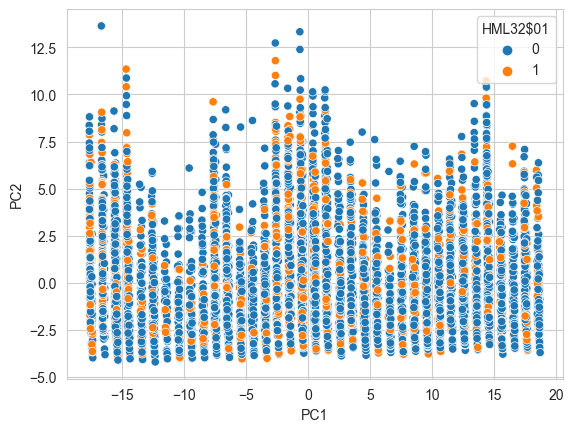

In [49]:
X = data.drop([target], axis=1)
y = data[target]

# Instantiate a PCA object and fit it to the data
pca = PCA(n_components=2)
pca.fit(X)

# Transform the data into 2D using the PCA object
X_2d = pca.transform(X)

# Plot the transformed data
# plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y)

sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=y)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [50]:
new_data =data.__deepcopy__()
Y_data = new_data.pop(target)
X_data = new_data

Class Labels Index([0, 1], dtype='int64', name='HML32$01')
Class Counts [8242 2223]
Class Percentage [78.75776398 21.24223602]


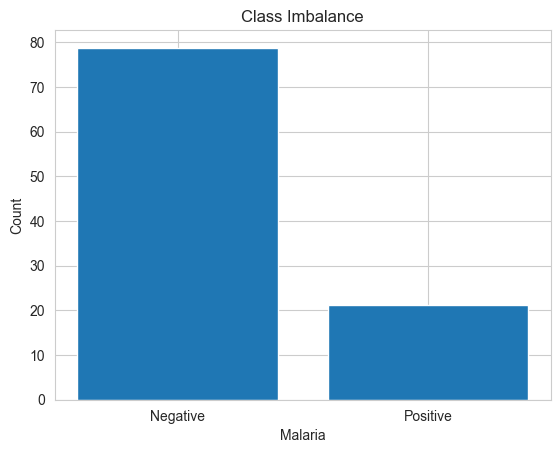

In [51]:
target_counts = Y_data.value_counts()

# Calculate the class distribution
class_labels = target_counts.index
class_counts = target_counts.values
total_samples = len(new_data)

# Calculate the percentage of each class
class_percentages = (class_counts / total_samples) * 100
print('Class Labels', class_labels)
print('Class Counts', class_counts)
print('Class Percentage', class_percentages)

# Plotting the class distribution
plt.bar(['Negative', 'Positive'], class_percentages)
plt.xlabel('Malaria')
plt.ylabel('Count')
plt.title('Class Imbalance')
plt.show()

<Axes: >

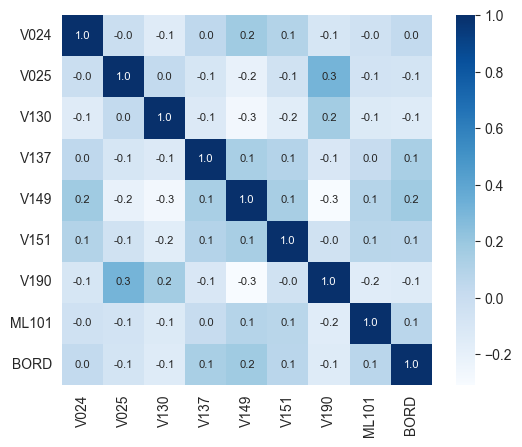

In [52]:
correlation=new_data.corr()
sns.heatmap(correlation,cbar=True,square=True,fmt='.1f',annot=True,annot_kws={'size':8},cmap="Blues")


In [53]:
def undersampling():
    # Perform undersampling
    undersampler = RandomUnderSampler(sampling_strategy='majority')
    return undersampler.fit_resample(X_data, Y_data)


def oversampling():
    # Perform oversampling
    oversampler = RandomOverSampler(sampling_strategy='minority')
    return oversampler.fit_resample(X_data, Y_data)


def smote():
    # Perform SMOTE
    smote_sampler = SMOTE(sampling_strategy='minority')
    return smote_sampler.fit_resample(X_data, Y_data)


classifier = LogisticRegression()
results = {}
seed_everything(SEED)
for algorithm in [undersampling, oversampling, smote]:
    X, Y = algorithm()
    classifier.fit(X, Y)
    predicted_labels = classifier.predict(X_data)
    accuracy = accuracy_score(Y_data, predicted_labels)
    results[algorithm.__name__] = accuracy

# Determine the best algorithm based on the accuracy
best_algorithm = max(results, key=results.get)

# Print the results and the best algorithm
print("Sampling Algorithm Results:")
for algorithm, accuracy in results.items():
    print(f"{algorithm}: {accuracy}")
print("\nBest Algorithm:")
print(best_algorithm)

Sampling Algorithm Results:
undersampling: 0.5219302436693741
oversampling: 0.5229813664596273
smote: 0.49804108934543717

Best Algorithm:
oversampling


In [54]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
# Assume X_train and y_train are your training data
thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]  # Example threshold values to test

best_threshold = None
best_score = 0

for threshold in thresholds:
    sel = VarianceThreshold(threshold=threshold)
    X_train_selected = sel.fit_transform(X_data)
    # Assume RandomForestClassifier as your model, modify it based on your problem
    clf = RandomForestClassifier()
    scores = cross_val_score(clf, X_train_selected, Y_data, cv=5, scoring='accuracy')
    avg_score = scores.mean()
    print(f"Threshold: {threshold}, Average Cross-Validation Score: {avg_score}")
    if avg_score > best_score:
        best_score = avg_score
        best_threshold = threshold

print(f"Best Threshold: {best_threshold}, Best Cross-Validation Score: {best_score}")

Threshold: 0, Average Cross-Validation Score: 0.5873865265169613
Threshold: 0.1, Average Cross-Validation Score: 0.5960821786908743
Threshold: 0.2, Average Cross-Validation Score: 0.5940754897276637
Threshold: 0.3, Average Cross-Validation Score: 0.5827998088867654
Threshold: 0.4, Average Cross-Validation Score: 0.5812709030100335
Threshold: 0.5, Average Cross-Validation Score: 0.5819397993311037
Threshold: 0.6, Average Cross-Validation Score: 0.5810797897754421
Threshold: 0.7, Average Cross-Validation Score: 0.5784997611084568
Threshold: 0.8, Average Cross-Validation Score: 0.5800286669851887
Threshold: 0.9, Average Cross-Validation Score: 0.5751552795031056
Threshold: 1, Average Cross-Validation Score: 0.5784997611084568
Best Threshold: 0.1, Best Cross-Validation Score: 0.5960821786908743


In [55]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0)
sel.fit(X_data)
sum(sel.get_support())
print(
    len([
        x for x in X_data.columns
        if x not in X_data.columns[sel.get_support()]
    ]))

importance=[x for x in X_data.columns if x not in X_data.columns[sel.get_support()]]
if len(importance) == 0 or importance == 0:
    importance = elements
    print(importance)

0
['V024     Region', 'V025     Type of place of residence', 'V130     Religion', 'V137     Number of children 5 and under in household (de jure)', 'V149     Educational attainment', 'V151     Sex of household head', 'V190     Wealth index combined', 'ML101    Type of mosquito bed net(s) slept under last night', 'BORD     Birth order number', 'HML32$01 Final result of malaria from blood smear test']


In [56]:
import matplotlib.patches as patches
from scipy import interp
class func():
    def __init__(self, train, label, test, model, model_type, random_state):
        self.train, self.label, self.test = train, label, test
        self.model, self.model_type = model, model_type
        self.random_state = random_state

        assert self.model_type in ('catboost', 'xgboost', 'lgbm', 'log', 'rad','deci', 'svm'), 'Incorrect model_type'

    def __call__(self, plot=True):
        return self.fit(plot)

    def fit(self, plot):
        def deci_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train)
            x_test_predict = self.model.predict_proba(X_test)[:, 1]
            x_train_predict = self.model.predict_proba(X_train)[:, 1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test)[:, 1]
            return x_test_predict, x_train_predict
        def svm_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train)
            x_test_predict = self.model.predict_proba(X_test)[:, 1]
            x_train_predict = self.model.predict_proba(X_train)[:, 1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test)[:, 1]
            return x_test_predict, x_train_predict
        def log_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train)
            x_test_predict = self.model.predict_proba(X_test)[:, 1]
            x_train_predict = self.model.predict_proba(X_train)[:, 1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test)[:, 1]
            return x_test_predict, x_train_predict
        
        def rad_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train)
            x_test_predict = self.model.predict_proba(X_test)[:, 1]
            x_train_predict = self.model.predict_proba(X_train)[:, 1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test)[:, 1]
            return x_test_predict, x_train_predict

        def catboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=500,
                           verbose=50, use_best_model=True)
            x_test_predict = self.model.predict_proba(X_test)[:, 1]
            x_train_predict = self.model.predict_proba(X_train)[:, 1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test)[:, 1]
            return x_test_predict, x_train_predict

        def xgboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose=True)
            x_test_predict = self.model.predict_proba(X_test, ntree_limit=self.model.get_booster().best_ntree_limit)[:,
                             1]
            x_train_predict = self.model.predict_proba(X_train, ntree_limit=self.model.get_booster().best_ntree_limit)[
                              :, 1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, ntree_limit=self.model.get_booster().best_ntree_limit)[:,
                           1]
            return x_test_predict, x_train_predict

        def lgbm_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose=True)
            x_test_predict = self.model.predict_proba(X_test, num_iteration=self.model.best_iteration_)[:, 1]
            x_train_predict = self.model.predict_proba(X_train, num_iteration=self.model.best_iteration_)[:, 1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, num_iteration=self.model.best_iteration_)[:, 1]
            return x_test_predict, x_train_predict

        self.val_p = np.zeros(self.train.shape[0])
        mean_val = []
        mean_train = []
        self.test_p = np.zeros(self.test.shape[0])
        splits = 5
        kf = StratifiedKFold(n_splits=splits)
        
        # Plot arrows
        fig1 = plt.figure(figsize=[12, 12])
        ax1 = fig1.add_subplot(111, aspect='equal')
        # ax1.add_patch(
        #     patches.Arrow(0.45, 0.5, -0.25, 0.25, width=0.3, color='green', alpha=0.5)
        # )
        # ax1.add_patch(
        #     patches.Arrow(0.5, 0.45, 0.25, -0.25, width=0.3, color='red', alpha=0.5)
        # )

        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        i = 1
        seed_everything(SEED)
        for fold_count, (train_index, test_index) in enumerate(kf.split(self.train, self.label)):
            X_train, X_test = self.train.iloc[train_index], self.train.iloc[test_index]
            y_train, y_test = self.label.iloc[train_index], self.label.iloc[test_index]

            print(f"================================Fold{fold_count + 1}====================================")
            if self.model_type == 'catboost':
                x_test_predict, x_train_predict = catboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'xgboost':
                x_test_predict, x_train_predict = xgboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'rad':
                x_test_predict, x_train_predict = rad_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'log':
                x_test_predict, x_train_predict = log_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'lgbm':
                x_test_predict, x_train_predict = lgbm_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'deci':
                x_test_predict, x_train_predict = deci_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'svm':
                x_test_predict, x_train_predict = svm_fit(X_train, X_test, y_train, y_test)
            print('\nValidation scores', roc_auc_score(y_test, x_test_predict), log_loss(y_test, x_test_predict))
            print('Training scores', roc_auc_score(y_train, x_train_predict), log_loss(y_train, x_train_predict))
            mean_val.append(roc_auc_score(y_train, x_train_predict))
            mean_train.append(roc_auc_score(y_train, x_train_predict))
            # Plot ROC curve
            fpr, tpr, _ = roc_curve(y_test, x_test_predict)
            tprs.append(interp(mean_fpr, fpr, tpr))
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
            i = i + 1
        # fig1 = plt.figure(figsize=[12, 12])
        # ax1 = fig1.add_subplot(111, aspect='equal')    
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black')
        mean_tpr = np.mean(tprs, axis=0)
        mean_auc = auc(mean_fpr, mean_tpr)
        plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)

        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC')
        plt.legend(loc="lower right")
        # plt.text(0.32, 0.7, 'More accurate area', fontsize=12)
        # plt.text(0.63, 0.4, 'Less accurate area', fontsize=12)
        plt.show()
        
        if plot and self.model_type != 'log' and self.model_type != 'svm':
            feat_imp = pd.DataFrame(sorted(zip(self.model.feature_importances_, self.train.columns)),
                                    columns=['Value', 'Feature'])
            plt.figure(figsize=(30, 25))
            # sns.barplot(x="Value", y="Feature", data=feat_imp.sort_values(by="Value", ascending=False))
            plt.barh(feat_imp['Feature'], feat_imp['Value'])
            plt.xlabel('Feature Importance Score',fontsize=40)
            plt.ylabel('Features',fontsize=40)
            plt.title('Feature Importance',fontsize=40)
            plt.tick_params(axis='both', labelsize=40)
            plt.show()
        print(np.mean(mean_val), np.mean(mean_train), np.std(mean_val))
        return self.val_p, self.test_p / splits, self.model, mean_fpr, mean_tpr, mean_auc

In [57]:
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras import layers
# import keras_tuner

In [58]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import SVC
xgboost = xgb.XGBClassifier(objectsve='binary:logistic',
                            eta=0.99,
                            max_depth=6,
                            n_estimators=5000,
                            reg_lambda=500,
                            scoring='f1',
                            sub_sample=0.8,
                            colsample_bytree=0.8)
catboost = cat_.CatBoostClassifier(n_estimators=10000, max_depth=6, eval_metric='TotalF1', reg_lambda=370)
clf_rad = RandomForestClassifier()
tree_clf = DecisionTreeClassifier(criterion='entropy',
                                  max_depth=2)
svm = SVC(kernel='sigmoid', C=1, probability=True)
def run_predictions(X_train, y_train, X_test):
    # classifier with cross validation and feature selection
    func_ = func(X_train, y_train, X_test, classifier, 'log', 1000)
    val_p, test_p, model,mean_fpr, mean_tpr, mean_auc  = func_()
    func_ = func(X_train, y_train, X_test, catboost, 'catboost', 1000)
    val_p1, test_p1, model1, mean_fpr1, mean_tpr1, mean_auc1 = func_()
    func_ = func(X_train, y_train, X_test, xgboost, 'xgboost', 1000)
    val_p2, test_p2, model2, mean_fpr2, mean_tpr2, mean_auc2 = func_()
    func_ = func(X_train, y_train, X_test, clf_rad, 'rad', 1000)
    val_p3, test_p3, model3, mean_fpr3, mean_tpr3, mean_auc3 = func_()
    func_ = func(X_train, y_train, X_test, tree_clf, 'deci', 1000)
    val_p4, test_p4, model4, mean_fpr4, mean_tpr4, mean_auc4 = func_()
    func_ = func(X_train, y_train, X_test, svm, 'svm', 1000)
    val_p5, test_p5, model5, mean_fpr5, mean_tpr5, mean_auc5 = func_()
    fig1 = plt.figure(figsize=[12, 12])
    ax1 = fig1.add_subplot(111, aspect='equal')    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black')
    plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC for Logistic Regression (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)
    plt.plot(mean_fpr1, mean_tpr1, color='red', label=r'Mean ROC for Catboost (AUC = %0.2f )' % (mean_auc1), lw=2, alpha=1)
    plt.plot(mean_fpr3, mean_tpr3, color='brown', label=r'Mean ROC for RandomForest (AUC = %0.2f )' % (mean_auc3), lw=2, alpha=1)
    plt.plot(mean_fpr4, mean_tpr4, color='orange', label=r'Mean ROC for Decision tree (AUC = %0.2f )' % (mean_auc4), lw=2, alpha=1)
    plt.plot(mean_fpr5, mean_tpr5, color='purple', label=r'Mean ROC for Support Vector Machine (AUC = %0.2f )' % (mean_auc5), lw=2, alpha=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
        # plt.text(0.32, 0.7, 'More accurate area', fontsize=12)
        # plt.text(0.63, 0.4, 'Less accurate area', fontsize=12)
    plt.show()
    return model, model1, model2, model3,model4, model5

In [59]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [60]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report,confusion_matrix,auc,roc_curve


def evaluate_model(y_true, y_pred, average='binary'):
    """
    Function to evaluate a machine learning model's performance using common evaluation metrics and the classification report.

    Parameters:
        y_true (array-like): The true labels of the data.
        y_pred (array-like): The predicted labels of the data.
        average (str, optional): The type of averaging to use for multi-class classification.
                                 Can be 'binary', 'micro', 'macro', or 'weighted'. Default is 'binary'.
                                 Ignored for binary classification problems.

    Returns:
        dict: A dictionary containing the evaluation metrics and the centered classification report.
    """

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print('Unique instance ', np.unique(y_true, return_counts=True), np.unique(y_pred, return_counts=True))
    # tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    # print('Confusion matrix', tn, fp, fn, tp)
    # print(confusion_matrix(y_true, y_pred))
    # precision = tp/(tp+fp)
    # recall = tp/(tp+fn)
    # f1 = 2*precision*recall/(precision+recall)
    # # Calculate classification report
    aa  = classification_report(y_true, y_pred, output_dict=True)
    print(aa)
    report = classification_report(y_true, y_pred)
    print('Accuracy', accuracy)
    print('Precision', precision)
    print('Recall', recall)
    print('F1 Score', f1)
    print('Classification Report')
    print(report)

    # Create dictionary of evaluation metrics and centered classification report
    metrics = {'accuracy': accuracy,
               'precision': precision,
               'recall': recall,
               'f1': f1}
    fpr, tpr, threshold = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    cm = confusion_matrix(y_true, y_pred)
    class_names = ['Class 0', 'Class 1']
    plt.figure()
    plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()
    print('Metrics for the  Evaluation is',metrics)
    return metrics

In [61]:
def eveluate_model_results(model1,model2, model, model3, model4, model5, nn_result, y_test, X_test):
    model1_pred = model1.predict(X_test)
    model3_pred = model3.predict(X_test)
    model4_pred = model4.predict(X_test)
    model5_pred = model5.predict(X_test)
    model_pred = model.predict(X_test)

    catboost_result = evaluate_model(y_test,model1_pred )
    xgboost_result = evaluate_model(y_test, model2.predict(X_test))
    logistic_regression_result = evaluate_model(y_test, model_pred)
    rad_regression_result = evaluate_model(y_test, model3_pred)
    deci_result = evaluate_model(y_test, model4_pred)
    svm_result = evaluate_model(y_test, model5_pred)
    print(
        {
          "catboost_result": catboost_result,
            "xgb":xgboost_result,
            "log":logistic_regression_result,
            "neural": nn_result,
            "radom_forest": rad_regression_result,
            "svm": svm_result,
            "decision_tree": deci_result
        }
    )
    accuracy_list = [catboost_result['accuracy'], 
                     # xgboost_result['accuracy'],
                     logistic_regression_result['accuracy'], rad_regression_result['accuracy'],
                     # nn_result['accuracy'], 
                     deci_result['accuracy'], svm_result['accuracy']]
    precision_list = [catboost_result['precision'], 
                      # xgboost_result['precision'], 
                      logistic_regression_result['precision'],rad_regression_result['accuracy'], 
                      # nn_result['precision'],
                      deci_result['precision'], svm_result['precision']]
    recall_list = [catboost_result['recall'], 
                   # xgboost_result['recall'], 
                   logistic_regression_result['recall'],rad_regression_result['accuracy'], 
                   # nn_result['recall'], 
                   deci_result['recall'], svm_result['recall']]
    f1_list = [catboost_result['f1'], 
               # xgboost_result['f1'], 
               logistic_regression_result['f1'], rad_regression_result['accuracy'], 
               # nn_result['f1'], 
               deci_result['f1'], svm_result['f1']]
    
    # Calculate percentages for accuracy list
    total_accuracy = sum(accuracy_list)
    accuracy_percentages = [round((accuracy / total_accuracy) * 100, 2) for accuracy in accuracy_list]
    
    # Calculate percentages for precision list
    total_precision = sum(precision_list)
    precision_percentages = [round((precision / total_precision) * 100, 2) for precision in precision_list]
    
    # Calculate percentages for recall list
    total_recall = sum(recall_list)
    recall_percentages = [round((recall / total_recall) * 100, 2) for recall in recall_list]
    
    # Calculate percentages for f1 list
    total_f1 = sum(f1_list)
    f1_percentages = [round((f1 / total_f1) * 100, 2) for f1 in f1_list]
    
    
    plt.title('Receiver Operating Characteristic')
    fpr, tpr, threshold = roc_curve(y_test, model1_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = 'Catboost AUC = %0.2f' % roc_auc)
    fpr, tpr, threshold = roc_curve(y_test, model3_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = 'Random Forest AUC = %0.2f' % roc_auc)
    fpr, tpr, threshold = roc_curve(y_test, model4_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = 'Decision Tree AUC = %0.2f' % roc_auc)
    fpr, tpr, threshold = roc_curve(y_test, model5_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = 'SVM AUC = %0.2f' % roc_auc)
    fpr, tpr, threshold = roc_curve(y_test, model_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = 'Logistic Regression AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    # Set colors for the bars
    colors = ['#FFC107', '#FF5722', '#4CAF50']
    
    # Plot for accuracy list with percentages
    plt.figure(figsize=(12, 6))
    # plt.bar(['Catboost', 'XGBoost', 'Logistic Regression','Random Forest', 'Neural Network', 'Decision Tree', 'SVM'], accuracy_list, color=colors)
    plt.bar(['Catboost', 'Logistic Regression','Random Forest',  'Decision Tree', 'SVM'], accuracy_list, color=colors)
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title('Accuracy of different models')
    
    # Add percentage labels to the bars
    for i, accuracy in enumerate(accuracy_list):
        plt.text(i, accuracy + 0.5, f"{accuracy_percentages[i]}%", ha='center')
    
    plt.show()
    
    # Plot for precision list with percentages
    plt.figure(figsize=(12, 6))
    # plt.bar(['Catboost', 'XGBoost', 'Logistic Regression','Random Forest','Neural Network','Decision Tree', 'SVM'], precision_list, color=colors)
    plt.bar(['Catboost',  'Logistic Regression','Random Forest','Decision Tree', 'SVM'], precision_list, color=colors)
    plt.xlabel('Model')
    plt.ylabel('Precision')
    plt.title('Precision of different models')
    
    # Add percentage labels to the bars
    for i, precision in enumerate(precision_list):
        plt.text(i, precision + 0.01, f"{precision_percentages[i]}%", ha='center')
    
    plt.show()
    
    # Plot for recall list with percentages
    plt.figure(figsize=(12, 6))
    plt.bar(['Catboost',  'Logistic Regression','Random Forest','Decision Tree', 'SVM'], recall_list, color=colors)
    # plt.bar(['Catboost', 'XGBoost', 'Logistic Regression','Random Forest','Neural Network', 'Decision Tree', 'SVM'], recall_list, color=colors)
    plt.xlabel('Model')
    plt.ylabel('Recall')
    plt.title('Recall of different models')
    
    # Add percentage labels to the bars
    for i, recall in enumerate(recall_list):
        plt.text(i, recall + 0.01, f"{recall_percentages[i]}%", ha='center')
    
    plt.show()
    
    # Plot for f1 list with percentages
    plt.figure(figsize=(12, 6))
    plt.bar(['Catboost', 'Logistic Regression','Random Forest', 'Decision Tree', 'SVM'], f1_list, color=colors)
    # plt.bar(['Catboost', 'XGBoost', 'Logistic Regression','Random Forest','Neural Network', 'Decision Tree', 'SVM'], f1_list, color=colors)
    plt.xlabel('Model')
    plt.ylabel('F1 Score')
    plt.title('F1 Score of different models')
    
    # Add percentage labels to the bars
    for i, f1 in enumerate(f1_list):
        plt.text(i, f1 + 0.01, f"{f1_percentages[i]}%", ha='center')
    
    plt.show()

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42,stratify=Y_data)

================================Fold1====================================
[09:19:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "objectsve", "scoring", "sub_sample" } are not used.

[0]	validation_0-auc:0.50000
[1]	validation_0-auc:0.49535
[2]	validation_0-auc:0.57016
[3]	validation_0-auc:0.58052
[4]	validation_0-auc:0.58937
[5]	validation_0-auc:0.59106
[6]	validation_0-auc:0.59017
[7]	validation_0-auc:0.59114
[8]	validation_0-auc:0.59312
[9]	validation_0-auc:0.59396
[10]	validation_0-auc:0.59409
[11]	validation_0-auc:0.59631
[12]	validation_0-auc:0.59528
[13]	validation_0-auc:0.59287
[14]	validation_0-auc:0.59306
[15]	validation_0-auc:0.59365
[16]	validation_0-auc:0.59423
[17]	validation_0-auc:0.59483
[18]	validation_0-auc:0.59488
[19]	validation_0-auc:0.59492
[20]	validation_0-auc:0.59301
[21]	validation_0-auc:0.59201
[22]	validation_0-auc:0.59225
[23]	validation_0-auc:0.59169
[24]	vali

/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/var/folders/xm/rq0m1_2936361j6vzf

[14]	validation_0-auc:0.57998
[15]	validation_0-auc:0.57779
[16]	validation_0-auc:0.57454
[17]	validation_0-auc:0.57463
[18]	validation_0-auc:0.57609
[19]	validation_0-auc:0.57661
[20]	validation_0-auc:0.57749
[21]	validation_0-auc:0.57719
[22]	validation_0-auc:0.57894
[23]	validation_0-auc:0.57974
[24]	validation_0-auc:0.57944
[25]	validation_0-auc:0.57832
[26]	validation_0-auc:0.57908
[27]	validation_0-auc:0.57645
[28]	validation_0-auc:0.57603
[29]	validation_0-auc:0.57587
[30]	validation_0-auc:0.57697
[31]	validation_0-auc:0.57529
[32]	validation_0-auc:0.57605
[33]	validation_0-auc:0.57722
[34]	validation_0-auc:0.57655
[35]	validation_0-auc:0.57351
[36]	validation_0-auc:0.57240
[37]	validation_0-auc:0.57119
[38]	validation_0-auc:0.57091
[39]	validation_0-auc:0.57128
[40]	validation_0-auc:0.57197
[41]	validation_0-auc:0.57175
[42]	validation_0-auc:0.57031
[43]	validation_0-auc:0.57066

Validation scores 0.5811348399792149 0.5112437257161653
Training scores 0.6539161850674239 0.496583

/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:8

[37]	validation_0-auc:0.61294
[38]	validation_0-auc:0.61254
[39]	validation_0-auc:0.61211
[40]	validation_0-auc:0.61311
[41]	validation_0-auc:0.61272
[42]	validation_0-auc:0.61136
[43]	validation_0-auc:0.61030
[44]	validation_0-auc:0.60976
[45]	validation_0-auc:0.60966
[46]	validation_0-auc:0.60877
[47]	validation_0-auc:0.60987
[48]	validation_0-auc:0.60971
[49]	validation_0-auc:0.61074
[50]	validation_0-auc:0.61055
[51]	validation_0-auc:0.60848
[52]	validation_0-auc:0.60867
[53]	validation_0-auc:0.60977
[54]	validation_0-auc:0.61010
[55]	validation_0-auc:0.61010
[56]	validation_0-auc:0.61141
[57]	validation_0-auc:0.61144
[58]	validation_0-auc:0.61124
[59]	validation_0-auc:0.60954
[60]	validation_0-auc:0.60933
[61]	validation_0-auc:0.61033
[62]	validation_0-auc:0.60974

Validation scores 0.6166077587587694 0.5031731963388957
Training scores 0.687333149044306 0.4870240878767562
================================Fold5====================================
[09:19:02] WARNING: /Users/runner/wo

/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:8

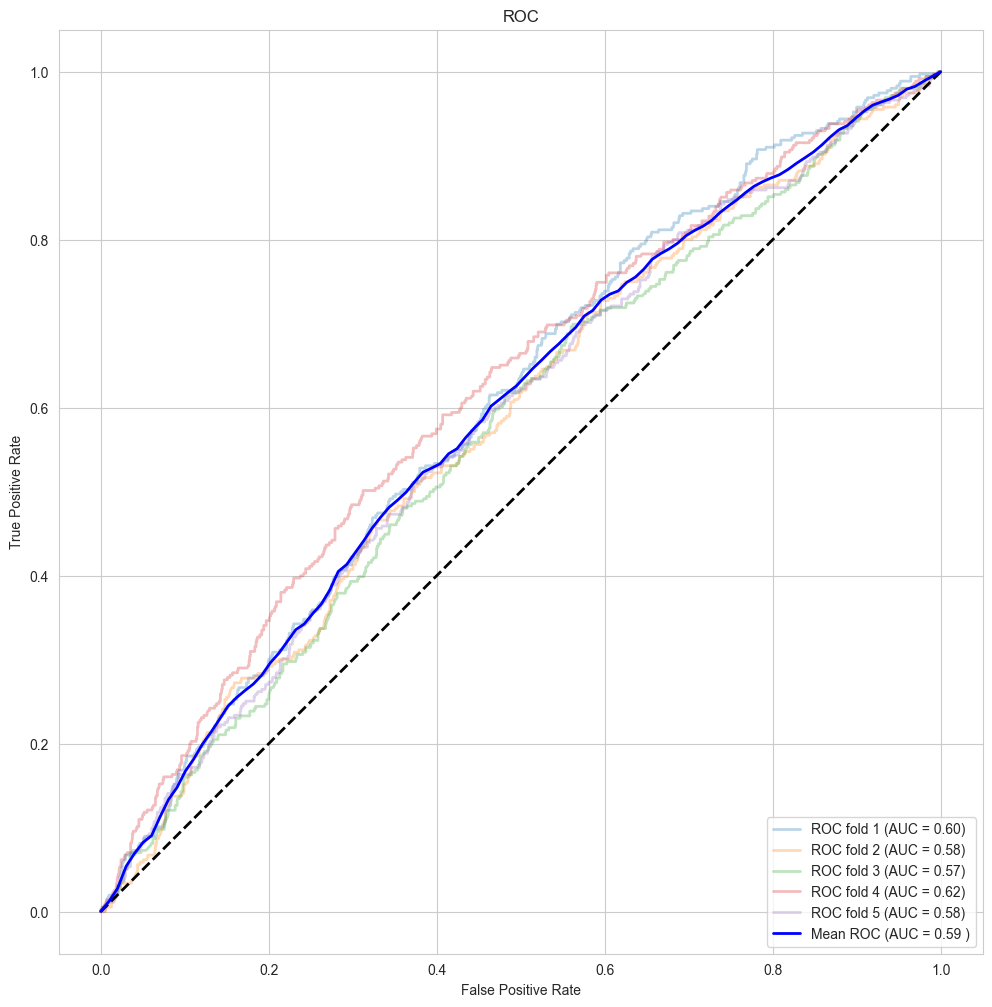

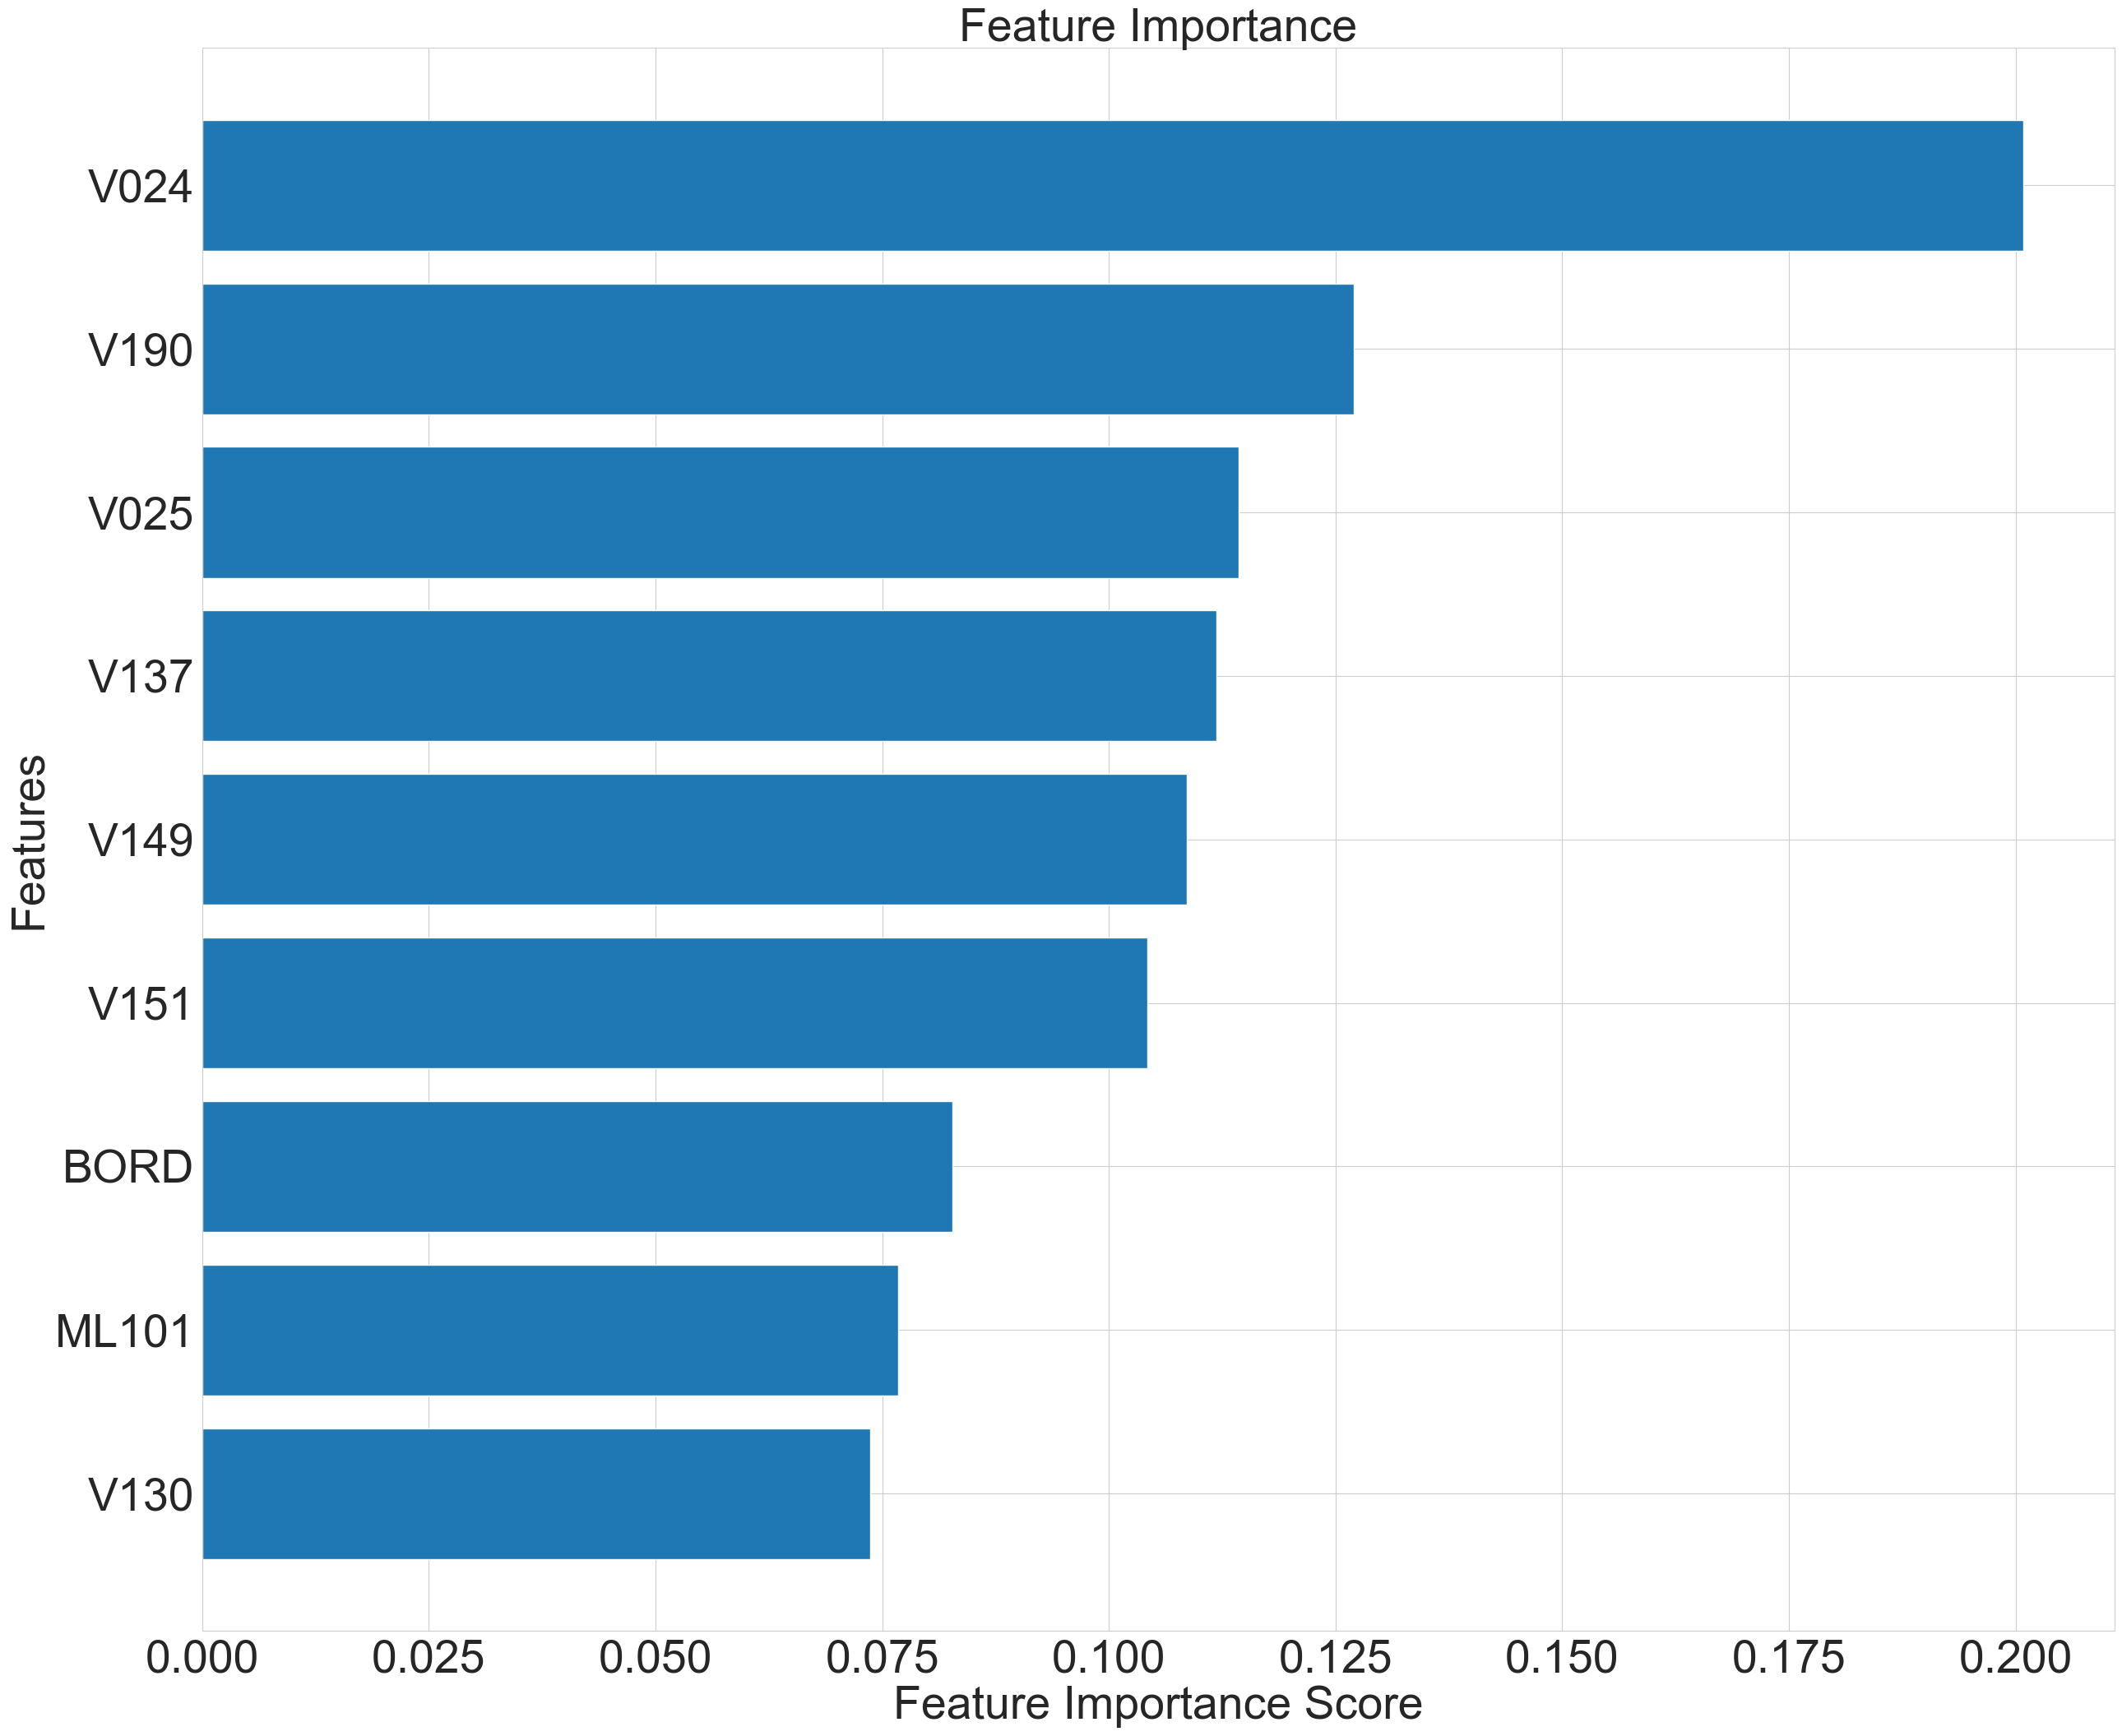

0.6811090954393795 0.6811090954393795 0.01816258664086279


In [63]:
func_ = func(X_train, y_train, X_test, xgboost, 'xgboost', 1000)
val_p2, test_p2, model2, mean_fpr, mean_tpr, mean_auc = func_()

In [64]:
# from sklearn.preprocessing import MinMaxScaler
# # one hot representation
# _y_train = to_categorical(y_train)
# # _y_test = to_categorical(y_test)
# 
# # Normalization
# minmaxscaler = MinMaxScaler(feature_range = (0,1))
# X_train = minmaxscaler.fit_transform(X_train)
# X_test = minmaxscaler.transform(X_test)


In [65]:
from sklearn.preprocessing import MinMaxScaler
def train_neural(X_train, y_train, X_test, y_test):
 
    # one hot representation
    y_train = to_categorical(y_train)
    # _y_test = to_categorical(y_test)
    
    # Normalization
    minmaxscaler = MinMaxScaler(feature_range = (0,1))
    X_train = minmaxscaler.fit_transform(X_train)
    X_test = minmaxscaler.transform(X_test)

    network = Sequential()
    network.add(Dense(50, activation='relu', input_dim=X_train.shape[-1]))
    network.add(Dropout(0.2))
    network.add(Dense(25, activation='relu'))
    network.add(Dense(7, activation='relu'))
    network.add(Dense(2, activation='softmax'))  # Changed activation to 'softmax'
    network.compile(optimizer='adam',
                    loss='categorical_crossentropy',  # Changed loss function
                    metrics=['accuracy'])
    network.fit(X_train, y_train, epochs=3, batch_size=128, verbose=0)
    ppred = network.predict(X_test)
    predicted_labels = np.argmax(ppred, axis=1)
    print(y_test)
    nn_result = evaluate_model(y_test,predicted_labels)
    return nn_result

# Assuming y_train and y_test are integer labels (e.g., 0, 1)
# aa = train_neural(X_train, y_train, X_test, y_test)
# scores2 = aa.evaluate(X_test, y_test, verbose=2)
# rounded_predictions = aa.predict(X_test)

0:	learn: 0.6940535	total: 1.79ms	remaining: 17.9s
1:	learn: 0.6940535	total: 3.63ms	remaining: 18.1s
2:	learn: 0.6940535	total: 5.02ms	remaining: 16.7s
3:	learn: 0.6940535	total: 6.55ms	remaining: 16.4s
4:	learn: 0.6940535	total: 8.01ms	remaining: 16s
5:	learn: 0.6940535	total: 10.4ms	remaining: 17.4s
6:	learn: 0.6940535	total: 12.6ms	remaining: 18s
7:	learn: 0.6940535	total: 14.7ms	remaining: 18.4s
8:	learn: 0.6940535	total: 18.7ms	remaining: 20.8s
9:	learn: 0.6940535	total: 20.6ms	remaining: 20.6s
10:	learn: 0.6940535	total: 22.1ms	remaining: 20s
11:	learn: 0.6940535	total: 23.4ms	remaining: 19.5s
12:	learn: 0.6940535	total: 24.8ms	remaining: 19s
13:	learn: 0.6940535	total: 26.2ms	remaining: 18.7s
14:	learn: 0.6940535	total: 27.7ms	remaining: 18.4s
15:	learn: 0.6940535	total: 31ms	remaining: 19.4s
16:	learn: 0.6940535	total: 32.4ms	remaining: 19s
17:	learn: 0.6940535	total: 33.9ms	remaining: 18.8s
18:	learn: 0.6940535	total: 35.4ms	remaining: 18.6s
19:	learn: 0.6940535	total: 38.2ms

/Library/Python/3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


45:	learn: 0.6940535	total: 90.8ms	remaining: 19.7s
46:	learn: 0.6940535	total: 93.7ms	remaining: 19.8s
47:	learn: 0.6940535	total: 95.1ms	remaining: 19.7s
48:	learn: 0.6940535	total: 96.4ms	remaining: 19.6s
49:	learn: 0.6940535	total: 98.5ms	remaining: 19.6s
50:	learn: 0.6940535	total: 100ms	remaining: 19.5s
51:	learn: 0.6940535	total: 104ms	remaining: 19.8s
52:	learn: 0.6940535	total: 107ms	remaining: 20.1s
53:	learn: 0.6940535	total: 111ms	remaining: 20.4s
54:	learn: 0.6940535	total: 113ms	remaining: 20.4s
55:	learn: 0.6940535	total: 114ms	remaining: 20.3s
56:	learn: 0.6940535	total: 116ms	remaining: 20.2s
57:	learn: 0.6940535	total: 117ms	remaining: 20.1s
58:	learn: 0.6940535	total: 119ms	remaining: 20s
59:	learn: 0.6940535	total: 120ms	remaining: 19.9s
60:	learn: 0.6940535	total: 121ms	remaining: 19.8s
61:	learn: 0.6940535	total: 123ms	remaining: 19.7s
62:	learn: 0.6940535	total: 124ms	remaining: 19.6s
63:	learn: 0.6940535	total: 126ms	remaining: 19.5s
64:	learn: 0.6940535	total: 

/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Prec

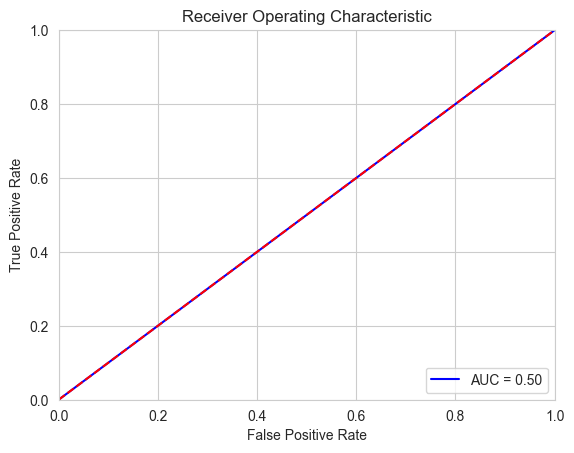

Normalized confusion matrix


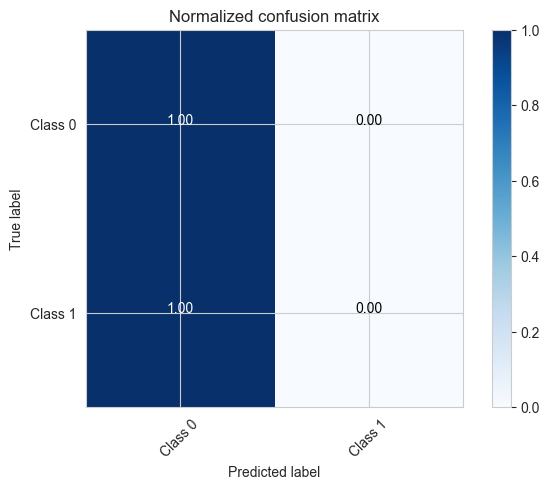

Metrics for the  Evaluation is {'accuracy': 0.7873865265169613, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
Unique instance  (array([0, 1]), array([1648,  445])) (array([0, 1]), array([2021,   72]))
{'0': {'precision': 0.7877288471053934, 'recall': 0.9660194174757282, 'f1-score': 0.8678113927500682, 'support': 1648}, '1': {'precision': 0.2222222222222222, 'recall': 0.035955056179775284, 'f1-score': 0.061895551257253385, 'support': 445}, 'accuracy': 0.7682752030578117, 'macro avg': {'precision': 0.5049755346638078, 'recall': 0.5009872368277517, 'f1-score': 0.46485347200366084, 'support': 2093}, 'weighted avg': {'precision': 0.6674945193113125, 'recall': 0.7682752030578117, 'f1-score': 0.6964628263552749, 'support': 2093}}
Accuracy 0.7682752030578117
Precision 0.2222222222222222
Recall 0.035955056179775284
F1 Score 0.061895551257253385
Classification Report
              precision    recall  f1-score   support

           0       0.79      0.97      0.87      1648
           1       0.22

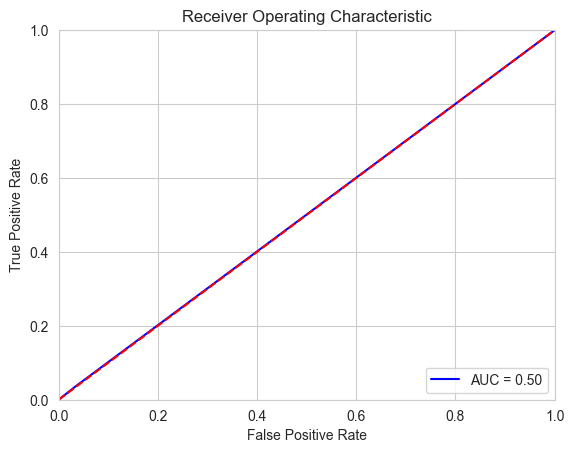

Normalized confusion matrix


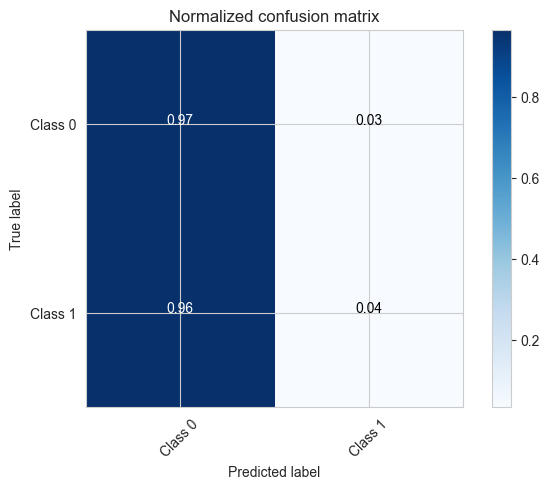

Metrics for the  Evaluation is {'accuracy': 0.7682752030578117, 'precision': 0.2222222222222222, 'recall': 0.035955056179775284, 'f1': 0.061895551257253385}
Unique instance  (array([0, 1]), array([1648,  445])) (array([0, 1]), array([1868,  225]))
{'0': {'precision': 0.791220556745182, 'recall': 0.8968446601941747, 'f1-score': 0.8407281001137656, 'support': 1648}, '1': {'precision': 0.24444444444444444, 'recall': 0.12359550561797752, 'f1-score': 0.16417910447761194, 'support': 445}, 'accuracy': 0.7324414715719063, 'macro avg': {'precision': 0.5178325005948132, 'recall': 0.5102200829060761, 'f1-score': 0.5024536022956888, 'support': 2093}, 'weighted avg': {'precision': 0.6749685882913702, 'recall': 0.7324414715719063, 'f1-score': 0.6968846681701018, 'support': 2093}}
Accuracy 0.7324414715719063
Precision 0.24444444444444444
Recall 0.12359550561797752
F1 Score 0.16417910447761194
Classification Report
              precision    recall  f1-score   support

           0       0.79      0.9

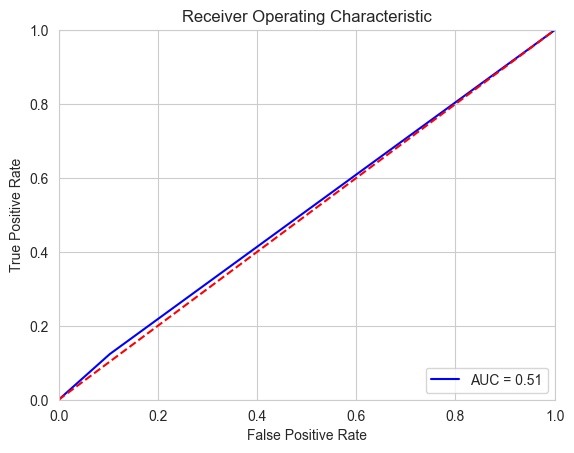

Normalized confusion matrix


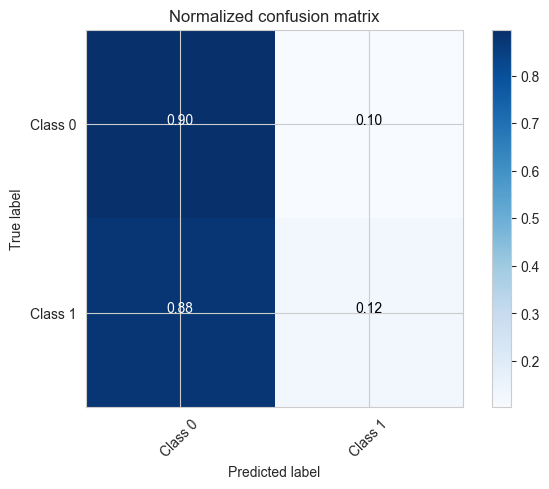

Metrics for the  Evaluation is {'accuracy': 0.7324414715719063, 'precision': 0.24444444444444444, 'recall': 0.12359550561797752, 'f1': 0.16417910447761194}
Unique instance  (array([0, 1]), array([1648,  445])) (array([0]), array([2093]))
{'0': {'precision': 0.7873865265169613, 'recall': 1.0, 'f1-score': 0.8810478481689388, 'support': 1648}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 445}, 'accuracy': 0.7873865265169613, 'macro avg': {'precision': 0.39369326325848064, 'recall': 0.5, 'f1-score': 0.4405239240844694, 'support': 2093}, 'weighted avg': {'precision': 0.6199775421404453, 'recall': 0.7873865265169613, 'f1-score': 0.6937252048649838, 'support': 2093}}
Accuracy 0.7873865265169613
Precision 0.0
Recall 0.0
F1 Score 0.0
Classification Report
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      1648
           1       0.00      0.00      0.00       445

    accuracy                           0.79      2093
   

/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Prec

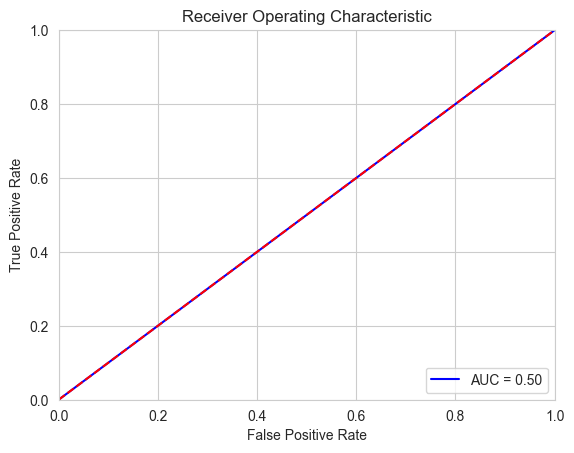

Normalized confusion matrix


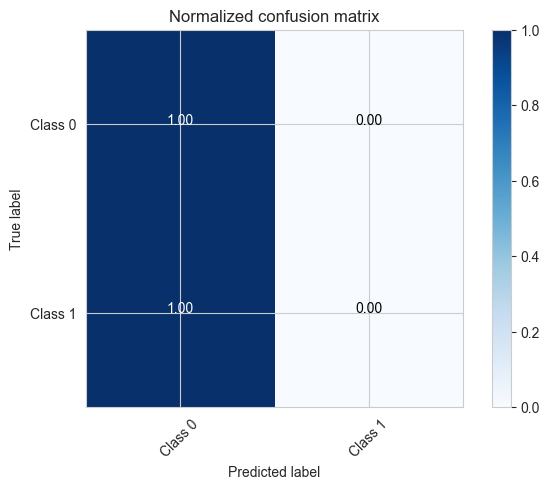

Metrics for the  Evaluation is {'accuracy': 0.7873865265169613, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
Unique instance  (array([0, 1]), array([1648,  445])) (array([0, 1]), array([1889,  204]))
{'0': {'precision': 0.7961884595023823, 'recall': 0.912621359223301, 'f1-score': 0.8504382244840261, 'support': 1648}, '1': {'precision': 0.29411764705882354, 'recall': 0.1348314606741573, 'f1-score': 0.18489984591679506, 'support': 445}, 'accuracy': 0.7472527472527473, 'macro avg': {'precision': 0.5451530532806029, 'recall': 0.5237264099487291, 'f1-score': 0.5176690352004105, 'support': 2093}, 'weighted avg': {'precision': 0.6894414401343061, 'recall': 0.7472527472527473, 'f1-score': 0.7089357980805775, 'support': 2093}}
Accuracy 0.7472527472527473
Precision 0.29411764705882354
Recall 0.1348314606741573
F1 Score 0.18489984591679506
Classification Report
              precision    recall  f1-score   support

           0       0.80      0.91      0.85      1648
           1       0.29      

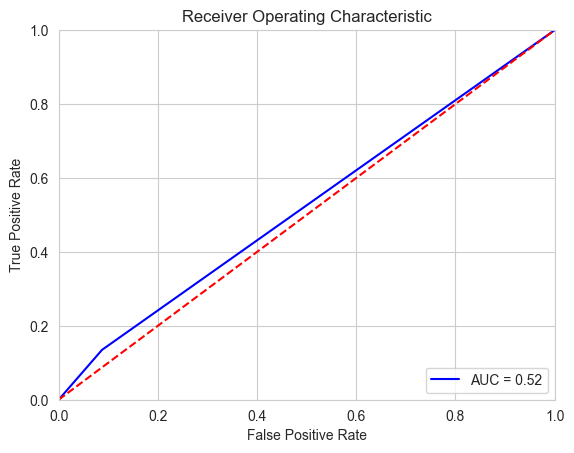

Normalized confusion matrix


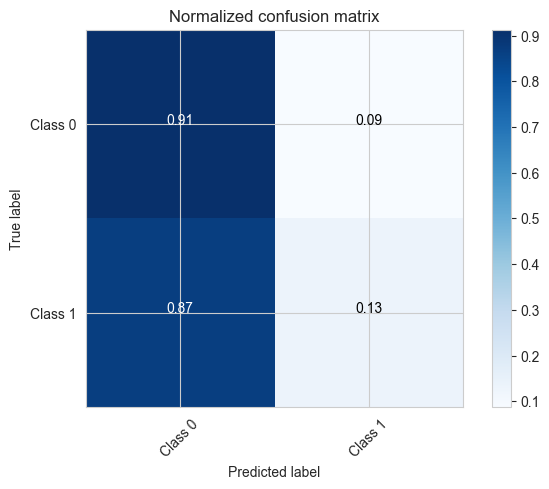

Metrics for the  Evaluation is {'accuracy': 0.7472527472527473, 'precision': 0.29411764705882354, 'recall': 0.1348314606741573, 'f1': 0.18489984591679506}
Unique instance  (array([0, 1]), array([1648,  445])) (array([0]), array([2093]))
{'0': {'precision': 0.7873865265169613, 'recall': 1.0, 'f1-score': 0.8810478481689388, 'support': 1648}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 445}, 'accuracy': 0.7873865265169613, 'macro avg': {'precision': 0.39369326325848064, 'recall': 0.5, 'f1-score': 0.4405239240844694, 'support': 2093}, 'weighted avg': {'precision': 0.6199775421404453, 'recall': 0.7873865265169613, 'f1-score': 0.6937252048649838, 'support': 2093}}
Accuracy 0.7873865265169613
Precision 0.0
Recall 0.0
F1 Score 0.0
Classification Report
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      1648
           1       0.00      0.00      0.00       445

    accuracy                           0.79      2093
   m

/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Prec

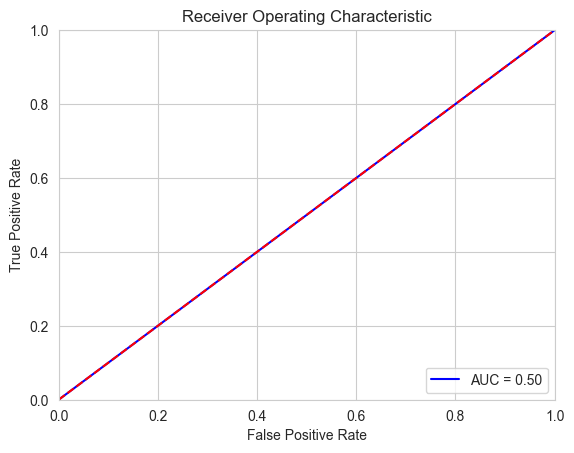

Normalized confusion matrix


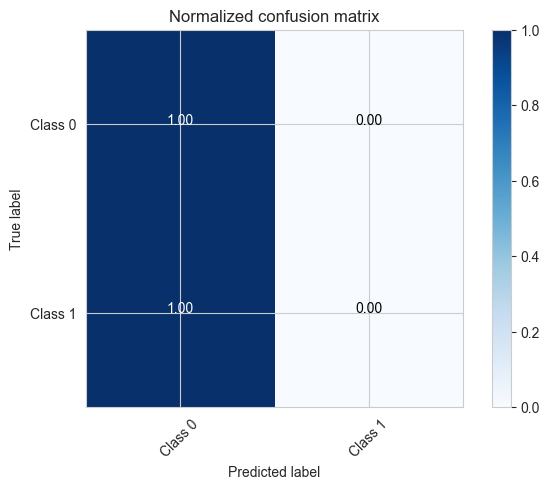

Metrics for the  Evaluation is {'accuracy': 0.7873865265169613, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
Unique instance  (array([0, 1]), array([1648,  445])) (array([0, 1]), array([1643,  450]))
{'0': {'precision': 0.7851491174680463, 'recall': 0.7827669902912622, 'f1-score': 0.7839562443026435, 'support': 1648}, '1': {'precision': 0.20444444444444446, 'recall': 0.20674157303370785, 'f1-score': 0.20558659217877095, 'support': 445}, 'accuracy': 0.6602962255136168, 'macro avg': {'precision': 0.49479678095624535, 'recall': 0.49475428166248503, 'f1-score': 0.49477141824070725, 'support': 2093}, 'weighted avg': {'precision': 0.6616834798686662, 'recall': 0.6602962255136168, 'f1-score': 0.6609870636074102, 'support': 2093}}
Accuracy 0.6602962255136168
Precision 0.20444444444444446
Recall 0.20674157303370785
F1 Score 0.20558659217877095
Classification Report
              precision    recall  f1-score   support

           0       0.79      0.78      0.78      1648
           1       0.20

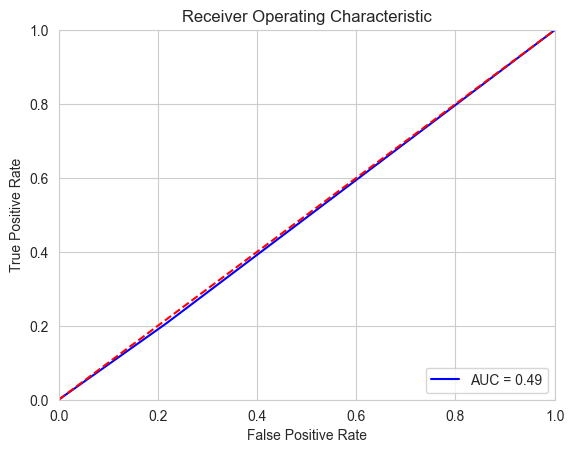

Normalized confusion matrix


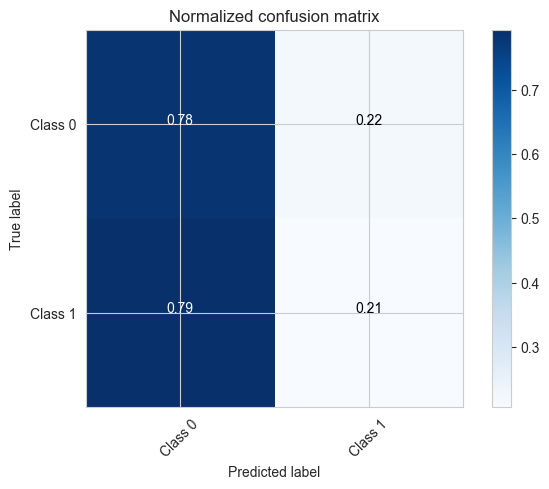

Metrics for the  Evaluation is {'accuracy': 0.6602962255136168, 'precision': 0.20444444444444446, 'recall': 0.20674157303370785, 'f1': 0.20558659217877095}
{'catboost_result': {'accuracy': 0.7682752030578117, 'precision': 0.2222222222222222, 'recall': 0.035955056179775284, 'f1': 0.061895551257253385}, 'xgb': {'accuracy': 0.7324414715719063, 'precision': 0.24444444444444444, 'recall': 0.12359550561797752, 'f1': 0.16417910447761194}, 'log': {'accuracy': 0.7873865265169613, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'neural': {'accuracy': 0.7873865265169613, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'radom_forest': {'accuracy': 0.7472527472527473, 'precision': 0.29411764705882354, 'recall': 0.1348314606741573, 'f1': 0.18489984591679506}, 'svm': {'accuracy': 0.6602962255136168, 'precision': 0.20444444444444446, 'recall': 0.20674157303370785, 'f1': 0.20558659217877095}, 'decision_tree': {'accuracy': 0.7873865265169613, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}}


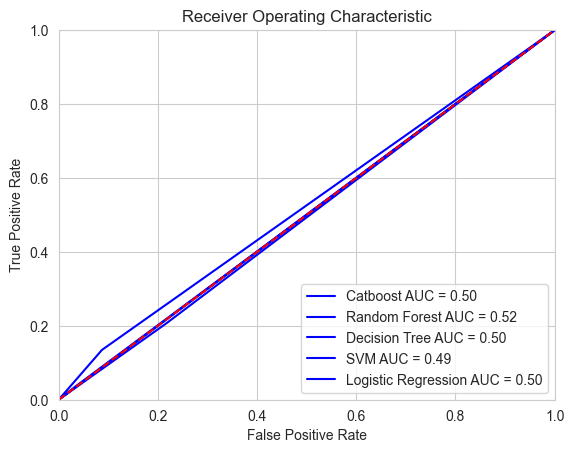

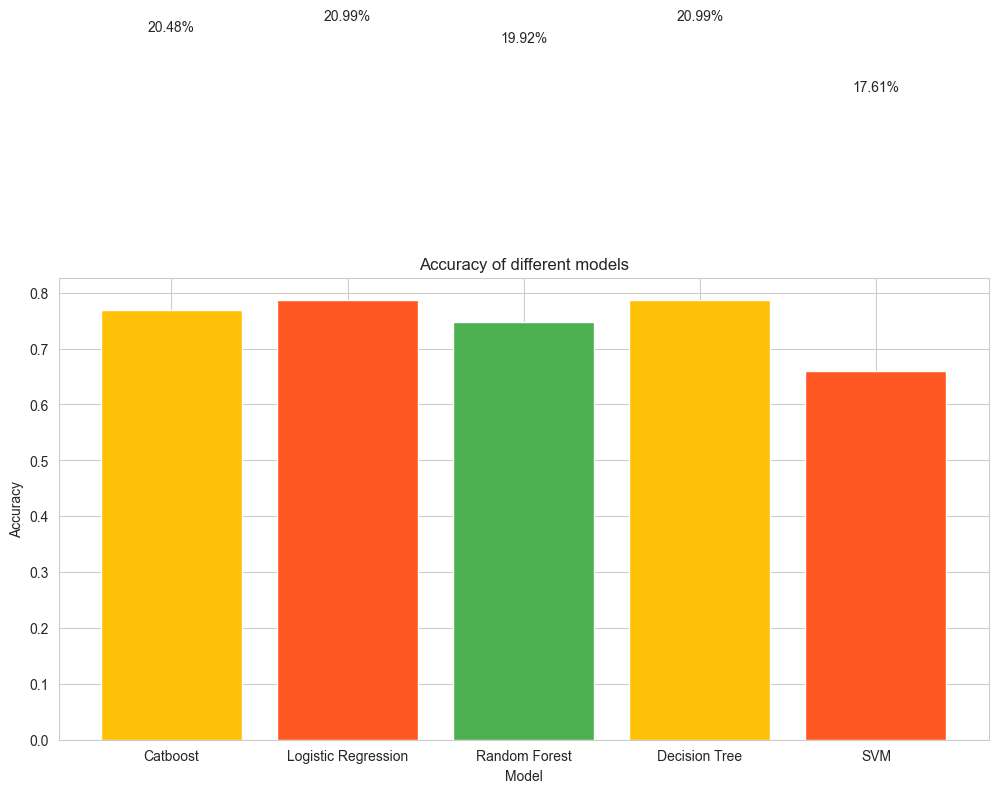

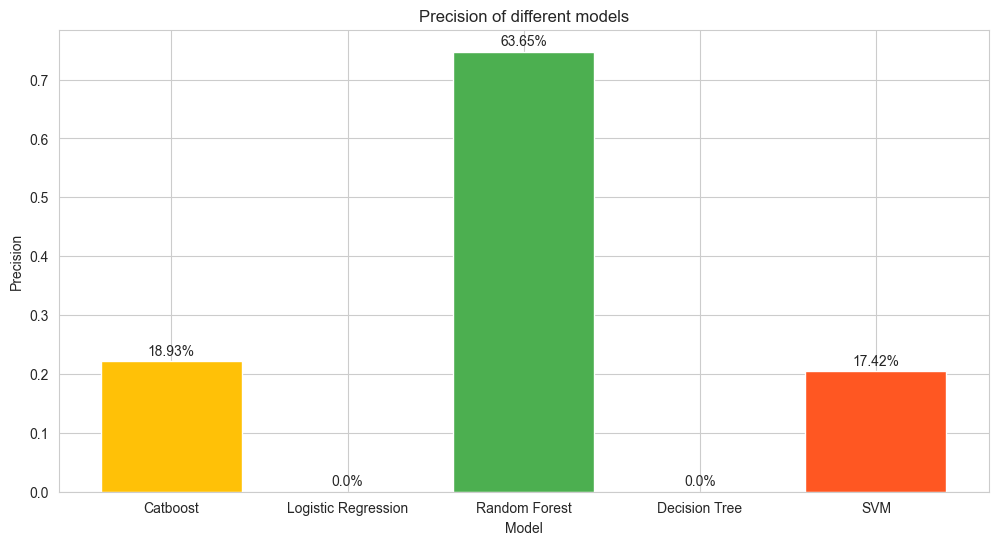

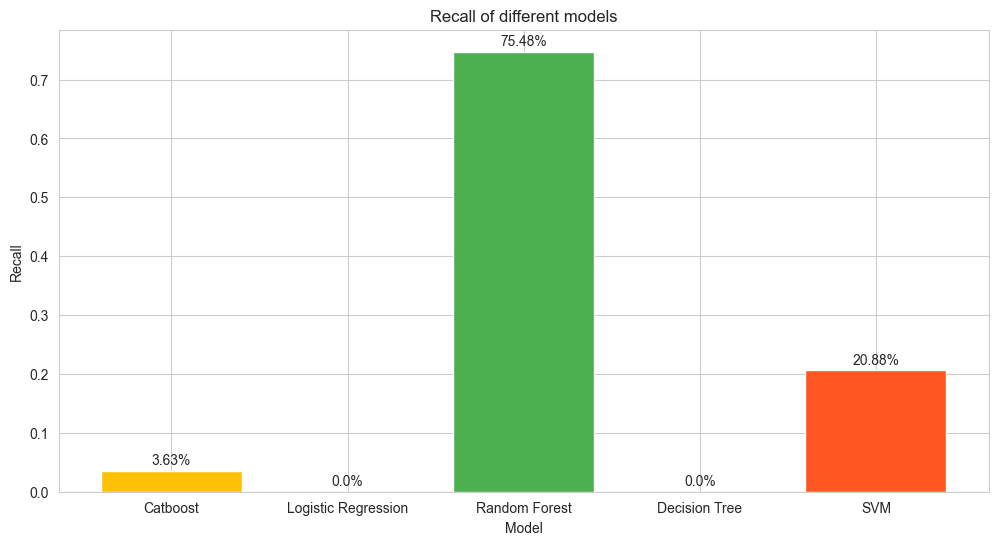

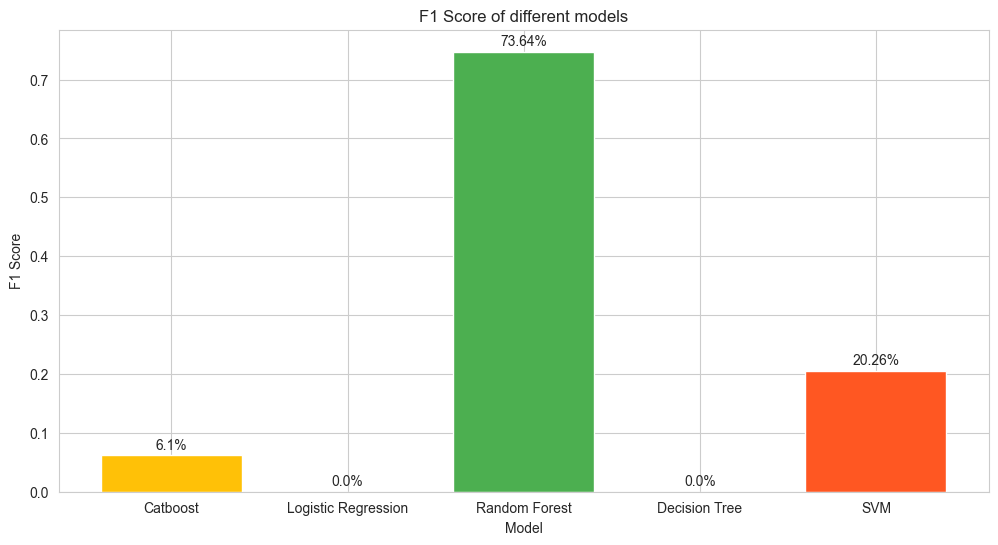

In [66]:
# Results without cross validation and without sampling
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42, stratify=Y_data)
with_out_cross_classifier = classifier.fit(X_train, y_train)
with_out_cross_catboost = catboost.fit(X_train, y_train)
with_out_cross_xgboost = xgboost.fit(X_train, y_train)
with_out_cross_rad = clf_rad.fit(X_train, y_train)
with_out_cross_neural_result = train_neural(X_train,y_train,X_test, y_test)
with_out_cross_deci = tree_clf.fit(X_train, y_train)
with_out_cross_svm = svm.fit(X_train, y_train)
eveluate_model_results(with_out_cross_catboost,with_out_cross_xgboost, with_out_cross_classifier,with_out_cross_rad, with_out_cross_deci, with_out_cross_svm,with_out_cross_neural_result, y_test, X_test)

In [67]:
# a a=a as 

In [68]:
# # Results with cross validation and without sampling
# with_cross_classifier,with_cross_catboost,with_cross_xgboost, with_out_cross_rad = run_predictions(X_train,y_train, X_test)
# with_cross_neural_result = train_neural(X_train,y_train,X_test, y_test)
# eveluate_model_results(with_cross_catboost,with_cross_xgboost, with_cross_classifier, with_out_cross_rad, with_cross_neural_result, y_test, X_test)

================================Fold1====================================

Validation scores 0.5575863992980723 0.5135712362050033
Training scores 0.5558560468201118 0.5137987444131525
================================Fold2====================================

Validation scores 0.5293602150079648 0.5178183766172145
Training scores 0.5626300984528831 0.5128075525919987
================================Fold3====================================

Validation scores 0.5431929975618489 0.5154879478441646
Training scores 0.558696653582979 0.5133371447371156
================================Fold4====================================


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/Library/Python/3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/xm/rq0m1_2936361


Validation scores 0.5582494207092441 0.5129693982931653
Training scores 0.5561335273918995 0.5140423154025918
================================Fold5====================================

Validation scores 0.5595062413907249 0.5133460697244885
Training scores 0.5555507521989789 0.5138665680395086


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


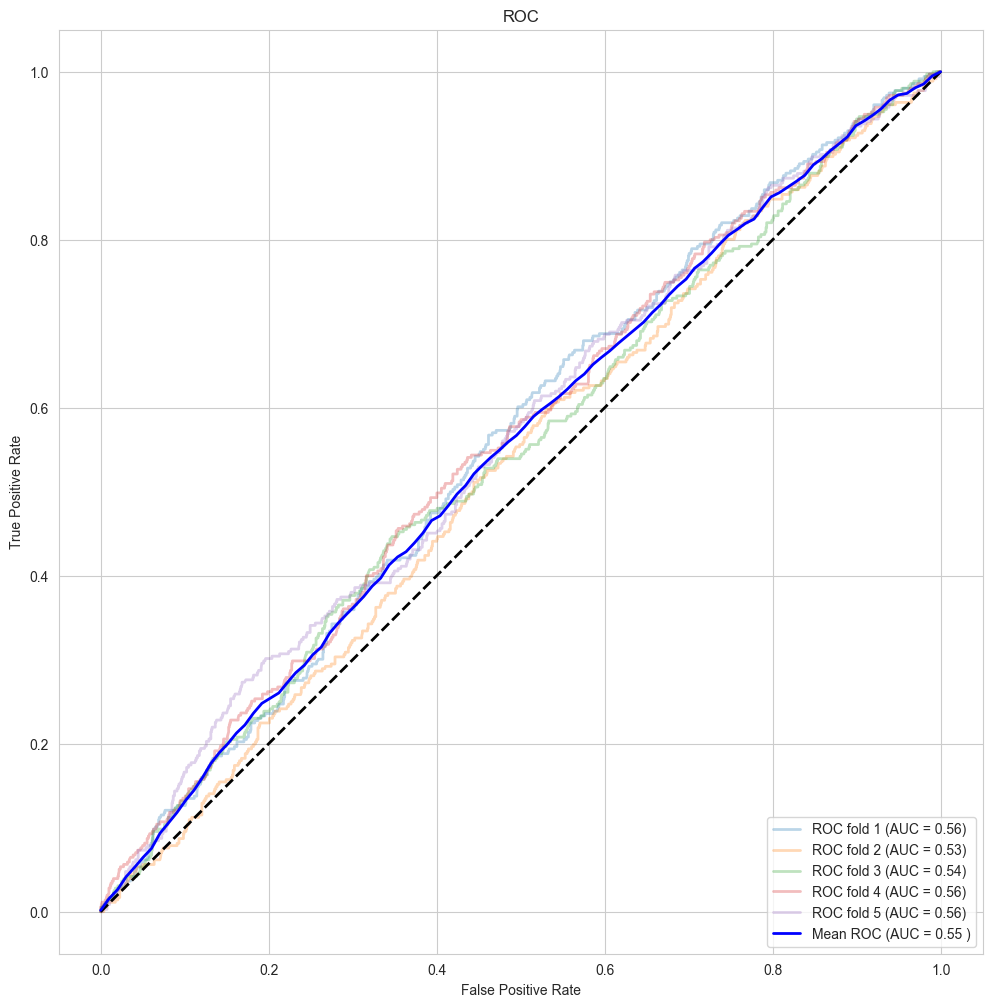

0.5577734156893704 0.5577734156893704 0.0026737803078824645
================================Fold1====================================
0:	learn: 0.6954581	test: 0.6952524	best: 0.6952524 (0)	total: 8.4ms	remaining: 1m 24s
50:	learn: 0.6941094	test: 0.6938298	best: 0.6952524 (0)	total: 87.9ms	remaining: 17.1s
100:	learn: 0.6941094	test: 0.6938298	best: 0.6952524 (0)	total: 161ms	remaining: 15.8s
150:	learn: 0.6941094	test: 0.6938298	best: 0.6952524 (0)	total: 234ms	remaining: 15.2s
200:	learn: 0.6941094	test: 0.6938298	best: 0.6952524 (0)	total: 306ms	remaining: 14.9s
250:	learn: 0.6941094	test: 0.6938298	best: 0.6952524 (0)	total: 379ms	remaining: 14.7s
300:	learn: 0.6941094	test: 0.6938298	best: 0.6952524 (0)	total: 452ms	remaining: 14.6s
350:	learn: 0.6941094	test: 0.6938298	best: 0.6952524 (0)	total: 525ms	remaining: 14.4s
400:	learn: 0.6941094	test: 0.6938298	best: 0.6952524 (0)	total: 602ms	remaining: 14.4s
450:	learn: 0.6941094	test: 0.6938298	best: 0.6952524 (0)	total: 679ms	rema

/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


100:	learn: 0.6941094	test: 0.6938298	best: 0.6938298 (0)	total: 145ms	remaining: 14.2s
150:	learn: 0.6941094	test: 0.6938298	best: 0.6938298 (0)	total: 221ms	remaining: 14.4s
200:	learn: 0.6941094	test: 0.6938298	best: 0.6938298 (0)	total: 295ms	remaining: 14.4s
250:	learn: 0.6941094	test: 0.6938298	best: 0.6938298 (0)	total: 367ms	remaining: 14.3s
300:	learn: 0.6941094	test: 0.6938298	best: 0.6938298 (0)	total: 440ms	remaining: 14.2s
350:	learn: 0.6941094	test: 0.6938298	best: 0.6938298 (0)	total: 515ms	remaining: 14.2s
400:	learn: 0.6941094	test: 0.6938298	best: 0.6938298 (0)	total: 589ms	remaining: 14.1s
450:	learn: 0.6941094	test: 0.6938298	best: 0.6938298 (0)	total: 665ms	remaining: 14.1s
500:	learn: 0.6941094	test: 0.6938298	best: 0.6938298 (0)	total: 740ms	remaining: 14s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6938298488
bestIteration = 0

Shrink model to first 1 iterations.

Validation scores 0.5222706595905989 0.6831854104857431
Training scores 0.

/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


50:	learn: 0.6941529	test: 0.6936554	best: 0.6936554 (0)	total: 74.8ms	remaining: 14.6s
100:	learn: 0.6941529	test: 0.6936554	best: 0.6936554 (0)	total: 148ms	remaining: 14.5s
150:	learn: 0.6941529	test: 0.6936554	best: 0.6936554 (0)	total: 221ms	remaining: 14.4s
200:	learn: 0.6941529	test: 0.6936554	best: 0.6936554 (0)	total: 293ms	remaining: 14.3s
250:	learn: 0.6941529	test: 0.6936554	best: 0.6936554 (0)	total: 366ms	remaining: 14.2s
300:	learn: 0.6941529	test: 0.6936554	best: 0.6936554 (0)	total: 439ms	remaining: 14.1s
350:	learn: 0.6941529	test: 0.6936554	best: 0.6936554 (0)	total: 513ms	remaining: 14.1s
400:	learn: 0.6941529	test: 0.6936554	best: 0.6936554 (0)	total: 588ms	remaining: 14.1s
450:	learn: 0.6941529	test: 0.6936554	best: 0.6936554 (0)	total: 663ms	remaining: 14s
500:	learn: 0.6941529	test: 0.6936554	best: 0.6936554 (0)	total: 738ms	remaining: 14s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6936554029
bestIteration = 0

Shrink model to first 1 i

/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


150:	learn: 0.6939478	test: 0.6944763	best: 0.6944763 (0)	total: 219ms	remaining: 14.3s
200:	learn: 0.6939478	test: 0.6944763	best: 0.6944763 (0)	total: 292ms	remaining: 14.3s
250:	learn: 0.6939478	test: 0.6944763	best: 0.6944763 (0)	total: 367ms	remaining: 14.2s
300:	learn: 0.6939478	test: 0.6944763	best: 0.6944763 (0)	total: 440ms	remaining: 14.2s
350:	learn: 0.6939478	test: 0.6944763	best: 0.6944763 (0)	total: 516ms	remaining: 14.2s
400:	learn: 0.6939478	test: 0.6944763	best: 0.6944763 (0)	total: 590ms	remaining: 14.1s
450:	learn: 0.6939478	test: 0.6944763	best: 0.6944763 (0)	total: 664ms	remaining: 14.1s
500:	learn: 0.6939478	test: 0.6944763	best: 0.6944763 (0)	total: 738ms	remaining: 14s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.694476279
bestIteration = 0

Shrink model to first 1 iterations.

Validation scores 0.5290147251972792 0.6830773693636383
Training scores 0.5337986298221833 0.6830649428320161
================================Fold5================

/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


100:	learn: 0.6939478	test: 0.6944763	best: 0.6944763 (0)	total: 150ms	remaining: 14.7s
150:	learn: 0.6939478	test: 0.6944763	best: 0.6944763 (0)	total: 224ms	remaining: 14.6s
200:	learn: 0.6939478	test: 0.6944763	best: 0.6944763 (0)	total: 298ms	remaining: 14.5s
250:	learn: 0.6939478	test: 0.6944763	best: 0.6944763 (0)	total: 372ms	remaining: 14.4s
300:	learn: 0.6939478	test: 0.6944763	best: 0.6944763 (0)	total: 445ms	remaining: 14.3s
350:	learn: 0.6939478	test: 0.6944763	best: 0.6944763 (0)	total: 519ms	remaining: 14.3s
400:	learn: 0.6939478	test: 0.6944763	best: 0.6944763 (0)	total: 593ms	remaining: 14.2s
450:	learn: 0.6939478	test: 0.6944763	best: 0.6944763 (0)	total: 671ms	remaining: 14.2s
500:	learn: 0.6939478	test: 0.6944763	best: 0.6944763 (0)	total: 746ms	remaining: 14.1s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.694476279
bestIteration = 0

Shrink model to first 1 iterations.

Validation scores 0.5454110561778557 0.6832006624297403
Training scores 0

/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


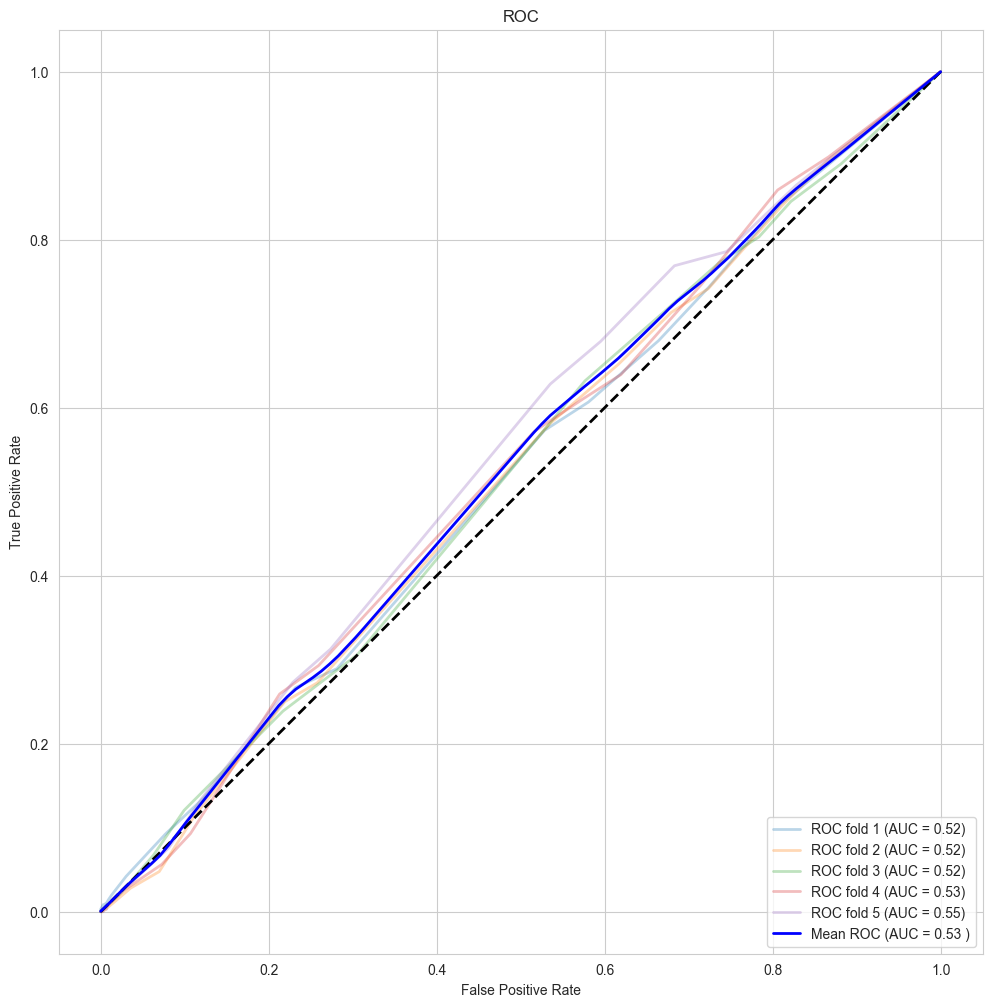

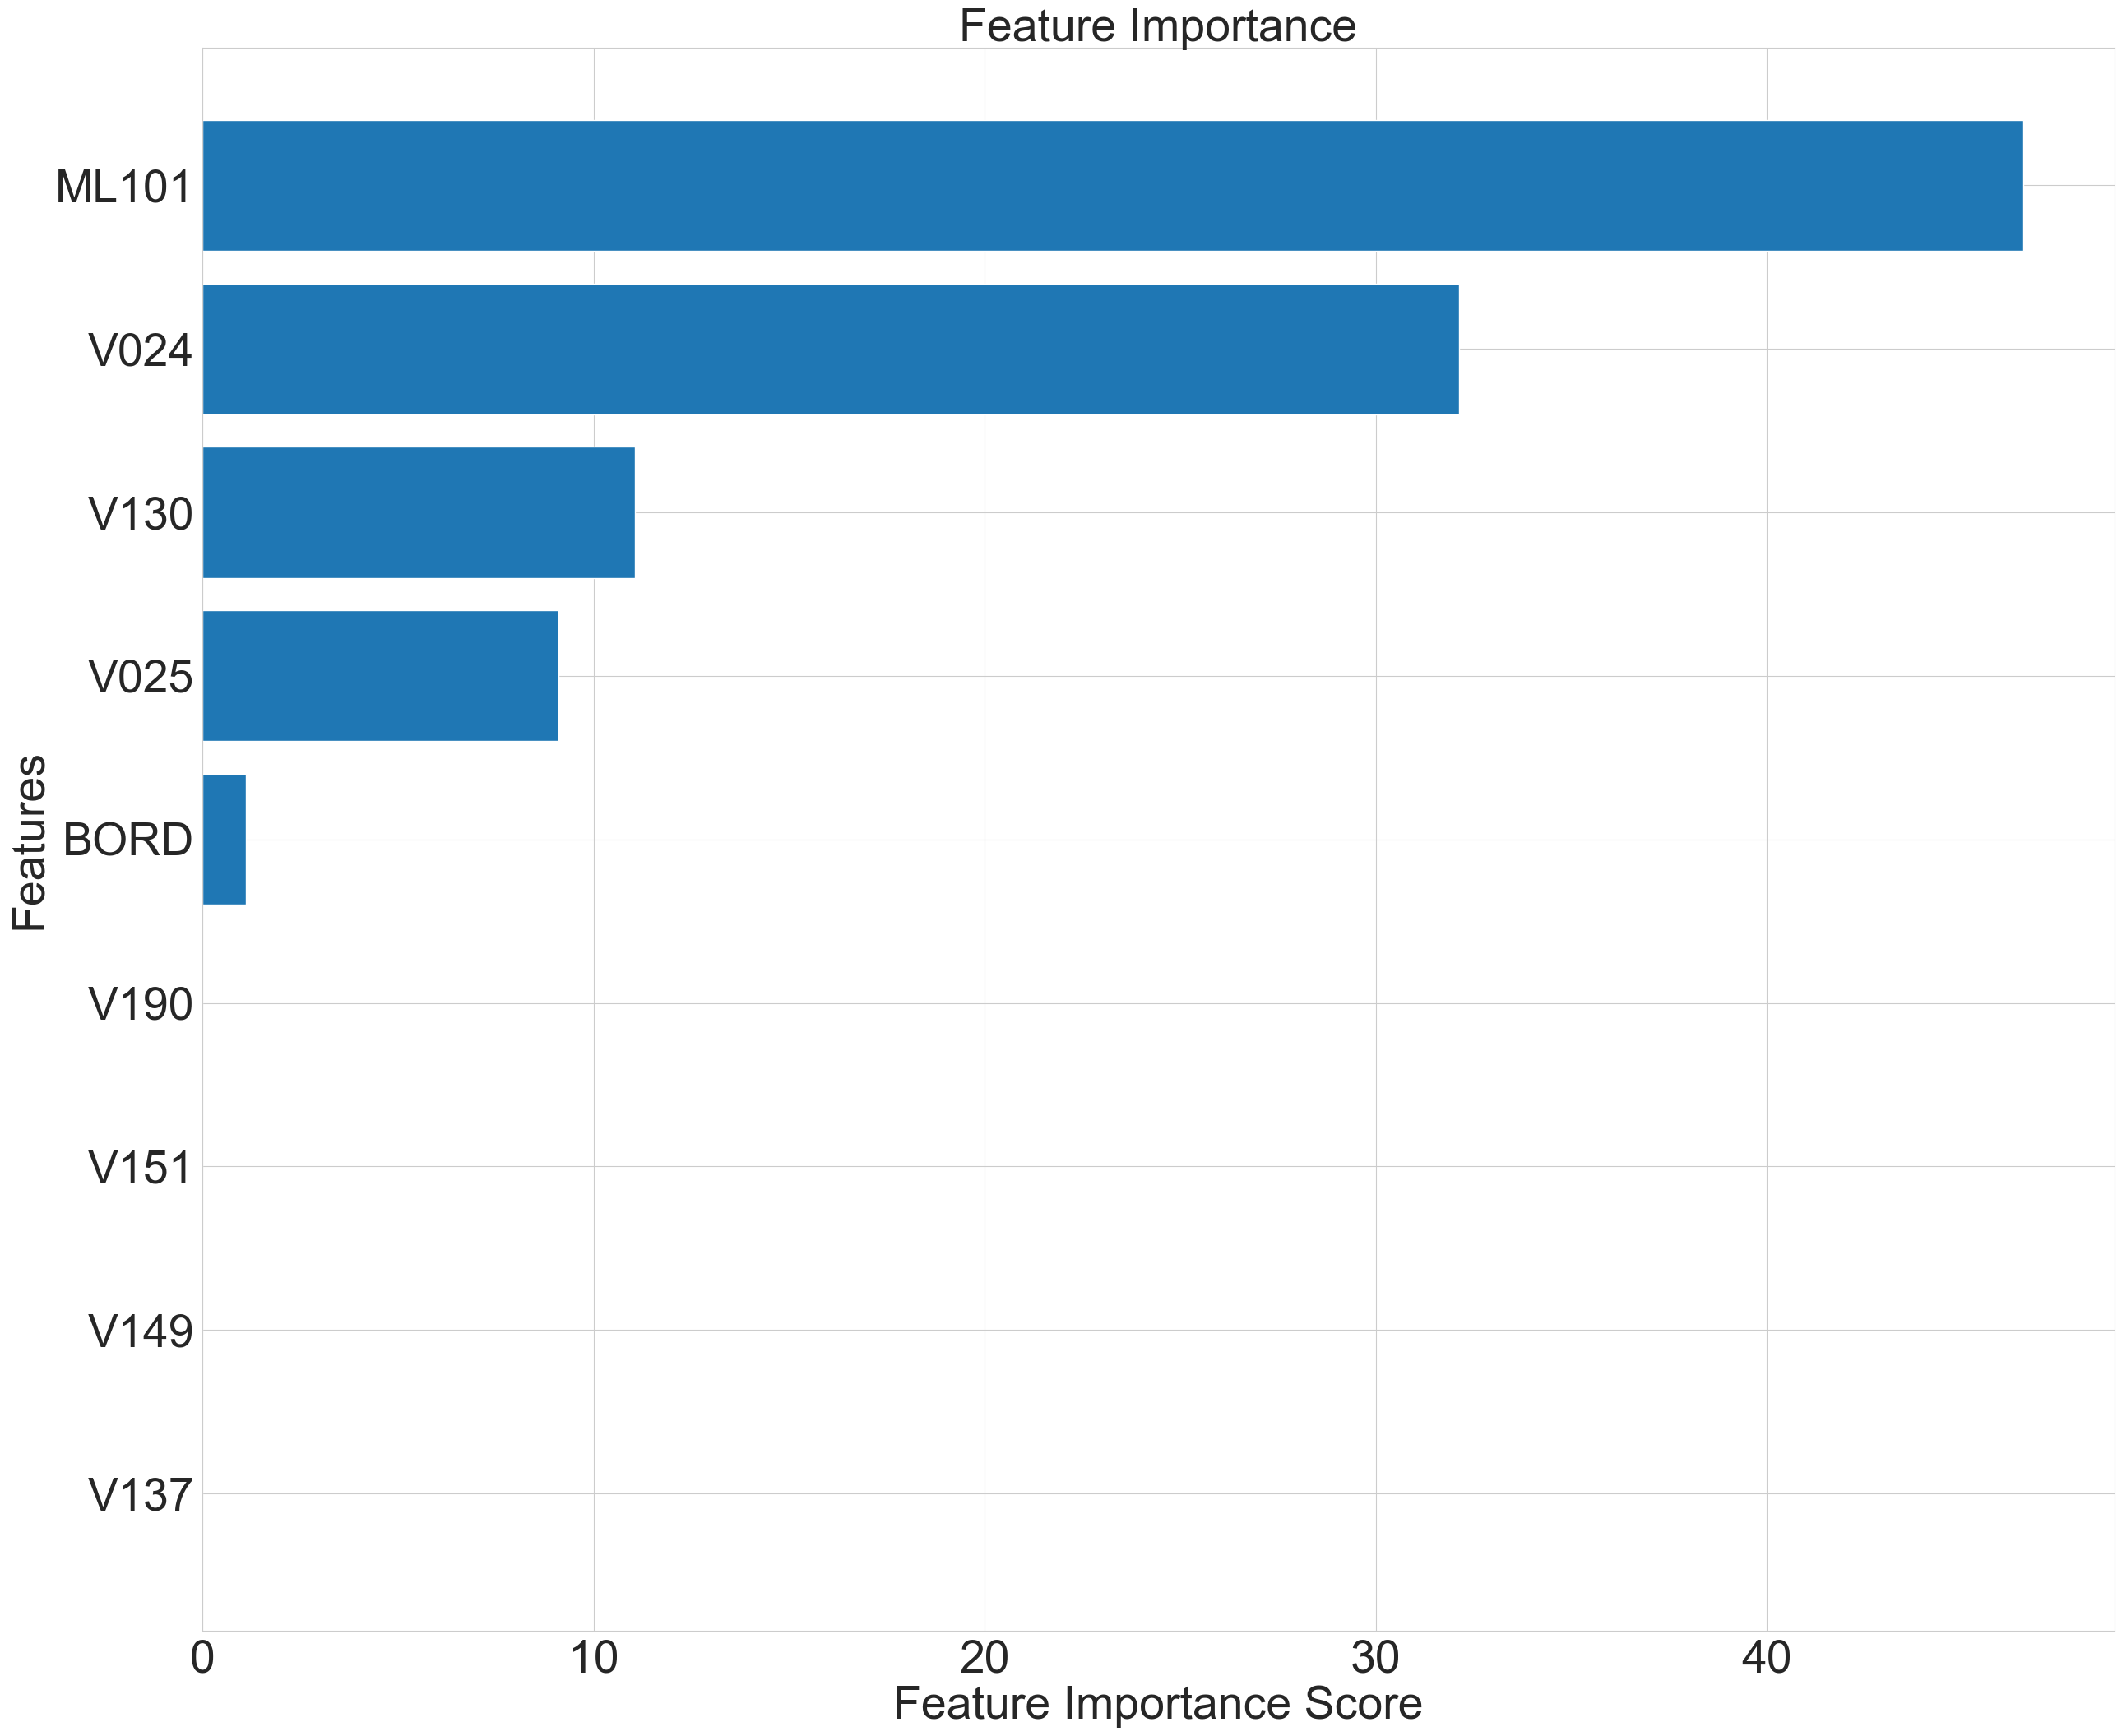

0.5373905748020731 0.5373905748020731 0.004562466471967144
================================Fold1====================================
[09:19:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "objectsve", "scoring", "sub_sample" } are not used.

[0]	validation_0-auc:0.50000
[1]	validation_0-auc:0.49535
[2]	validation_0-auc:0.57016
[3]	validation_0-auc:0.58052
[4]	validation_0-auc:0.58937
[5]	validation_0-auc:0.59106
[6]	validation_0-auc:0.59017
[7]	validation_0-auc:0.59114
[8]	validation_0-auc:0.59312
[9]	validation_0-auc:0.59396
[10]	validation_0-auc:0.59409
[11]	validation_0-auc:0.59631
[12]	validation_0-auc:0.59528
[13]	validation_0-auc:0.59287
[14]	validation_0-auc:0.59306
[15]	validation_0-auc:0.59365
[16]	validation_0-auc:0.59423
[17]	validation_0-auc:0.59483
[18]	validation_0-auc:0.59488
[19]	validation_0-auc:0.59492
[20]	validation_0-auc:0.59301
[21]	validation_0-auc:0.59201
[22]	valid

/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/var/folders/xm/rq0m1_2936361j6vzf

[15]	validation_0-auc:0.57779
[16]	validation_0-auc:0.57454
[17]	validation_0-auc:0.57463
[18]	validation_0-auc:0.57609
[19]	validation_0-auc:0.57661
[20]	validation_0-auc:0.57749
[21]	validation_0-auc:0.57719
[22]	validation_0-auc:0.57894
[23]	validation_0-auc:0.57974
[24]	validation_0-auc:0.57944
[25]	validation_0-auc:0.57832
[26]	validation_0-auc:0.57908
[27]	validation_0-auc:0.57645
[28]	validation_0-auc:0.57603
[29]	validation_0-auc:0.57587
[30]	validation_0-auc:0.57697
[31]	validation_0-auc:0.57529
[32]	validation_0-auc:0.57605
[33]	validation_0-auc:0.57722
[34]	validation_0-auc:0.57655
[35]	validation_0-auc:0.57351
[36]	validation_0-auc:0.57240
[37]	validation_0-auc:0.57119
[38]	validation_0-auc:0.57091
[39]	validation_0-auc:0.57128
[40]	validation_0-auc:0.57197
[41]	validation_0-auc:0.57175
[42]	validation_0-auc:0.57031
[43]	validation_0-auc:0.57066

Validation scores 0.5811348399792149 0.5112437257161653
Training scores 0.6539161850674239 0.4965839035938429
===================

/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:8

[40]	validation_0-auc:0.61311
[41]	validation_0-auc:0.61272
[42]	validation_0-auc:0.61136
[43]	validation_0-auc:0.61030
[44]	validation_0-auc:0.60976
[45]	validation_0-auc:0.60966
[46]	validation_0-auc:0.60877
[47]	validation_0-auc:0.60987
[48]	validation_0-auc:0.60971
[49]	validation_0-auc:0.61074
[50]	validation_0-auc:0.61055
[51]	validation_0-auc:0.60848
[52]	validation_0-auc:0.60867
[53]	validation_0-auc:0.60977
[54]	validation_0-auc:0.61010
[55]	validation_0-auc:0.61010
[56]	validation_0-auc:0.61141
[57]	validation_0-auc:0.61144
[58]	validation_0-auc:0.61124
[59]	validation_0-auc:0.60954
[60]	validation_0-auc:0.60933
[61]	validation_0-auc:0.61033
[62]	validation_0-auc:0.60974

Validation scores 0.6166077587587694 0.5031731963388957
Training scores 0.687333149044306 0.4870240878767562
================================Fold5====================================
[09:19:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/lear

/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:8

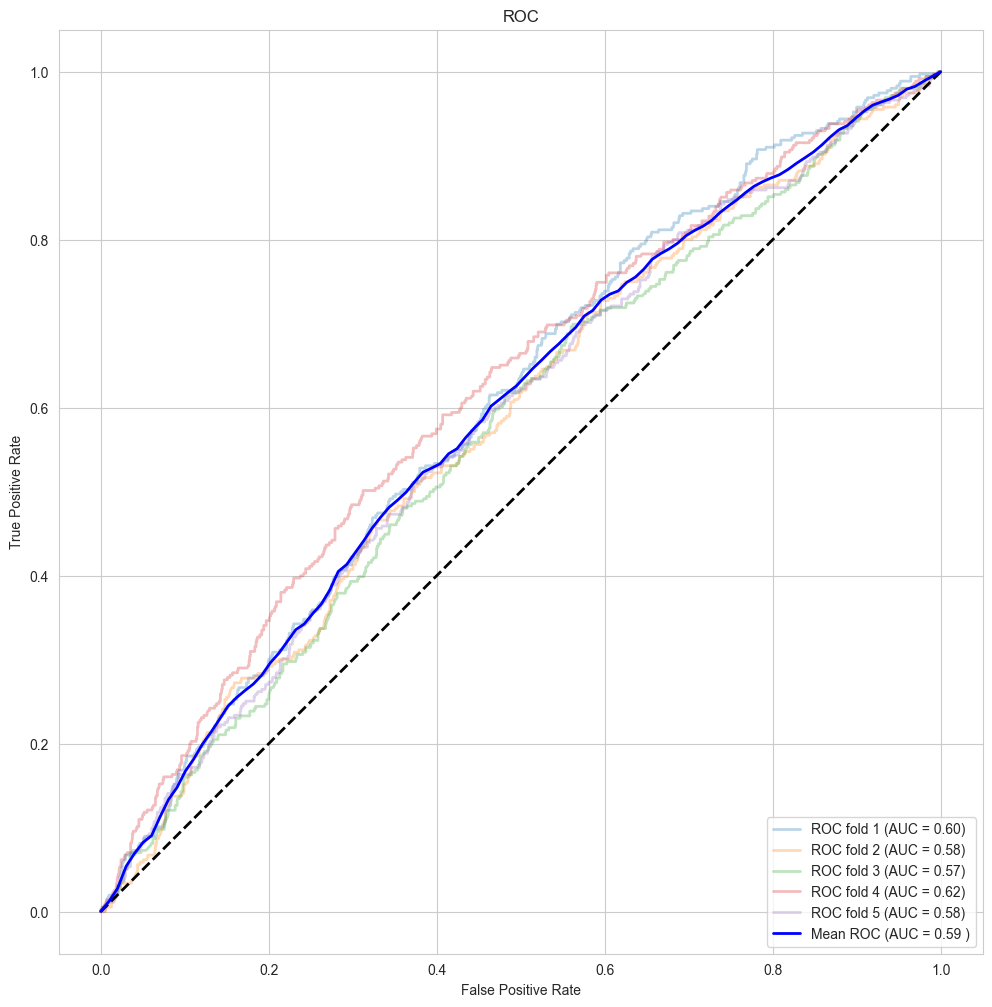

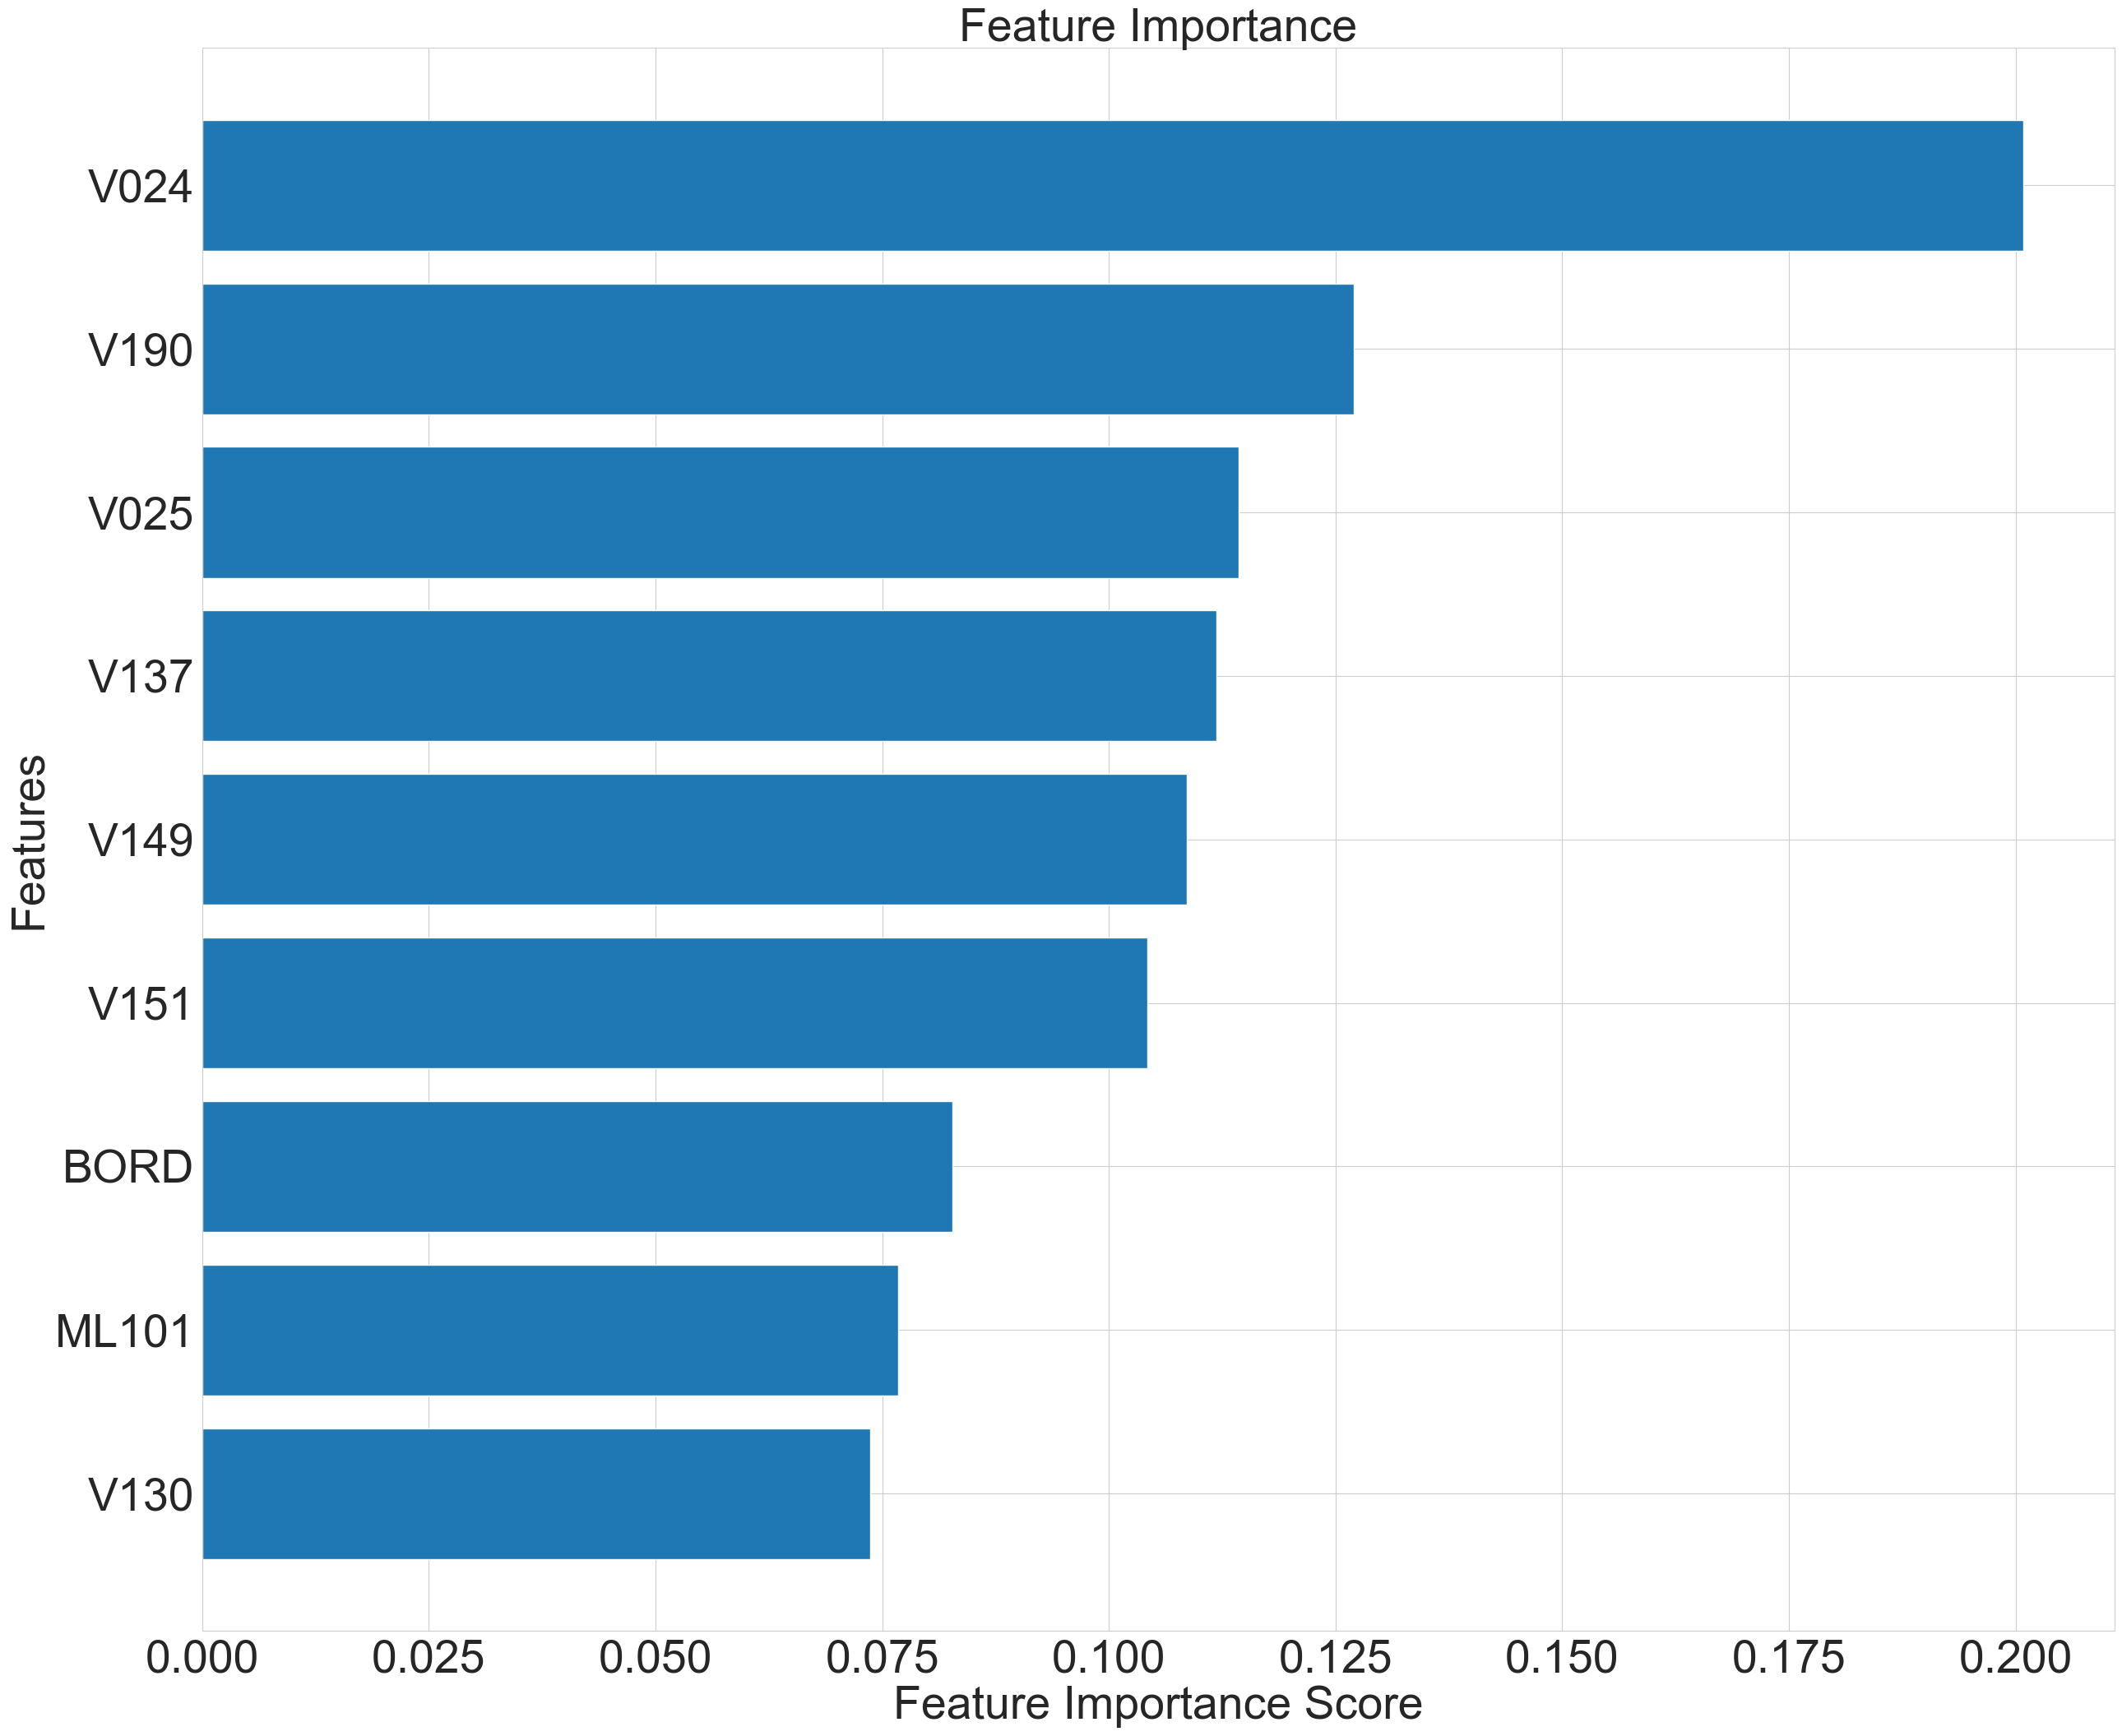

0.6811090954393795 0.6811090954393795 0.01816258664086279
================================Fold1====================================

Validation scores 0.5681919823495838 0.7291012399558873
Training scores 0.9912749548396558 0.17919755506880447
================================Fold2====================================


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))



Validation scores 0.549339387176189 0.8266737078317397
Training scores 0.9916527019550596 0.17769218089897812
================================Fold3====================================


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))



Validation scores 0.5484177592879917 0.6824740537269478
Training scores 0.9916330244218172 0.1780558175216496
================================Fold4====================================


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))



Validation scores 0.5848434046279191 0.6849337742348179
Training scores 0.9916776185416966 0.17794839242909571
================================Fold5====================================


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))



Validation scores 0.5511708614080236 0.8122221082486869
Training scores 0.9923124165287274 0.17626224752672562


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


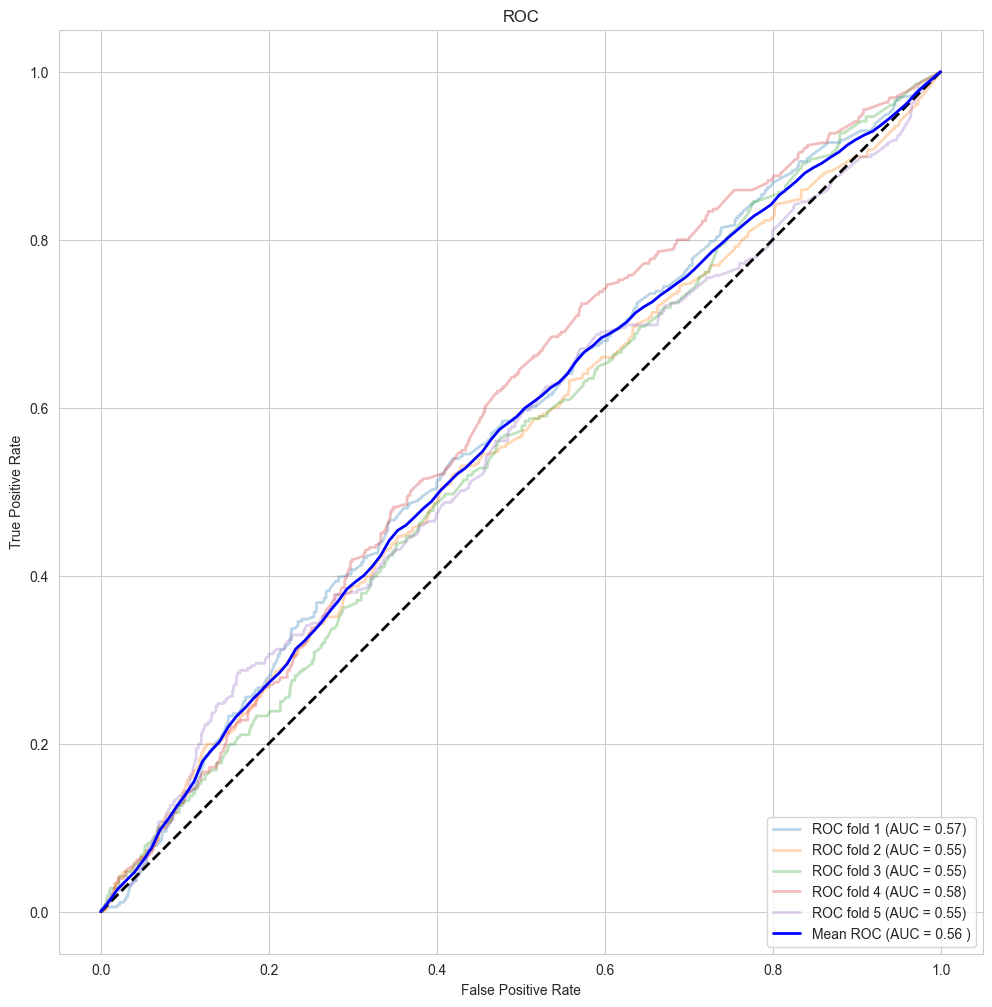

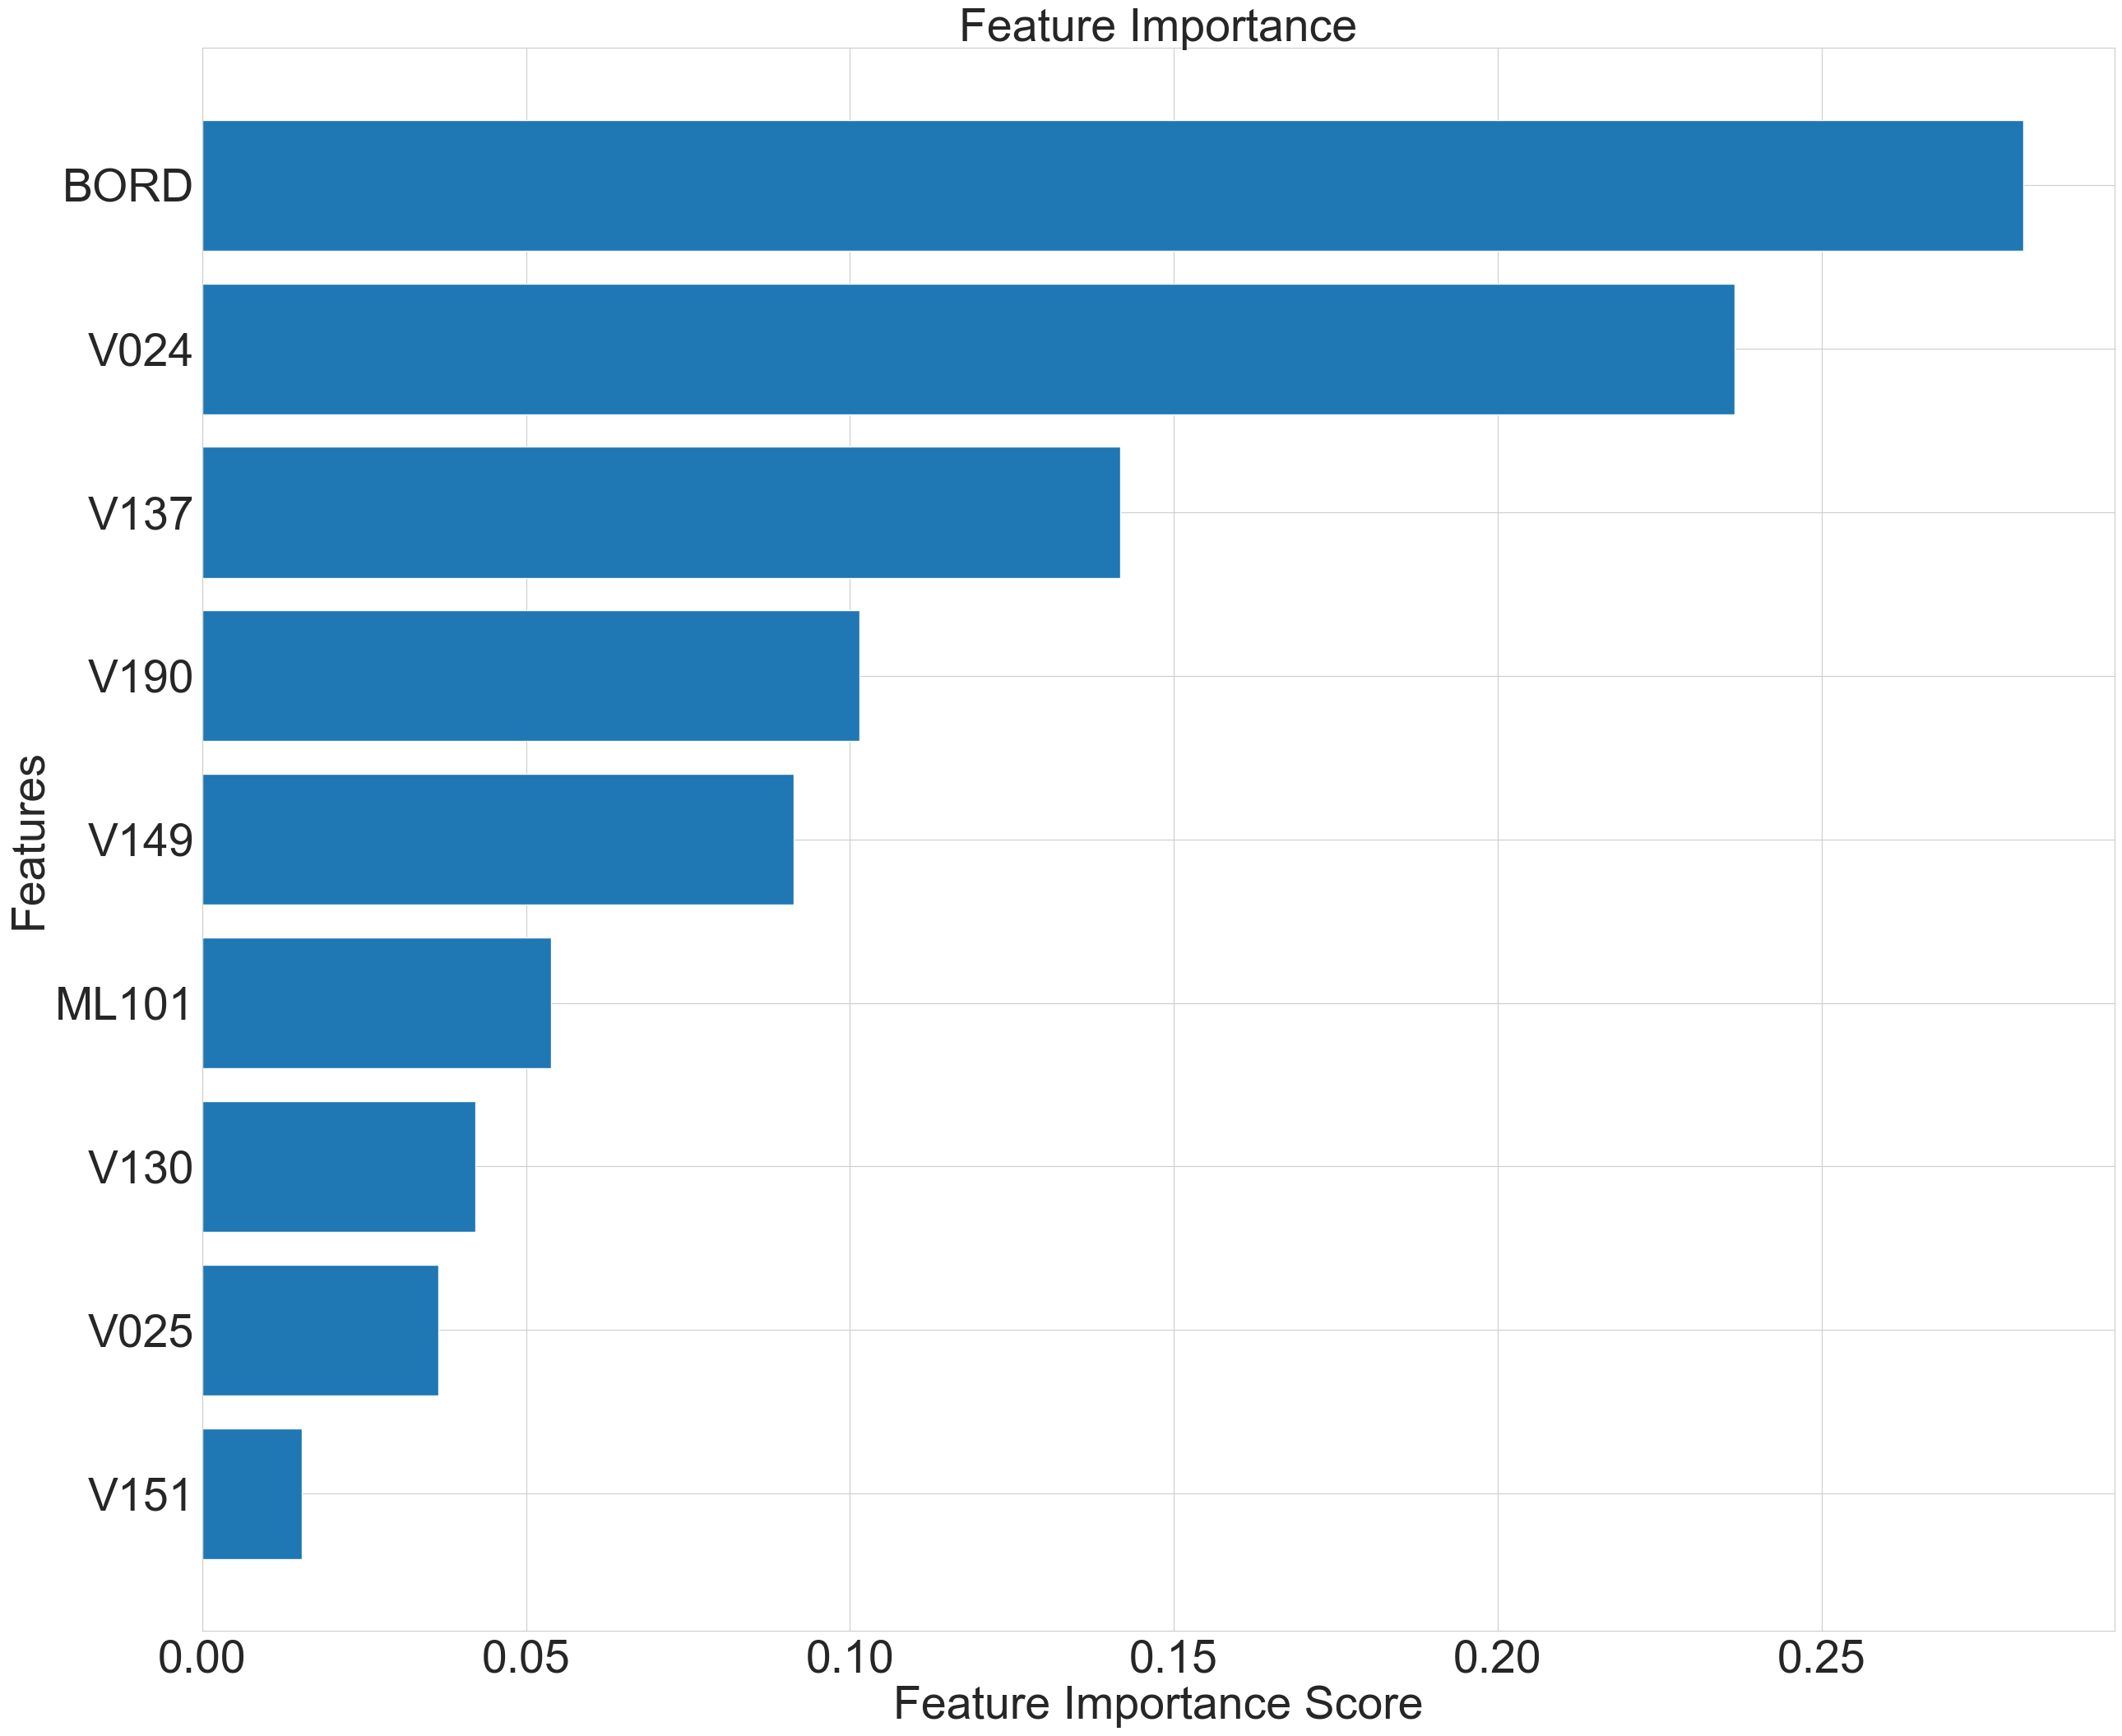

0.9917101432573914 0.9917101432573914 0.00033538835025739546
================================Fold1====================================

Validation scores 0.5722862059272006 0.5112221253574174
Training scores 0.5637148799168116 0.5121449091381877
================================Fold2====================================

Validation scores 0.549430961487678 0.5147001535066772
Training scores 0.5671605975163477 0.511527516337489
================================Fold3====================================

Validation scores 0.5510732979829841 0.5147322836596601
Training scores 0.5690359790746303 0.5112604325349936
================================Fold4====================================

Validation scores 0.5836549242383795 0.509314118655135
Training scores 0.5624516657618741 0.5126066112644999
================================Fold5====================================

Validation scores 0.5547950325150295 0.5130311205338619
Training scores 0.5696984209982914 0.5117016293155776


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942

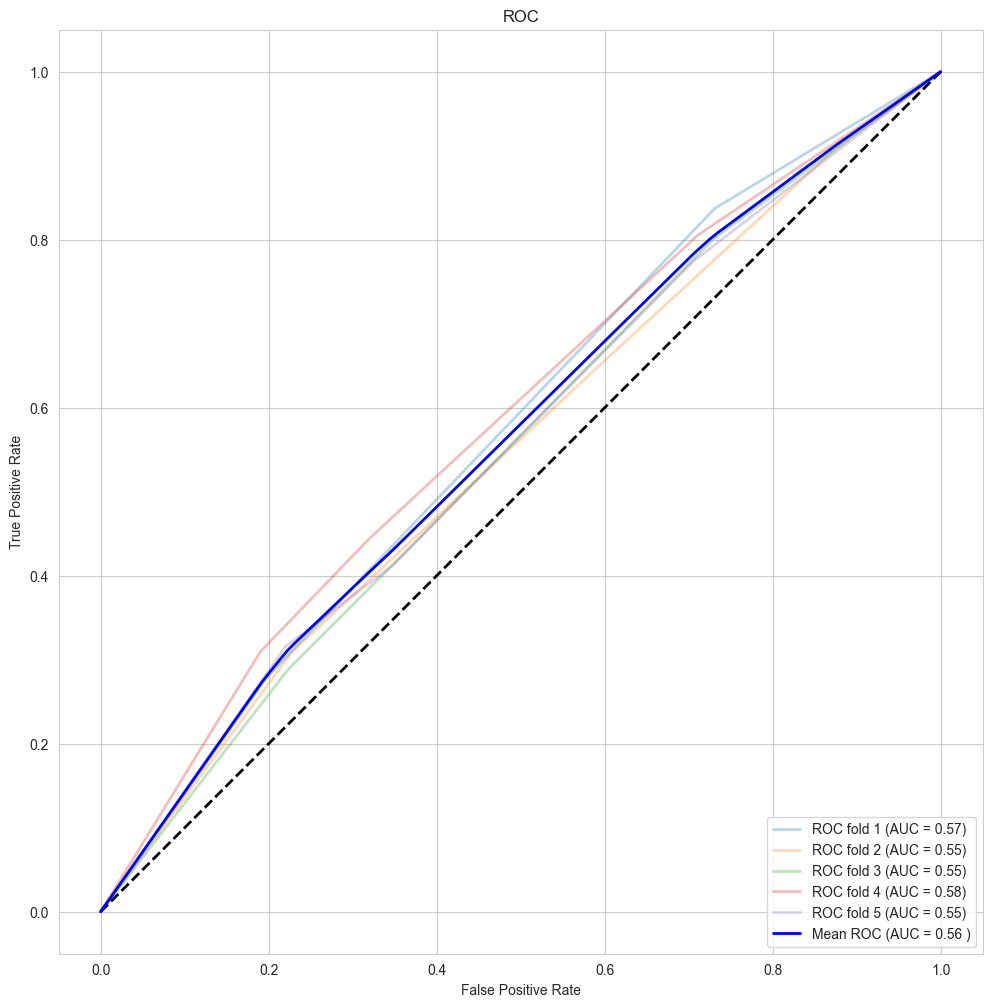

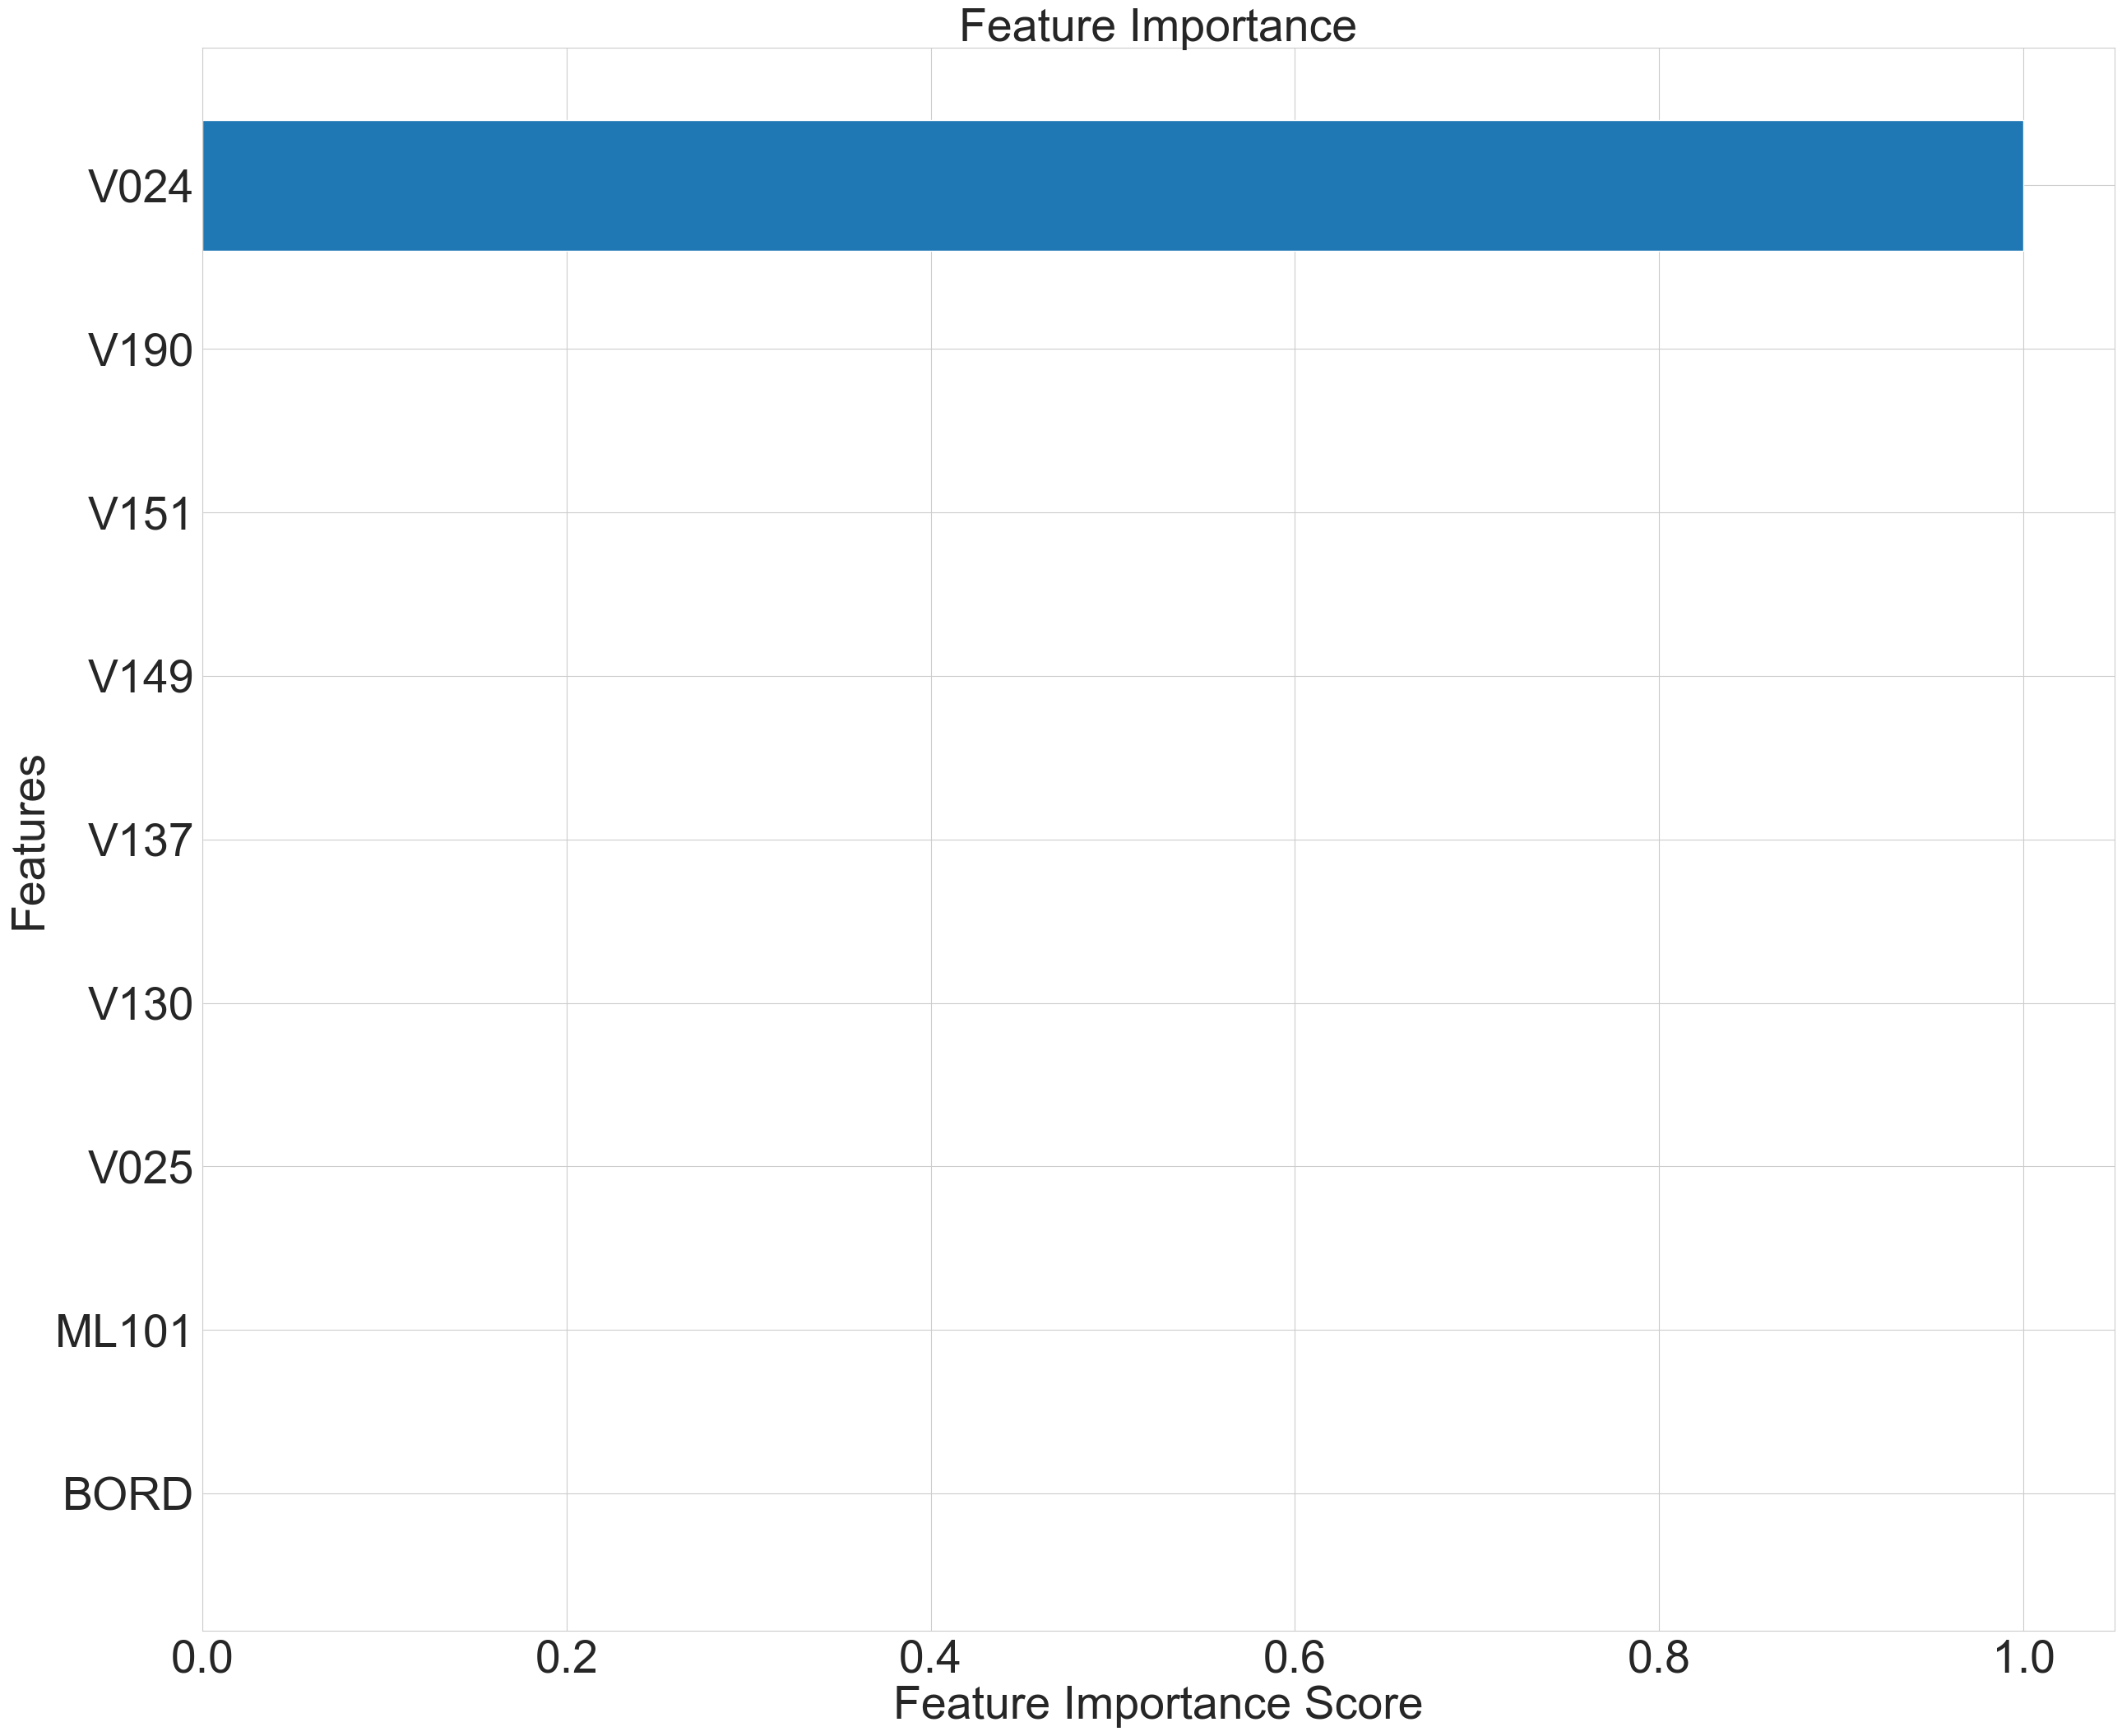

0.5664123086535909 0.5664123086535909 0.0028707117914575
================================Fold1====================================

Validation scores 0.46130985339591624 0.5210862565452956
Training scores 0.47442758013878056 0.5199566252665943
================================Fold2====================================


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))



Validation scores 0.5374570878517093 0.5167205697681757
Training scores 0.525436105611881 0.5166184805682474
================================Fold3====================================


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))



Validation scores 0.5227138070962132 0.5172464462609805
Training scores 0.5294689536995274 0.5163241694616337
================================Fold4====================================


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))



Validation scores 0.5273040822646264 0.5160142350201226
Training scores 0.5287115865619993 0.516515445213818
================================Fold5====================================


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))



Validation scores 0.5151640700915119 0.5164296331540209
Training scores 0.5315803006131495 0.5164143516506834


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


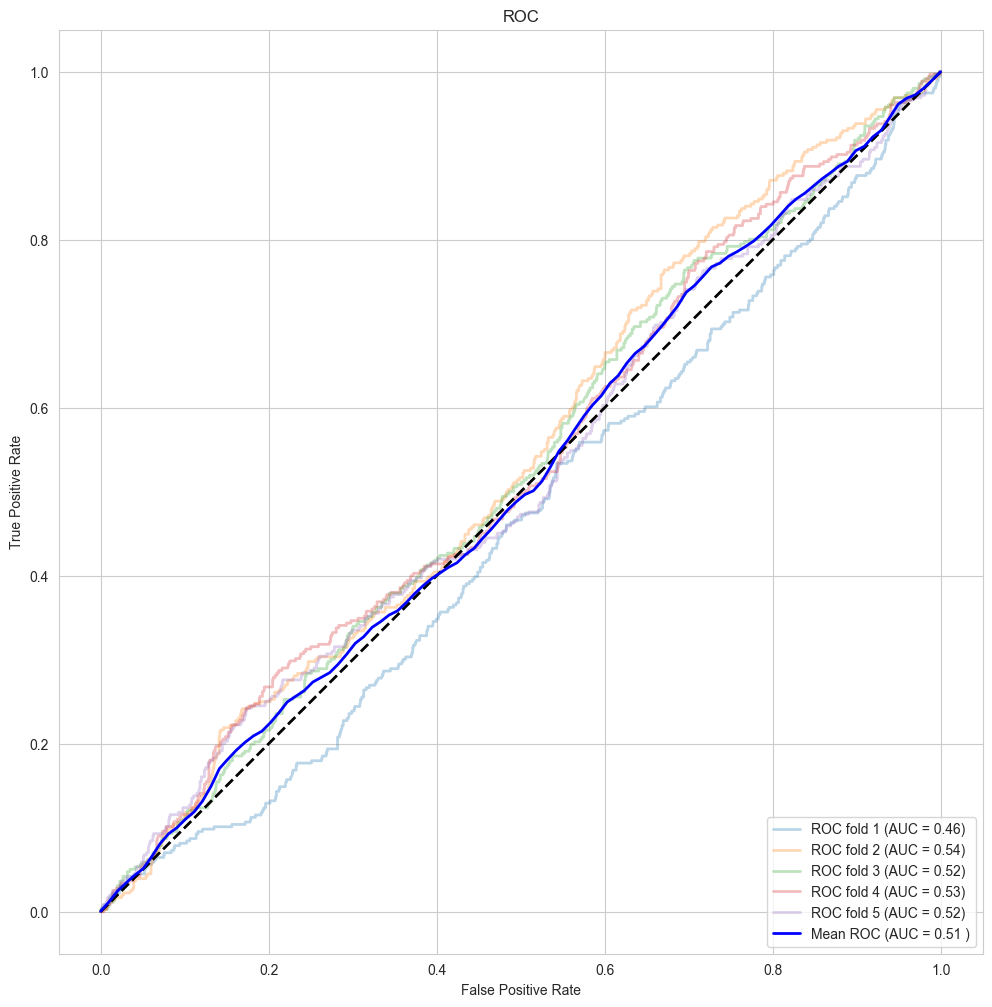

0.5179249053250675 0.5179249053250675 0.02183814458035774


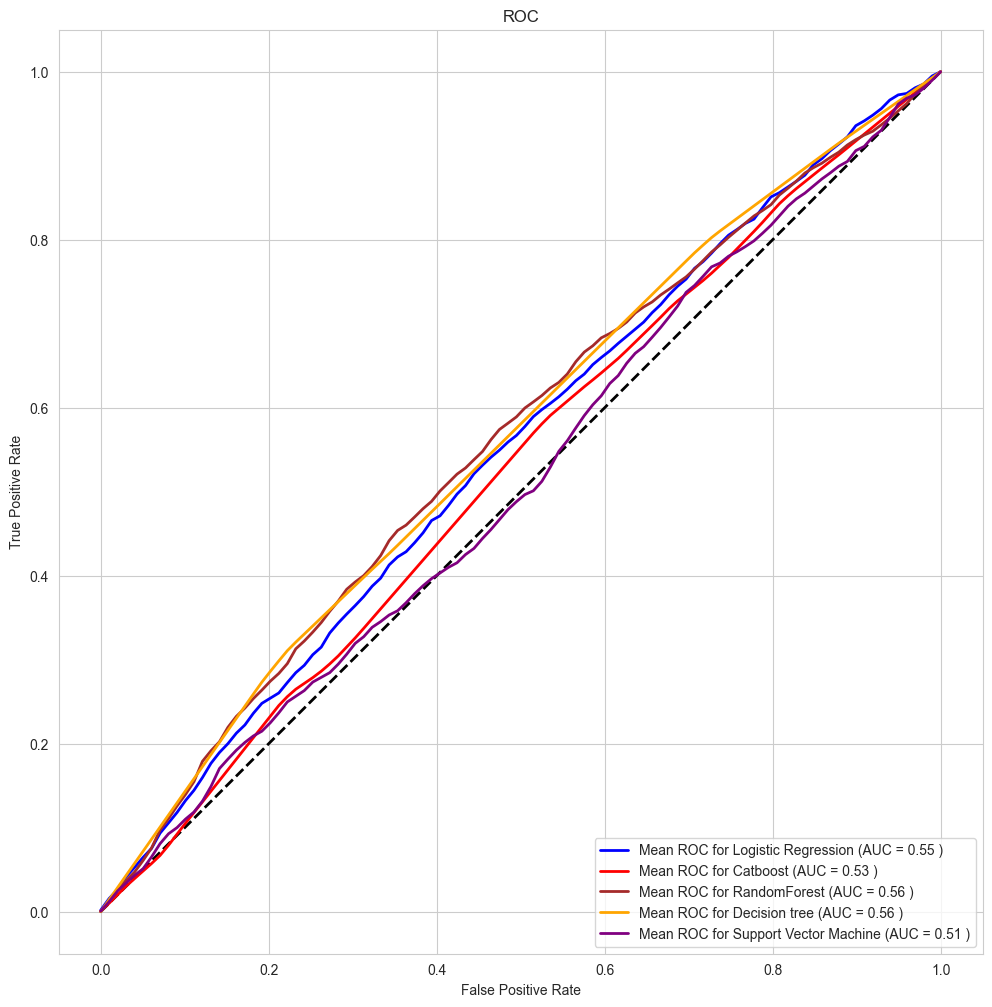

66/66 [==============================] - 0s 287us/step
3582    0
6795    0
4541    0
1542    1
2886    0
       ..
4923    0
410     0
4105    0
9432    0
6954    0
Name: HML32$01, Length: 2093, dtype: int64
Unique instance  (array([0, 1]), array([1648,  445])) (array([0]), array([2093]))
{'0': {'precision': 0.7873865265169613, 'recall': 1.0, 'f1-score': 0.8810478481689388, 'support': 1648}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 445}, 'accuracy': 0.7873865265169613, 'macro avg': {'precision': 0.39369326325848064, 'recall': 0.5, 'f1-score': 0.4405239240844694, 'support': 2093}, 'weighted avg': {'precision': 0.6199775421404453, 'recall': 0.7873865265169613, 'f1-score': 0.6937252048649838, 'support': 2093}}
Accuracy 0.7873865265169613
Precision 0.0
Recall 0.0
F1 Score 0.0
Classification Report
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      1648
           1       0.00      0.00      0.00       445

    a

/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Prec

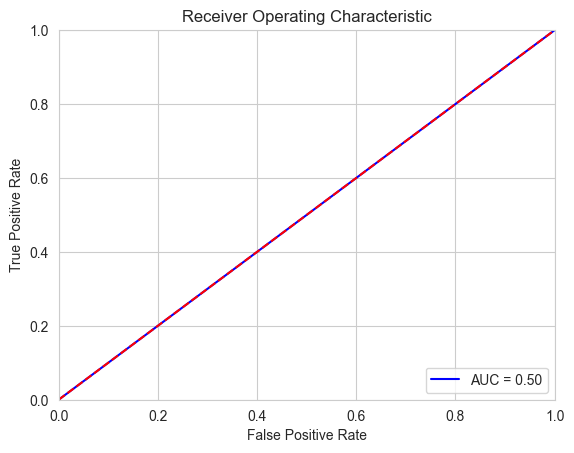

Normalized confusion matrix


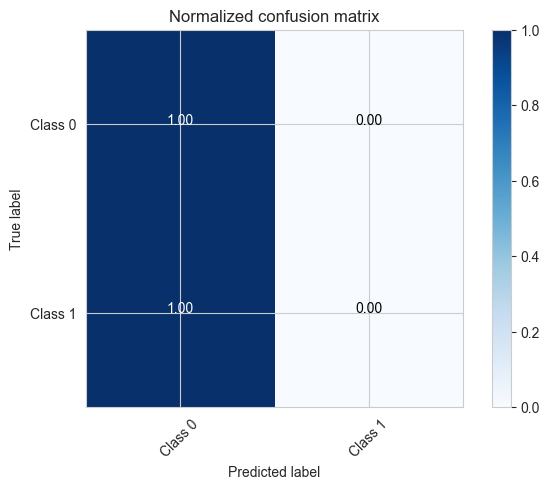

Metrics for the  Evaluation is {'accuracy': 0.7873865265169613, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
Unique instance  (array([0, 1]), array([1648,  445])) (array([0, 1]), array([2089,    4]))
{'0': {'precision': 0.7874581139301101, 'recall': 0.9981796116504854, 'f1-score': 0.8803853358308804, 'support': 1648}, '1': {'precision': 0.25, 'recall': 0.0022471910112359553, 'f1-score': 0.0044543429844098, 'support': 445}, 'accuracy': 0.7864309603440038, 'macro avg': {'precision': 0.5187290569650551, 'recall': 0.5002134013308607, 'f1-score': 0.4424198394076451, 'support': 2093}, 'weighted avg': {'precision': 0.6731872774757867, 'recall': 0.7864309603440038, 'f1-score': 0.6941506049103456, 'support': 2093}}
Accuracy 0.7864309603440038
Precision 0.25
Recall 0.0022471910112359553
F1 Score 0.0044543429844098
Classification Report
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      1648
           1       0.25      0.00      0.00       445


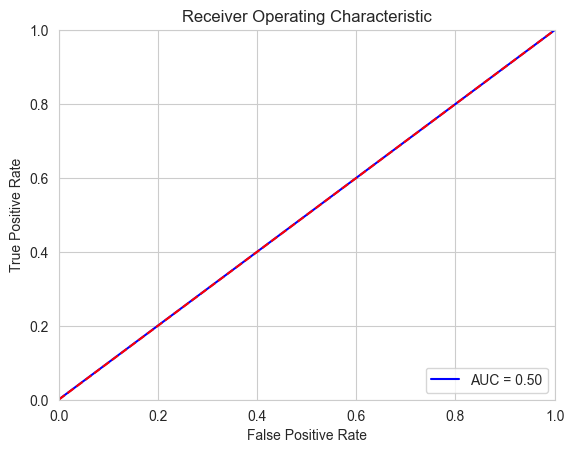

Normalized confusion matrix


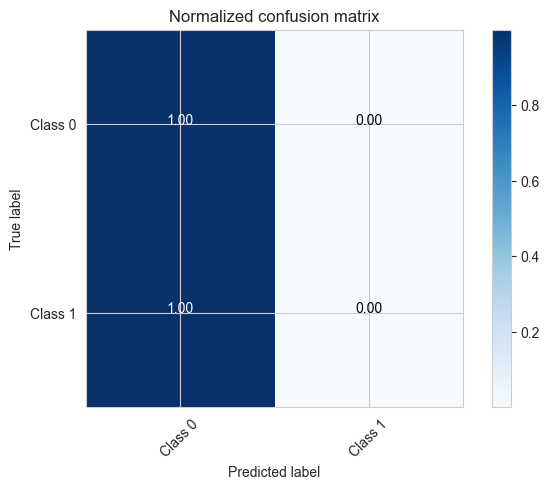

Metrics for the  Evaluation is {'accuracy': 0.7864309603440038, 'precision': 0.25, 'recall': 0.0022471910112359553, 'f1': 0.0044543429844098}
Unique instance  (array([0, 1]), array([1648,  445])) (array([0, 1]), array([2092,    1]))
{'0': {'precision': 0.7877629063097514, 'recall': 1.0, 'f1-score': 0.881283422459893, 'support': 1648}, '1': {'precision': 1.0, 'recall': 0.0022471910112359553, 'f1-score': 0.004484304932735426, 'support': 445}, 'accuracy': 0.78786430960344, 'macro avg': {'precision': 0.8938814531548758, 'recall': 0.501123595505618, 'f1-score': 0.4428838636963142, 'support': 2093}, 'weighted avg': {'precision': 0.8328873720011802, 'recall': 0.78786430960344, 'f1-score': 0.694864116535581, 'support': 2093}}
Accuracy 0.78786430960344
Precision 1.0
Recall 0.0022471910112359553
F1 Score 0.004484304932735426
Classification Report
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      1648
           1       1.00      0.00      0.0

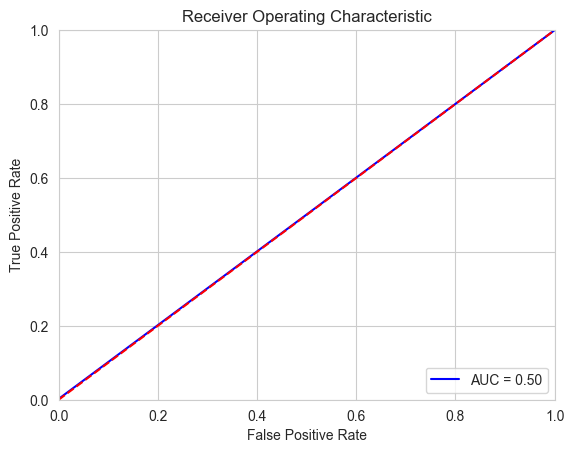

Normalized confusion matrix


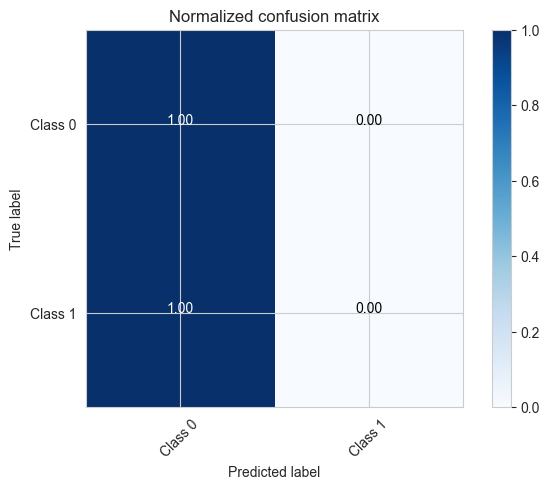

Metrics for the  Evaluation is {'accuracy': 0.78786430960344, 'precision': 1.0, 'recall': 0.0022471910112359553, 'f1': 0.004484304932735426}
Unique instance  (array([0, 1]), array([1648,  445])) (array([0]), array([2093]))
{'0': {'precision': 0.7873865265169613, 'recall': 1.0, 'f1-score': 0.8810478481689388, 'support': 1648}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 445}, 'accuracy': 0.7873865265169613, 'macro avg': {'precision': 0.39369326325848064, 'recall': 0.5, 'f1-score': 0.4405239240844694, 'support': 2093}, 'weighted avg': {'precision': 0.6199775421404453, 'recall': 0.7873865265169613, 'f1-score': 0.6937252048649838, 'support': 2093}}
Accuracy 0.7873865265169613
Precision 0.0
Recall 0.0
F1 Score 0.0
Classification Report
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      1648
           1       0.00      0.00      0.00       445

    accuracy                           0.79      2093
   macro avg      

/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Prec

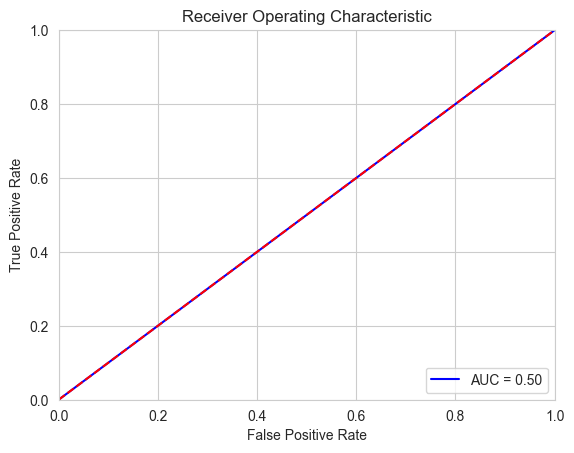

Normalized confusion matrix


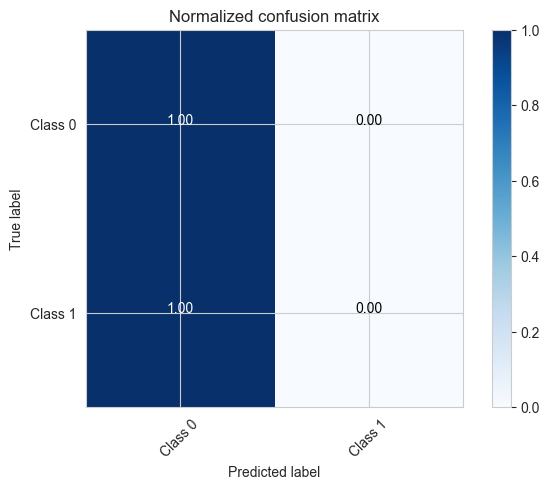

Metrics for the  Evaluation is {'accuracy': 0.7873865265169613, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
Unique instance  (array([0, 1]), array([1648,  445])) (array([0, 1]), array([1896,  197]))
{'0': {'precision': 0.7958860759493671, 'recall': 0.9156553398058253, 'f1-score': 0.8515801354401806, 'support': 1648}, '1': {'precision': 0.29441624365482233, 'recall': 0.1303370786516854, 'f1-score': 0.1806853582554517, 'support': 445}, 'accuracy': 0.7486860965121834, 'macro avg': {'precision': 0.5451511598020947, 'recall': 0.5229962092287553, 'f1-score': 0.5161327468478162, 'support': 2093}, 'weighted avg': {'precision': 0.689266833058267, 'recall': 0.7486860965121834, 'f1-score': 0.7089388665213062, 'support': 2093}}
Accuracy 0.7486860965121834
Precision 0.29441624365482233
Recall 0.1303370786516854
F1 Score 0.1806853582554517
Classification Report
              precision    recall  f1-score   support

           0       0.80      0.92      0.85      1648
           1       0.29      0.

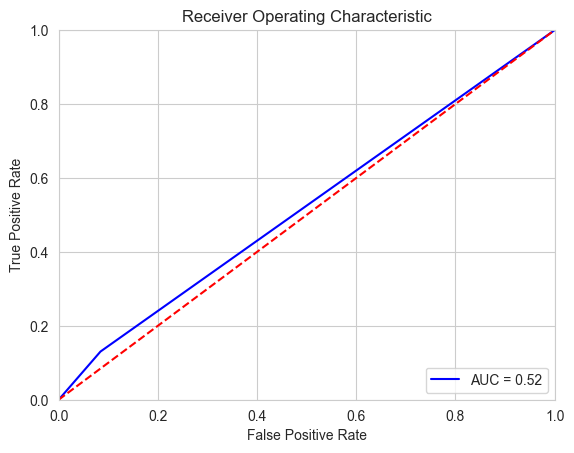

Normalized confusion matrix


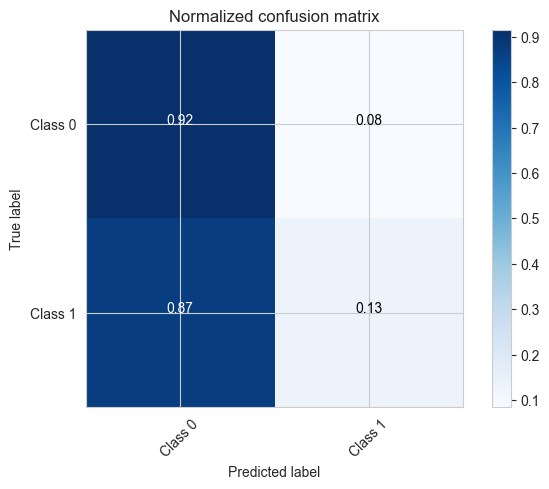

Metrics for the  Evaluation is {'accuracy': 0.7486860965121834, 'precision': 0.29441624365482233, 'recall': 0.1303370786516854, 'f1': 0.1806853582554517}
Unique instance  (array([0, 1]), array([1648,  445])) (array([0]), array([2093]))
{'0': {'precision': 0.7873865265169613, 'recall': 1.0, 'f1-score': 0.8810478481689388, 'support': 1648}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 445}, 'accuracy': 0.7873865265169613, 'macro avg': {'precision': 0.39369326325848064, 'recall': 0.5, 'f1-score': 0.4405239240844694, 'support': 2093}, 'weighted avg': {'precision': 0.6199775421404453, 'recall': 0.7873865265169613, 'f1-score': 0.6937252048649838, 'support': 2093}}
Accuracy 0.7873865265169613
Precision 0.0
Recall 0.0
F1 Score 0.0
Classification Report
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      1648
           1       0.00      0.00      0.00       445

    accuracy                           0.79      2093
   ma

/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Prec

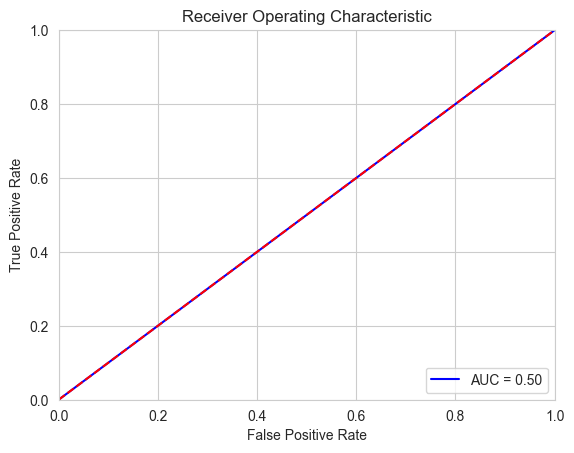

Normalized confusion matrix


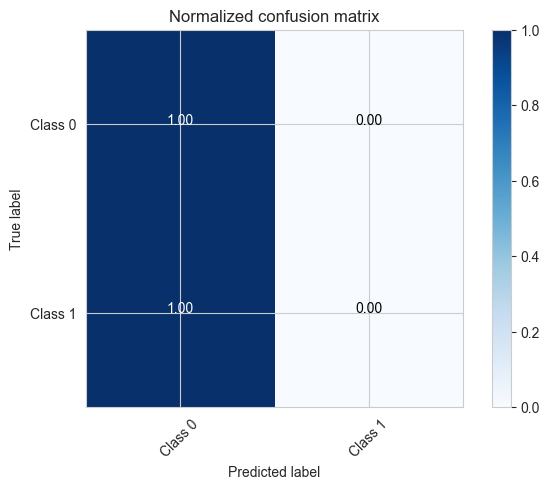

Metrics for the  Evaluation is {'accuracy': 0.7873865265169613, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
Unique instance  (array([0, 1]), array([1648,  445])) (array([0, 1]), array([1644,  449]))
{'0': {'precision': 0.7852798053527981, 'recall': 0.783373786407767, 'f1-score': 0.784325637910085, 'support': 1648}, '1': {'precision': 0.20489977728285078, 'recall': 0.20674157303370785, 'f1-score': 0.20581655480984337, 'support': 445}, 'accuracy': 0.6607740086000956, 'macro avg': {'precision': 0.49508979131782443, 'recall': 0.49505767972073744, 'f1-score': 0.4950710963599642, 'support': 2093}, 'weighted avg': {'precision': 0.661883191644663, 'recall': 0.6607740086000956, 'f1-score': 0.6613268123106548, 'support': 2093}}
Accuracy 0.6607740086000956
Precision 0.20489977728285078
Recall 0.20674157303370785
F1 Score 0.20581655480984337
Classification Report
              precision    recall  f1-score   support

           0       0.79      0.78      0.78      1648
           1       0.20    

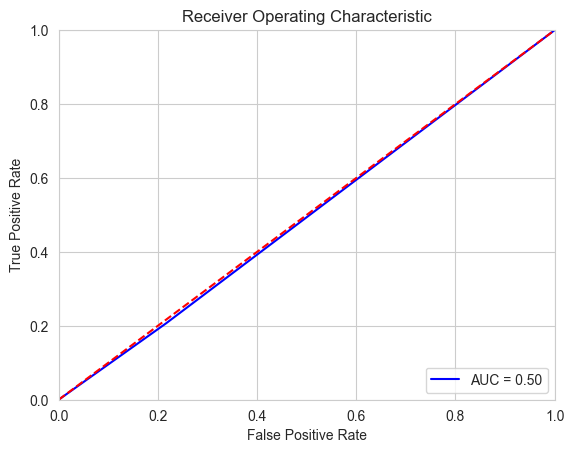

Normalized confusion matrix


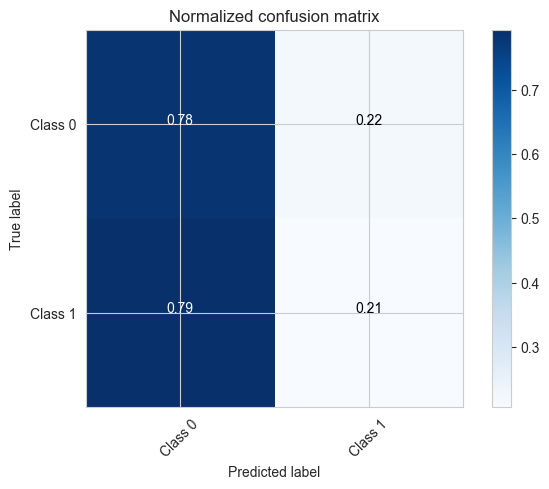

Metrics for the  Evaluation is {'accuracy': 0.6607740086000956, 'precision': 0.20489977728285078, 'recall': 0.20674157303370785, 'f1': 0.20581655480984337}
{'catboost_result': {'accuracy': 0.7864309603440038, 'precision': 0.25, 'recall': 0.0022471910112359553, 'f1': 0.0044543429844098}, 'xgb': {'accuracy': 0.78786430960344, 'precision': 1.0, 'recall': 0.0022471910112359553, 'f1': 0.004484304932735426}, 'log': {'accuracy': 0.7873865265169613, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'neural': {'accuracy': 0.7873865265169613, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'radom_forest': {'accuracy': 0.7486860965121834, 'precision': 0.29441624365482233, 'recall': 0.1303370786516854, 'f1': 0.1806853582554517}, 'svm': {'accuracy': 0.6607740086000956, 'precision': 0.20489977728285078, 'recall': 0.20674157303370785, 'f1': 0.20581655480984337}, 'decision_tree': {'accuracy': 0.7873865265169613, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}}


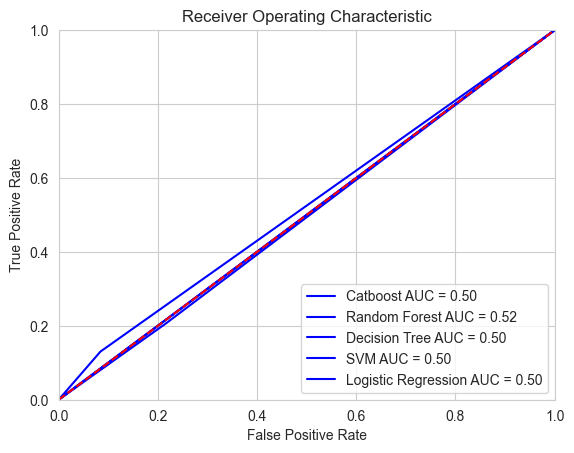

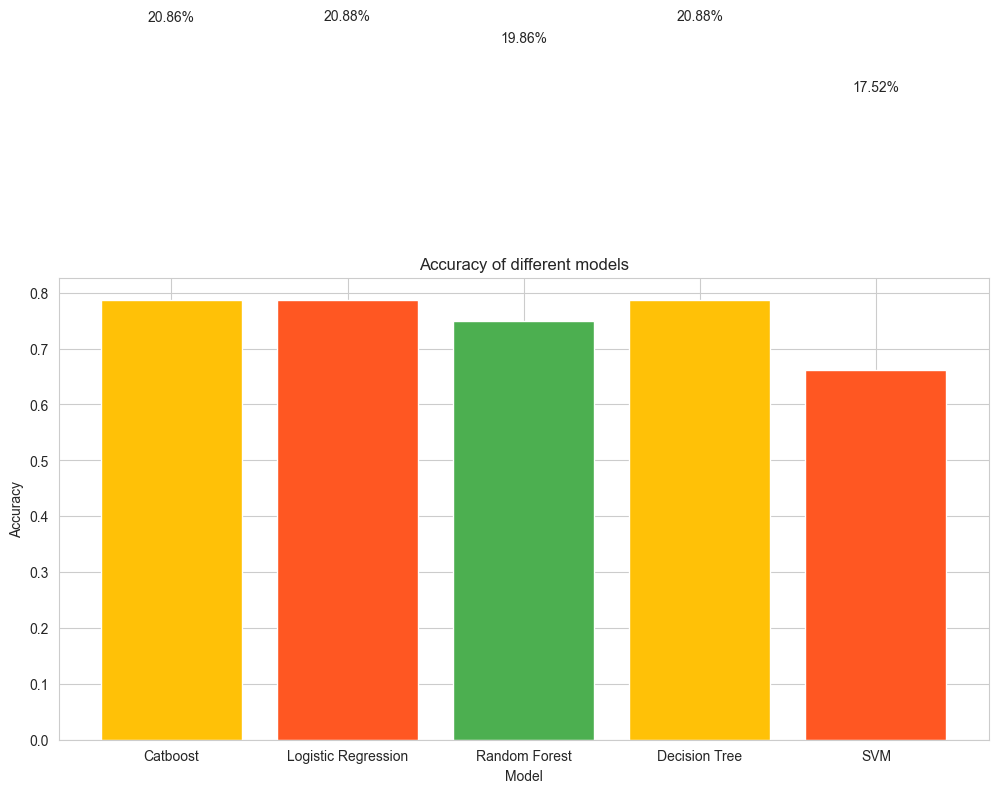

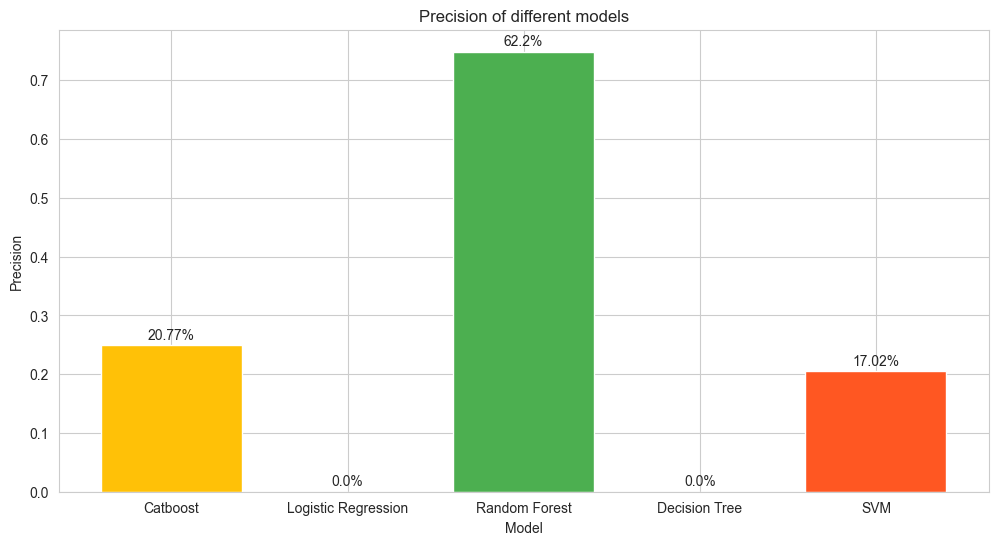

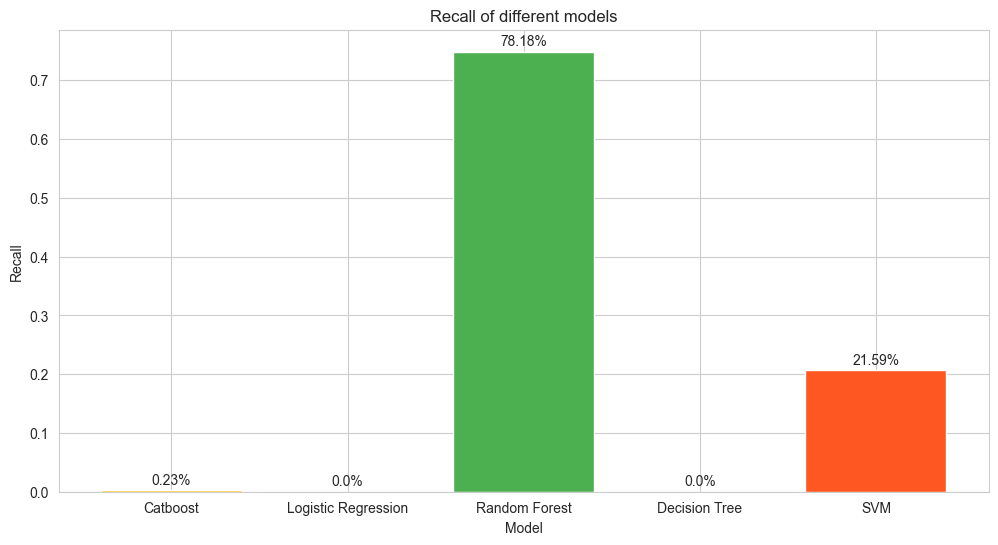

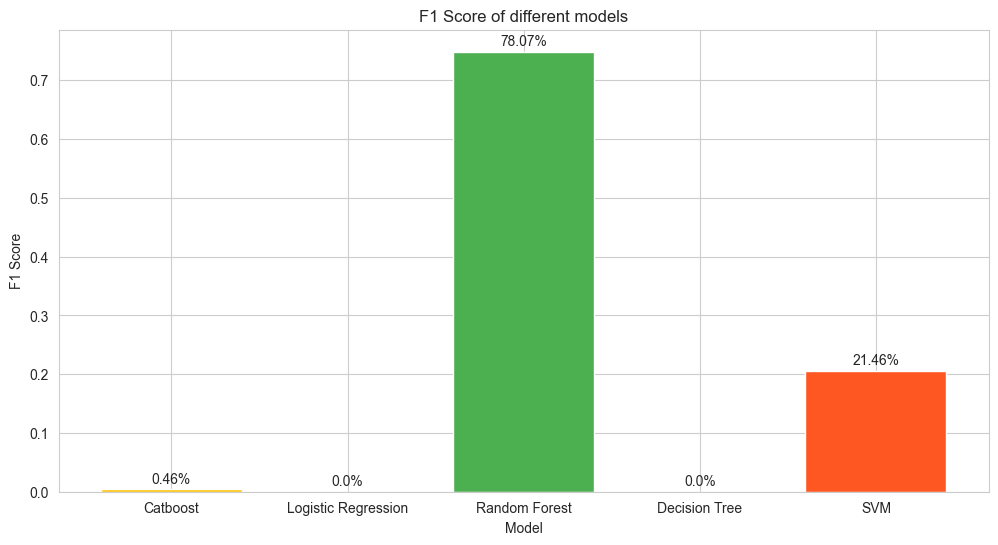

In [69]:
# Results  cross validation
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42, stratify=Y_data)
with_cross_classifier,with_cross_catboost,with_cross_xgboost, with_cross_rad, with_cross_deci, with_cross_svm = run_predictions(X_train,y_train, X_test)
with_cross_neural_result = train_neural(X_train,y_train,X_test, y_test)
eveluate_model_results(with_cross_catboost,with_cross_xgboost, with_cross_classifier, with_out_cross_rad, with_cross_deci, with_cross_svm,with_cross_neural_result, y_test, X_test)

================================Fold1====================================

Validation scores 0.5573311506580502 0.6888275443374443
Training scores 0.5601084457959731 0.6877026209112219
================================Fold2====================================

Validation scores 0.5596291674546101 0.6883719754508995
Training scores 0.5588984142902588 0.6878115379735598
================================Fold3====================================

Validation scores 0.5371545326217384 0.6926820977803458
Training scores 0.5648262371402704 0.6867912180253072
================================Fold4====================================


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))



Validation scores 0.5738267368137677 0.6850639787817683
Training scores 0.5551134251252218 0.6886875114137346
================================Fold5====================================

Validation scores 0.5537233914044875 0.6879827928780645
Training scores 0.5601190449450821 0.6879226412566795


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


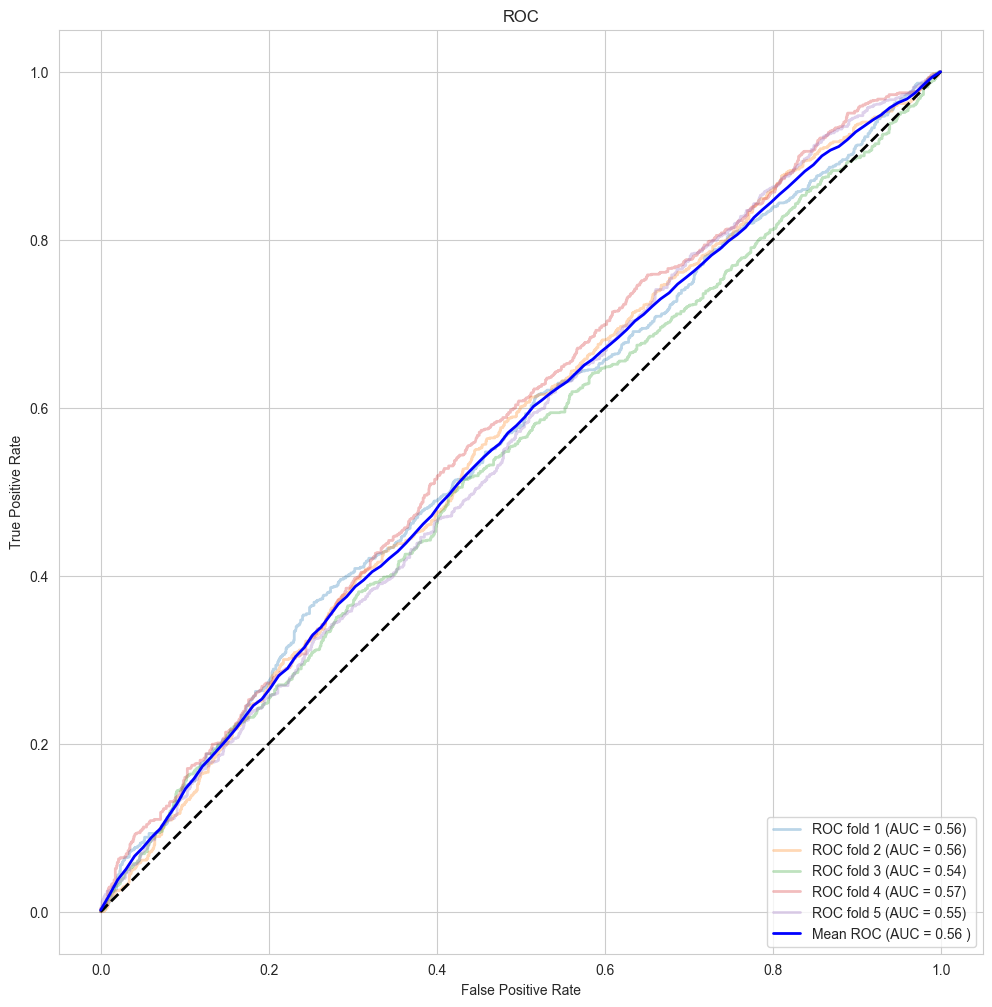

0.5598131134593612 0.5598131134593612 0.00310599321670538
================================Fold1====================================
0:	learn: 0.5595022	test: 0.5540003	best: 0.5540003 (0)	total: 3.21ms	remaining: 32.1s
50:	learn: 0.5898179	test: 0.5720227	best: 0.5731593 (47)	total: 127ms	remaining: 24.7s
100:	learn: 0.5975847	test: 0.5750246	best: 0.5795738 (94)	total: 235ms	remaining: 23s
150:	learn: 0.6013745	test: 0.5784567	best: 0.5817888 (125)	total: 343ms	remaining: 22.4s
200:	learn: 0.6100986	test: 0.5924516	best: 0.5924516 (200)	total: 441ms	remaining: 21.5s
250:	learn: 0.6138940	test: 0.5898123	best: 0.5928451 (203)	total: 555ms	remaining: 21.6s
300:	learn: 0.6215668	test: 0.5954711	best: 0.5958725 (276)	total: 670ms	remaining: 21.6s
350:	learn: 0.6284918	test: 0.6030303	best: 0.6049036 (347)	total: 779ms	remaining: 21.4s
400:	learn: 0.6333302	test: 0.5977708	best: 0.6049036 (347)	total: 871ms	remaining: 20.8s
450:	learn: 0.6397724	test: 0.6033562	best: 0.6049036 (347)	total:

/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


100:	learn: 0.5978623	test: 0.5884537	best: 0.5906646 (84)	total: 235ms	remaining: 23s
150:	learn: 0.6062025	test: 0.5879321	best: 0.5923040 (104)	total: 323ms	remaining: 21.1s
200:	learn: 0.6146466	test: 0.5913533	best: 0.5959002 (179)	total: 428ms	remaining: 20.8s
250:	learn: 0.6209104	test: 0.5951364	best: 0.5989155 (245)	total: 540ms	remaining: 21s
300:	learn: 0.6273517	test: 0.5970302	best: 0.5989377 (289)	total: 652ms	remaining: 21s
350:	learn: 0.6313393	test: 0.5996947	best: 0.5996947 (349)	total: 756ms	remaining: 20.8s
400:	learn: 0.6394796	test: 0.6038597	best: 0.6057538 (392)	total: 874ms	remaining: 20.9s
450:	learn: 0.6447933	test: 0.6057236	best: 0.6076275 (425)	total: 992ms	remaining: 21s
500:	learn: 0.6518963	test: 0.6068517	best: 0.6102383 (487)	total: 1.11s	remaining: 21s
550:	learn: 0.6540763	test: 0.6098909	best: 0.6102730 (546)	total: 1.22s	remaining: 20.9s
600:	learn: 0.6569954	test: 0.6147798	best: 0.6147798 (600)	total: 1.33s	remaining: 20.7s
650:	learn: 0.6605226

/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


50:	learn: 0.5875658	test: 0.5703165	best: 0.5752724 (26)	total: 126ms	remaining: 24.7s
100:	learn: 0.5989521	test: 0.5775499	best: 0.5775499 (100)	total: 246ms	remaining: 24.1s
150:	learn: 0.6084088	test: 0.5767582	best: 0.5783087 (103)	total: 365ms	remaining: 23.8s
200:	learn: 0.6121806	test: 0.5794101	best: 0.5820618 (189)	total: 491ms	remaining: 23.9s
250:	learn: 0.6173853	test: 0.5786515	best: 0.5820618 (189)	total: 613ms	remaining: 23.8s
300:	learn: 0.6221145	test: 0.5805242	best: 0.5843009 (293)	total: 730ms	remaining: 23.5s
350:	learn: 0.6280843	test: 0.5858262	best: 0.5892706 (329)	total: 851ms	remaining: 23.4s
400:	learn: 0.6336805	test: 0.5892706	best: 0.5911750 (394)	total: 978ms	remaining: 23.4s
450:	learn: 0.6399262	test: 0.5938321	best: 0.5949622 (429)	total: 1.1s	remaining: 23.3s
500:	learn: 0.6464610	test: 0.5968706	best: 0.5983781 (492)	total: 1.22s	remaining: 23.2s
550:	learn: 0.6501709	test: 0.5976331	best: 0.5995311 (544)	total: 1.35s	remaining: 23.1s
600:	learn: 0

/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


50:	learn: 0.5923362	test: 0.5781351	best: 0.5781351 (50)	total: 125ms	remaining: 24.4s
100:	learn: 0.6029101	test: 0.5767314	best: 0.5816325 (80)	total: 253ms	remaining: 24.8s
150:	learn: 0.6095681	test: 0.5794157	best: 0.5816325 (80)	total: 378ms	remaining: 24.6s
200:	learn: 0.6150591	test: 0.5821009	best: 0.5862723 (183)	total: 493ms	remaining: 24.1s
250:	learn: 0.6244226	test: 0.5893027	best: 0.5896849 (245)	total: 608ms	remaining: 23.6s
300:	learn: 0.6292403	test: 0.5927183	best: 0.5953734 (294)	total: 710ms	remaining: 22.9s
350:	learn: 0.6383411	test: 0.6006802	best: 0.6006802 (350)	total: 805ms	remaining: 22.1s
400:	learn: 0.6452181	test: 0.6029579	best: 0.6029579 (390)	total: 920ms	remaining: 22s
450:	learn: 0.6503461	test: 0.6056121	best: 0.6086400 (435)	total: 1.03s	remaining: 21.8s
500:	learn: 0.6503885	test: 0.6059842	best: 0.6086400 (435)	total: 1.14s	remaining: 21.6s
550:	learn: 0.6578697	test: 0.6082497	best: 0.6086400 (435)	total: 1.25s	remaining: 21.5s
600:	learn: 0.66

/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


100:	learn: 0.5977738	test: 0.5748648	best: 0.5790214 (72)	total: 236ms	remaining: 23.2s
150:	learn: 0.6058563	test: 0.5790441	best: 0.5805655 (146)	total: 359ms	remaining: 23.4s
200:	learn: 0.6106099	test: 0.5767772	best: 0.5805655 (146)	total: 478ms	remaining: 23.3s
250:	learn: 0.6139246	test: 0.5786872	best: 0.5805655 (146)	total: 597ms	remaining: 23.2s
300:	learn: 0.6194110	test: 0.5817107	best: 0.5817107 (300)	total: 695ms	remaining: 22.4s
350:	learn: 0.6270897	test: 0.5922483	best: 0.5933718 (346)	total: 817ms	remaining: 22.5s
400:	learn: 0.6313644	test: 0.5971746	best: 0.5983172 (398)	total: 936ms	remaining: 22.4s
450:	learn: 0.6393310	test: 0.6006392	best: 0.6025386 (431)	total: 1.05s	remaining: 22.3s
500:	learn: 0.6427481	test: 0.6029442	best: 0.6040716 (493)	total: 1.17s	remaining: 22.3s
550:	learn: 0.6480480	test: 0.6017962	best: 0.6048079 (522)	total: 1.29s	remaining: 22.2s
600:	learn: 0.6527868	test: 0.6051963	best: 0.6071007 (587)	total: 1.41s	remaining: 22.1s
650:	learn:

/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


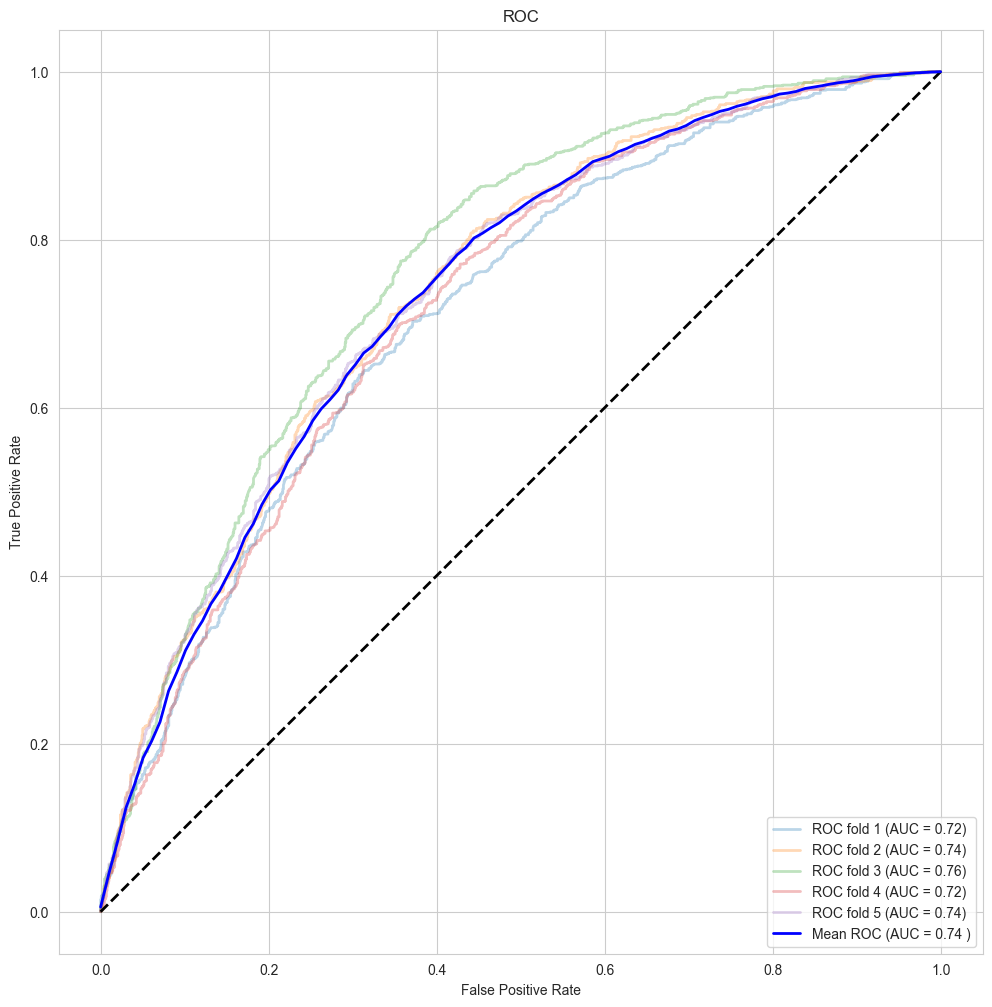

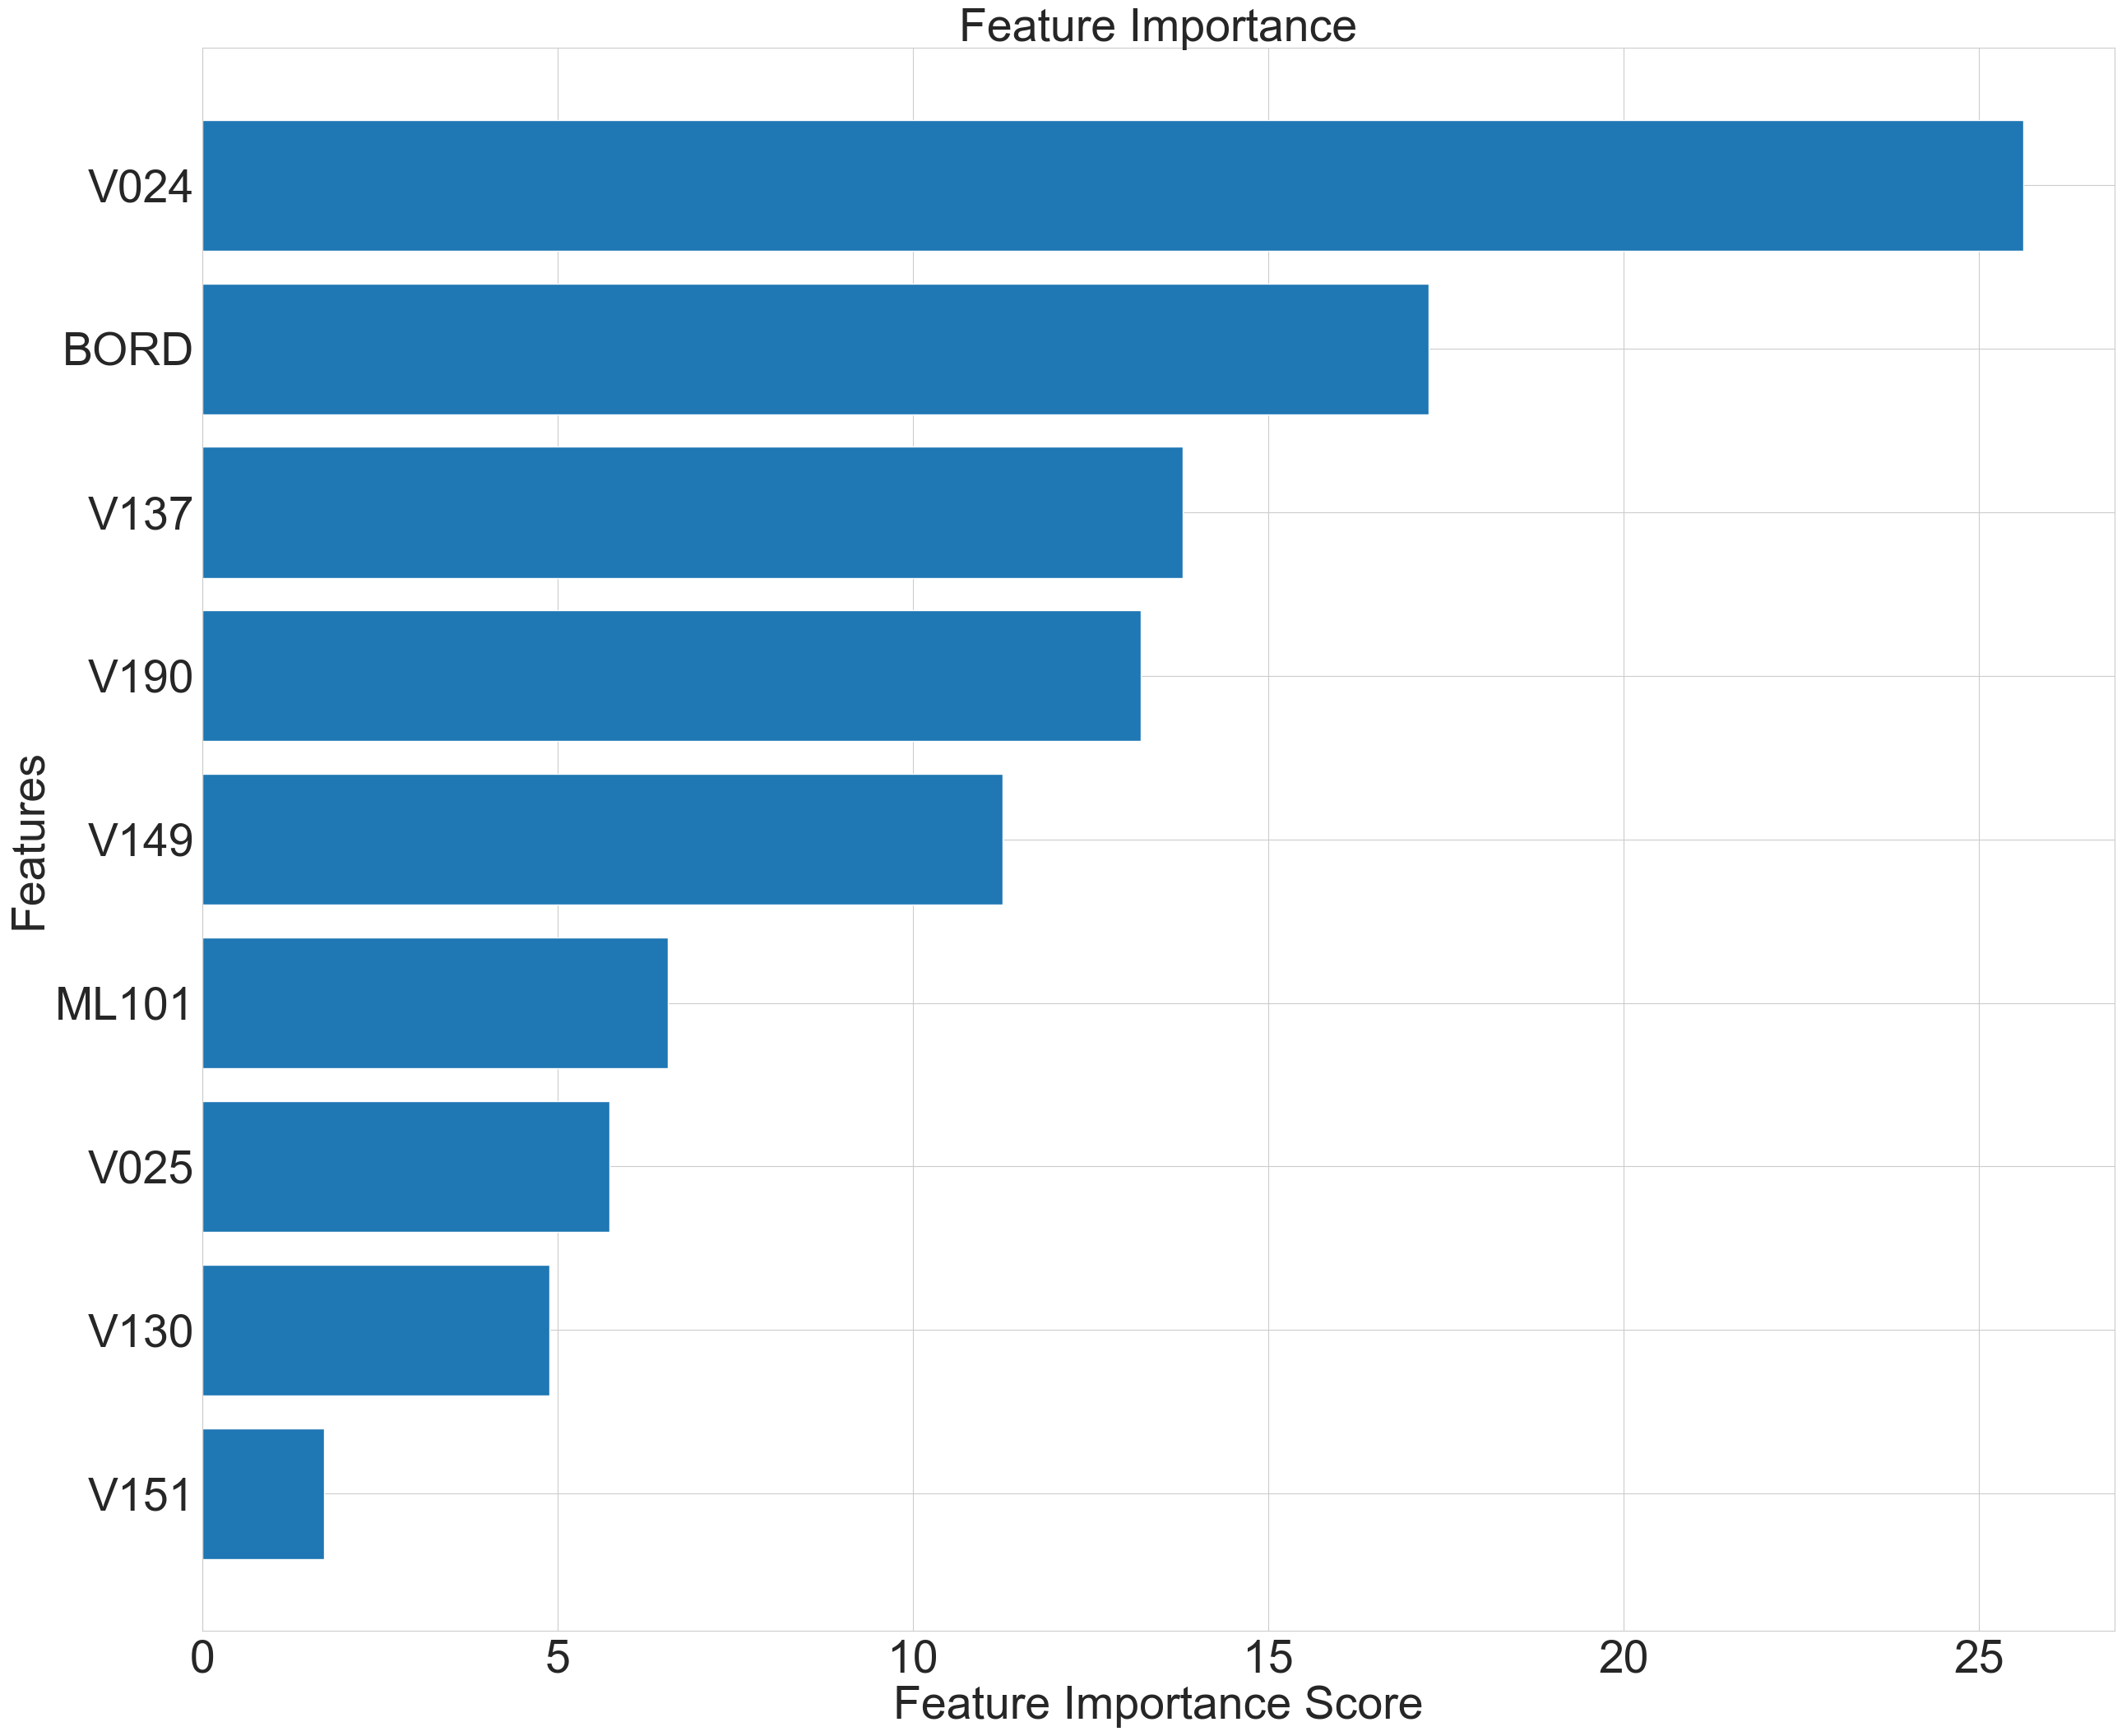

0.8604871404251491 0.8604871404251491 0.02527530901016335
================================Fold1====================================
[09:21:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "objectsve", "scoring", "sub_sample" } are not used.

[0]	validation_0-auc:0.57252
[1]	validation_0-auc:0.59089
[2]	validation_0-auc:0.60053
[3]	validation_0-auc:0.60463
[4]	validation_0-auc:0.60618
[5]	validation_0-auc:0.60993
[6]	validation_0-auc:0.60813
[7]	validation_0-auc:0.61724
[8]	validation_0-auc:0.61711
[9]	validation_0-auc:0.61855
[10]	validation_0-auc:0.62032
[11]	validation_0-auc:0.62446
[12]	validation_0-auc:0.62401
[13]	validation_0-auc:0.62442
[14]	validation_0-auc:0.62576
[15]	validation_0-auc:0.62567
[16]	validation_0-auc:0.62948
[17]	validation_0-auc:0.62990
[18]	validation_0-auc:0.63241
[19]	validation_0-auc:0.63328
[20]	validation_0-auc:0.63434
[21]	validation_0-auc:0.63498
[22]	valida

/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[48]	validation_0-auc:0.65686
[49]	validation_0-auc:0.65686
[50]	validation_0-auc:0.65699
[51]	validation_0-auc:0.65726
[52]	validation_0-auc:0.65896
[53]	validation_0-auc:0.65997
[54]	validation_0-auc:0.66071
[55]	validation_0-auc:0.66086
[56]	validation_0-auc:0.66210
[57]	validation_0-auc:0.66275
[58]	validation_0-auc:0.66367
[59]	validation_0-auc:0.66501
[60]	validation_0-auc:0.66506
[61]	validation_0-auc:0.66559
[62]	validation_0-auc:0.66560
[63]	validation_0-auc:0.66615
[64]	validation_0-auc:0.66595
[65]	validation_0-auc:0.66584
[66]	validation_0-auc:0.66596
[67]	validation_0-auc:0.66679
[68]	validation_0-auc:0.66725
[69]	validation_0-auc:0.66845
[70]	validation_0-auc:0.66849
[71]	validation_0-auc:0.66928
[72]	validation_0-auc:0.66882
[73]	validation_0-auc:0.66946
[74]	validation_0-auc:0.66980
[75]	validation_0-auc:0.66988
[76]	validation_0-auc:0.67089
[77]	validation_0-auc:0.67054
[78]	validation_0-auc:0.67033
[79]	validation_0-auc:0.67053
[80]	validation_0-auc:0.67246
[81]	valid

/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:8

[39]	validation_0-auc:0.67258
[40]	validation_0-auc:0.67284
[41]	validation_0-auc:0.67355
[42]	validation_0-auc:0.67411
[43]	validation_0-auc:0.67351
[44]	validation_0-auc:0.67410
[45]	validation_0-auc:0.67364
[46]	validation_0-auc:0.67348
[47]	validation_0-auc:0.67468
[48]	validation_0-auc:0.67511
[49]	validation_0-auc:0.67679
[50]	validation_0-auc:0.67656
[51]	validation_0-auc:0.67638
[52]	validation_0-auc:0.67581
[53]	validation_0-auc:0.67596
[54]	validation_0-auc:0.67665
[55]	validation_0-auc:0.67655
[56]	validation_0-auc:0.67611
[57]	validation_0-auc:0.67652
[58]	validation_0-auc:0.67757
[59]	validation_0-auc:0.67812
[60]	validation_0-auc:0.67918
[61]	validation_0-auc:0.68015
[62]	validation_0-auc:0.68048
[63]	validation_0-auc:0.68182
[64]	validation_0-auc:0.68193
[65]	validation_0-auc:0.68153
[66]	validation_0-auc:0.68330
[67]	validation_0-auc:0.68405
[68]	validation_0-auc:0.68482
[69]	validation_0-auc:0.68644
[70]	validation_0-auc:0.68740
[71]	validation_0-auc:0.68842
[72]	valid

/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:8

[49]	validation_0-auc:0.65775
[50]	validation_0-auc:0.65738
[51]	validation_0-auc:0.65773
[52]	validation_0-auc:0.65831
[53]	validation_0-auc:0.65927
[54]	validation_0-auc:0.65990
[55]	validation_0-auc:0.65957
[56]	validation_0-auc:0.66031
[57]	validation_0-auc:0.66153
[58]	validation_0-auc:0.66155
[59]	validation_0-auc:0.66227
[60]	validation_0-auc:0.66375
[61]	validation_0-auc:0.66459
[62]	validation_0-auc:0.66480
[63]	validation_0-auc:0.66545
[64]	validation_0-auc:0.66641
[65]	validation_0-auc:0.66721
[66]	validation_0-auc:0.66825
[67]	validation_0-auc:0.66814
[68]	validation_0-auc:0.66883
[69]	validation_0-auc:0.66919
[70]	validation_0-auc:0.66973
[71]	validation_0-auc:0.66978
[72]	validation_0-auc:0.67077
[73]	validation_0-auc:0.67078
[74]	validation_0-auc:0.67135
[75]	validation_0-auc:0.67249
[76]	validation_0-auc:0.67310
[77]	validation_0-auc:0.67335
[78]	validation_0-auc:0.67422
[79]	validation_0-auc:0.67444
[80]	validation_0-auc:0.67409
[81]	validation_0-auc:0.67448
[82]	valid

/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:8

[36]	validation_0-auc:0.65330
[37]	validation_0-auc:0.65390
[38]	validation_0-auc:0.65446
[39]	validation_0-auc:0.65620
[40]	validation_0-auc:0.65793
[41]	validation_0-auc:0.65806
[42]	validation_0-auc:0.65825
[43]	validation_0-auc:0.65830
[44]	validation_0-auc:0.66003
[45]	validation_0-auc:0.66083
[46]	validation_0-auc:0.66193
[47]	validation_0-auc:0.66363
[48]	validation_0-auc:0.66343
[49]	validation_0-auc:0.66427
[50]	validation_0-auc:0.66464
[51]	validation_0-auc:0.66509
[52]	validation_0-auc:0.66472
[53]	validation_0-auc:0.66557
[54]	validation_0-auc:0.66606
[55]	validation_0-auc:0.66640
[56]	validation_0-auc:0.66716
[57]	validation_0-auc:0.66771
[58]	validation_0-auc:0.66984
[59]	validation_0-auc:0.66981
[60]	validation_0-auc:0.67044
[61]	validation_0-auc:0.67122
[62]	validation_0-auc:0.67188
[63]	validation_0-auc:0.67223
[64]	validation_0-auc:0.67195
[65]	validation_0-auc:0.67198
[66]	validation_0-auc:0.67229
[67]	validation_0-auc:0.67246
[68]	validation_0-auc:0.67315
[69]	valid

/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_2146/1942914066.py:122: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:8

[60]	validation_0-auc:0.65828
[61]	validation_0-auc:0.65849
[62]	validation_0-auc:0.66006
[63]	validation_0-auc:0.66083
[64]	validation_0-auc:0.66160
[65]	validation_0-auc:0.66214
[66]	validation_0-auc:0.66246
[67]	validation_0-auc:0.66311
[68]	validation_0-auc:0.66328
[69]	validation_0-auc:0.66468
[70]	validation_0-auc:0.66518
[71]	validation_0-auc:0.66529
[72]	validation_0-auc:0.66571
[73]	validation_0-auc:0.66634
[74]	validation_0-auc:0.66638
[75]	validation_0-auc:0.66674
[76]	validation_0-auc:0.66691
[77]	validation_0-auc:0.66728
[78]	validation_0-auc:0.66853
[79]	validation_0-auc:0.66942
[80]	validation_0-auc:0.66932
[81]	validation_0-auc:0.66957
[82]	validation_0-auc:0.66933
[83]	validation_0-auc:0.67070
[84]	validation_0-auc:0.67023
[85]	validation_0-auc:0.67055
[86]	validation_0-auc:0.67129
[87]	validation_0-auc:0.67216
[88]	validation_0-auc:0.67238
[89]	validation_0-auc:0.67314
[90]	validation_0-auc:0.67372
[91]	validation_0-auc:0.67460
[92]	validation_0-auc:0.67503
[93]	valid

In [70]:
# Results with cross validation and oversamplying
_X, _Y = oversampling()
X_train, X_test, y_train, y_test = train_test_split(_X, _Y, test_size=0.2, random_state=42, stratify=_Y)
with_cross_classifier,with_cross_catboost,with_cross_xgboost,with_cross_rad, with_cross_deci, with_cross_svm = run_predictions(X_train,y_train, X_test)
with_cross_neural_result = train_neural(X_train,y_train,X_test, y_test)
eveluate_model_results(with_cross_catboost,with_cross_xgboost, with_cross_classifier, with_cross_rad,  with_cross_deci, with_cross_svm,with_cross_neural_result, y_test, X_test)

In [71]:
_X, _Y = smote()
X_train, X_test, y_train, y_test = train_test_split(_X, _Y, test_size=0.2, random_state=42, stratify=_Y)
with_cross_classifier,with_cross_catboost,with_cross_xgboost,with_cross_rad, with_cross_deci, with_cross_svm = run_predictions(X_train,y_train, X_test)
with_cross_neural_result = train_neural(X_train,y_train,X_test, y_test)
eveluate_model_results(with_cross_catboost,with_cross_xgboost, with_cross_classifier, with_cross_rad,with_cross_deci, with_cross_svm, with_cross_neural_result, y_test, X_test)

In [72]:
_X, _Y = undersampling()
X_train, X_test, y_train, y_test = train_test_split(_X, _Y, test_size=0.2, random_state=42, stratify=_Y)
with_cross_classifier,with_cross_catboost,with_cross_xgboost,with_cross_rad, with_cross_deci, with_cross_svm = run_predictions(X_train,y_train, X_test)
with_cross_neural_result = train_neural(X_train,y_train,X_test, y_test)
eveluate_model_results(with_cross_catboost,with_cross_xgboost, with_cross_classifier, with_cross_rad, with_cross_deci, with_cross_svm,with_cross_neural_result, y_test, X_test)